<a href="https://colab.research.google.com/github/Romainkul/Datathon_KUL/blob/main/Datathon_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import polars as pl
import requests
from zipfile import ZipFile

# URL to the dataset and base directory where the dataset should reside.
url = "https://kuleuven-datathon-2025.s3.eu-central-1.amazonaws.com/Posters.zip"
base_dir = r"C:\Users\romai\Desktop\datathon\Posters"
zip_path = r"C:\Users\romai\Desktop\datathon\Posters.zip"

# Ensure the base directory exists.
os.makedirs(base_dir, exist_ok=True)

# Download the ZIP file only if it doesn't already exist.
if not os.path.exists(zip_path):
    print("Downloading dataset...")
    response = requests.get(url)
    response.raise_for_status()  # Raise an error for a bad status.
    with open(zip_path, "wb") as f:
        f.write(response.content)
    print("Download complete.")
else:
    print("Zip file already exists. Skipping download.")

# Check if the dataset has been extracted by looking for the 'raw' folder.
raw_dir = os.path.join(base_dir, 'raw')
if not os.path.exists(raw_dir):
    print("Extracting dataset...")
    with ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(base_dir)
    print("Extraction complete.")
else:
    print("Dataset already extracted.")

# Define the paths for the processed images and texts.
processed_dir = os.path.join(base_dir, 'preprocessed')
texts_dir = os.path.join(base_dir, 'texts')

# Map each raw subfolder to the languages that are expected to be available.
folder_language_map = {
    'double_page_german_dutch': ['german', 'dutch'],
    'multipart_dutch': ['dutch'],
    'multipart_french': ['french'],
    'single_patch_dutch': ['dutch'],
    'triple_page_german_dutch_french': ['german', 'dutch', 'french'],
}

# List of valid image extensions.
image_extensions = ('.png', '.jpg', '.jpeg', '.tif', '.tiff')

# Initialize lists for Polars DataFrame
raw_paths, german_processed, dutch_processed, french_processed = [], [], [], []
german_texts, dutch_texts, french_texts = [], [], []

# Loop through each subfolder in the raw directory.
for folder in os.listdir(raw_dir):
    folder_path = os.path.join(raw_dir, folder)
    if not os.path.isdir(folder_path):
        continue

    # Determine which languages are expected for this folder.
    languages = folder_language_map.get(folder, [])

    # Loop through each file in the raw subfolder.
    for filename in os.listdir(folder_path):
        if not filename.lower().endswith(image_extensions):
            continue

        # Full path to the raw image file.
        raw_file_path = os.path.join(folder_path, filename)

        # Prepare paths and texts for available languages
        processed_paths = {lang: os.path.join(processed_dir, lang, filename) if lang in languages else '' 
                           for lang in ['german', 'dutch', 'french']}
        
        texts = {}
        base_name, _ = os.path.splitext(filename)

        for lang in ['german', 'dutch', 'french']:
            text_file_path = os.path.join(texts_dir, lang, base_name + '.jpg.txt')
            if os.path.exists(text_file_path):
                try:
                    with open(text_file_path, 'r', encoding='utf-8') as tf:
                        texts[lang] = tf.read()
                except Exception as e:
                    print(f"Error reading {text_file_path}: {e}")
                    texts[lang] = ''
            else:
                texts[lang] = ''

        # Append data to lists
        raw_paths.append(raw_file_path)
        german_processed.append(processed_paths['german'])
        dutch_processed.append(processed_paths['dutch'])
        french_processed.append(processed_paths['french'])
        german_texts.append(texts['german'])
        dutch_texts.append(texts['dutch'])
        french_texts.append(texts['french'])

# Create a Polars DataFrame
df = pl.DataFrame({
    "raw": raw_paths,
    "german_processed": german_processed,
    "dutch_processed": dutch_processed,
    "french_processed": french_processed,
    "german_text": german_texts,
    "dutch_text": dutch_texts,
    "french_text": french_texts
})

# Preview the DataFrame
print(df.head())

# Optional: Save as a Parquet file for efficient storage
df.write_parquet(os.path.join(base_dir, "posters_data.parquet"))
print("Data saved as Parquet file.")

Zip file already exists. Skipping download.
Dataset already extracted.
shape: (5, 7)
┌──────────────┬─────────────┬─────────────┬─────────────┬─────────────┬─────────────┬─────────────┐
│ raw          ┆ german_proc ┆ dutch_proce ┆ french_proc ┆ german_text ┆ dutch_text  ┆ french_text │
│ ---          ┆ essed       ┆ ssed        ┆ essed       ┆ ---         ┆ ---         ┆ ---         │
│ str          ┆ ---         ┆ ---         ┆ ---         ┆ str         ┆ str         ┆ str         │
│              ┆ str         ┆ str         ┆ str         ┆             ┆             ┆             │
╞══════════════╪═════════════╪═════════════╪═════════════╪═════════════╪═════════════╪═════════════╡
│ C:\Users\rom ┆ C:\Users\ro ┆ C:\Users\ro ┆             ┆ pt a        ┆ oe : ____   ┆             │
│ ai\Desktop\d ┆ mai\Desktop ┆ mai\Desktop ┆             ┆             ┆ hebben de   ┆             │
│ atatho…      ┆ \datatho…   ┆ \datatho…   ┆             ┆ AM oe       ┆ ec ingen 2… ┆             │
│     

In [1]:
import os
import gc
import torch
import polars as pl
import numpy as np

from transformers import pipeline
from sentence_transformers import SentenceTransformer
import os
import polars as pl
import requests
from zipfile import ZipFile

# Disable wandb
os.environ["WANDB_DISABLED"] = "true"

# ---------------------------------------------
# Utility: chunk text so we don't exceed max tokens
# ---------------------------------------------
def chunk_text(text, chunk_size=512):
    """
    Splits text into smaller chunks while preserving words.
    """
    words = text.split()
    return [" ".join(words[i : i + chunk_size]) for i in range(0, len(words), chunk_size)]

# ---------------------------------------------
# 1) Language Detection
# ---------------------------------------------
def detect_language(df: pl.DataFrame) -> pl.DataFrame:
    """
    Loads the language detection pipeline once,
    sets the validation message if the detected language != expected.
    """
    # The known codes for each language
    expected_language_codes = {
        "german": "de",
        "dutch": "nl",
        "french": "fr"
    }
    
    print(f">> Loading language detection model  ...")
    lang_detector = pipeline(
        "text-classification",
        model="papluca/xlm-roberta-base-language-detection"
    )
    df_dicts = df.to_dicts()
    for lang in ['dutch', 'german', 'french']:
      for row in df_dicts:
          text = row.get(f"{lang}_text", "").strip()
          if not text:
              row[f"{lang}_text_validation"] = ""
              continue
          
          try:
              detected = lang_detector(text[:512])[0]["label"].lower()  # partial text is enough
          except Exception as e:
              print(f"Language detection error on row: {e}")
              detected = ""
          
          # If the detected code != the expected code, flag it
          expected_code = expected_language_codes.get(lang, "")
          if detected != expected_code:
              row[f"{lang}_text_validation"] = f"text in {lang} is not the right one"
          else:
              row[f"{lang}_text_validation"] = ""
    
    # Unload pipeline
    del lang_detector
    gc.collect()
    torch.cuda.empty_cache()

    return pl.DataFrame(df_dicts)

# ---------------------------------------------
# 2) Text Improvement
# ---------------------------------------------
def improve_text(df: pl.DataFrame) -> pl.DataFrame:
    """
    Loads the text-generation model once, only improves text
    if the previous validation said it's the correct language.
    """
    improvement_prompt = {
        "german": (
            "Du bist ein OCR-Korrektor. Korrigiere nur OCR-Fehler und ändere sonst nichts. "
            "Gib ausschließlich den korrigierten Text zurück, ohne jegliche Kommentare oder Erklärungen. "
            "Korrigiere nur die OCR-Fehler in dem Text, den der Benutzer senden wird. "
            "Antworte NUR mit dem komplett korrigierten Text, ohne jegliche Erläuterungen oder Kommentare."
        ),
        "dutch": (
            "Je bent een OCR-corrector. Corrigeer uitsluitend OCR-fouten en verander verder niets. "
            "Corrigeer alleen de OCR-fouten in de tekst die de gebruiker zal sturen. "
            "Geef uitsluitend de volledig gecorrigeerde tekst terug, zonder enige toelichting."
        ),
        "french": (
            "Vous êtes un correcteur OCR. Ne corrigez que les erreurs d'OCR et ne modifiez rien d'autre. "
            "Corrigez uniquement les erreurs d’OCR dans le texte que l’utilisateur va envoyer. "
            "Répondez exclusivement avec la version intégralement corrigée, sans aucune explication ni commentaire."
        ),
    }
    
    models={'german':'meta-llama/Llama-3.2-1B-Instruct','dutch':'utter-project/EuroLLM-1.7B-Instruct','french':'meta-llama/Llama-3.2-1B-Instruct'}

    print(f">> Loading text-improvement model ...")
    #imp_pipeline = pipeline("text-generation", model="BSC-LT/salamandra-2b-instruct") #pipeline("text-generation", model="stabilityai/stablelm-2-1_6b")
    df_dicts = df.to_dicts()
    for lang in ['german', 'dutch', 'french']:
      imp_pipeline = pipeline("text-generation", model=models[lang])
      for row in df_dicts:
          validation = row.get(f"{lang}_text_validation", "")
          original_text = row.get(f"{lang}_text", "").strip()

          # If text is empty or we already flagged the language as incorrect, skip improvement
          if not original_text or "not the right one" in validation:
              row[f"improved_{lang}_text"] = original_text
              continue

          # Otherwise, correct the text
          chunks = chunk_text(original_text, chunk_size=512)
          improved_pieces = []
          for chunk in chunks:
            prompt = [{"role": "system", "content": improvement_prompt[lang]},
                        {"role": "user", "content": chunk}]
            try:
                result = imp_pipeline(prompt, max_new_tokens=256)
                  # The pipeline might echo the prompt, so remove it if present
                full_gen = result[-1]["generated_text"][-1]['content']
                  # For safety: remove any leading copy of 'prompt'
                #cleaned = full_gen.replace(prompt, "").strip()
                improved_pieces.append(full_gen if full_gen else chunk)
            except Exception as e:
                  print(f"Improvement error: {e}")
                  improved_pieces.append(chunk)
          print(" ".join(improved_pieces))
          row[f"improved_{lang}_text"] = " ".join(improved_pieces)

      # Unload pipeline
      del imp_pipeline
      gc.collect()
      torch.cuda.empty_cache()

    return pl.DataFrame(df_dicts)

# ---------------------------------------------
# 3) Sentiment Analysis
# ---------------------------------------------
def get_sentiment_score(text,sentiment_pipeline, chunk_size=300):
    """
    Computes sentiment score by chunking text and averaging star ratings (1-5).
    """
    chunks = chunk_text(text, chunk_size)
    scores = []
    for chunk in chunks:
        try:
            result = sentiment_pipeline(chunk, truncation=True, max_length=512)
            label = result[0]['label']  # e.g. '4 stars'
            scores.append(int(label.split()[0]))
        except:
            pass
    return sum(scores)/len(scores) if scores else None

def analyze_sentiment(df: pl.DataFrame) -> pl.DataFrame:
    """
    Loads the sentiment pipeline once, applies to improved texts,
    then unloads.
    """
    print(f">> Loading sentiment model ...")
    sentiment_pipe = pipeline(
        "sentiment-analysis",
        model="nlptown/bert-base-multilingual-uncased-sentiment"
    )

    df_dicts = df.to_dicts()
    for lang in ['dutch', 'german', 'french']:
      for row in df_dicts:
          text = row.get(f"improved_{lang}_text", "").strip()
          if not text:
              row[f"sentiment_{lang}"] = ""
              continue
          
          score = None
          try:
              # We reuse the chunk-based function:
              def local_chunker(txt):
                  for subchunk in chunk_text(txt, 300):
                      yield subchunk

              all_scores = []
              for sub in local_chunker(text):
                  result = sentiment_pipe(sub, truncation=True, max_length=512)
                  label = result[0]['label']
                  all_scores.append(int(label.split()[0]))
              if all_scores:
                  score = sum(all_scores)/len(all_scores)
          except Exception as e:
              print(f"Sentiment error: {e}")
              score = None
          
          if score is not None:
              row[f"sentiment_{lang}"] = f"{score:.2f} stars"
          else:
              row[f"sentiment_{lang}"] = ""

    # Unload pipeline
    del sentiment_pipe
    gc.collect()
    torch.cuda.empty_cache()

    return pl.DataFrame(df_dicts)

# ---------------------------------------------
# 4) Named Entity Recognition
# ---------------------------------------------
def extract_time_location(text):
    """
    Extracts time and location entities using NER.
    """
    if not text.strip():
        return "", ""
    results = ner_pipe(text)
    
    times = {ent['word'] for ent in results if 'TIME' in ent.get('entity', '').upper()}
    locs  = {ent['word'] for ent in results if 'LOC' in ent.get('entity', '').upper()}
    return " ".join(times), " ".join(locs)

def recognize_entities(df: pl.DataFrame) -> pl.DataFrame:
    """
    Loads the NER pipeline once, applies to improved text, unloads after.
    """
    print(f">> Loading NER model...")
    global ner_pipe
    ner_pipe = pipeline(
        "token-classification",
        model="Babelscape/wikineural-multilingual-ner"
    )

    df_dicts = df.to_dicts()
    for lang in ['dutch', 'german', 'french']:
      for row in df_dicts:
          text = row.get(f"improved_{lang}_text", "").strip()
          if not text:
              row[f"extracted_time_{lang}"] = ""
              row[f"extracted_location_{lang}"] = ""
              continue

          t, loc = extract_time_location(text)
          row[f"extracted_time_{lang}"] = t
          row[f"extracted_location_{lang}"] = loc

    # Unload pipeline
    del ner_pipe
    gc.collect()
    torch.cuda.empty_cache()

    return pl.DataFrame(df_dicts)

# ---------------------------------------------
# 5) Zero-Shot Topic Classification
# ---------------------------------------------
WW1_LABELS = [
    "military orders","martial law","war propaganda","German army decrees",
    "anti-resistance measures","civilian resistance","spying and informants",
    "penalties and punishments","executions","arrests and detentions",
    "occupation policies","curfews","travel restrictions","collaboration",
    "civilian cooperation","deportations","censorship","press restrictions",
    "public information control","war economy","wartime taxation","forced labor",
    "food supply","rationing","price controls","black market suppression",
    "public safety","health regulations","refugee management","forced evacuations",
    "civilian trials","public executions","house searches","checkpoint controls",
    "German language imposition","educational censorship","public gathering bans"
]

def zero_shot_topics(df: pl.DataFrame) -> pl.DataFrame:
    """
    Loads a zero-shot classification model once, applies to each row,
    and unloads.
    """
    print(f">> Loading zero-shot model ...")
    zshot_pipeline = pipeline(
        "zero-shot-classification",
        model="joeddav/xlm-roberta-large-xnli",
        force_download=True
    )
    
    df_dicts = df.to_dicts()
    for lang in ['dutch', 'german', 'french']:
      for row in df_dicts:
          text = row.get(f"improved_{lang}_text", "").strip()
          if not text:
              row[f"topics_{lang}_text"] = ""
              continue
          
          try:
              result = zshot_pipeline(
                  text,
                  candidate_labels=WW1_LABELS,
                  multi_label=True
              )
              extracted = [
                  lbl
                  for lbl, score in zip(result["labels"], result["scores"])
                  if score > 0.5
              ]
              row[f"topics_{lang}_text"] = ", ".join(extracted)
          except Exception as e:
              print(f"Zero-shot error: {e}")
              row[f"topics_{lang}_text"] = ""

    # Unload pipeline
    del zshot_pipeline
    gc.collect()
    torch.cuda.empty_cache()

    return pl.DataFrame(df_dicts)

# ---------------------------------------------
# 6) Embeddings
# ---------------------------------------------
def compute_embeddings(df: pl.DataFrame) -> pl.DataFrame:
    """
    Loads the SentenceTransformer once, encodes each improved text, unloads.
    """
    print(f">> Loading embedding model ...")
    emb_model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

    df_dicts = df.to_dicts()
    for lang in ['dutch', 'german', 'french']:
      for row in df_dicts:
          text = row.get(f"improved_{lang}_text", "").strip()
          if not text:
              row[f"{lang}_embedding"] = []
              continue
          try:
              emb = emb_model.encode(text).tolist()
              row[f"{lang}_embedding"] = emb
          except Exception as e:
              print(f"Embedding error: {e}")
              row[f"{lang}_embedding"] = []

    # Unload model
    del emb_model
    gc.collect()
    torch.cuda.empty_cache()

    return pl.DataFrame(df_dicts)


# ---------------------------------------------
#                  Main Flow
# ---------------------------------------------
def process_language(df: pl.DataFrame) -> pl.DataFrame:
    """
    Runs each step in the desired order for a specific language
    and returns the updated DataFrame.
    1) Language detection
    2) Improve text only if correct
    3) Sentiment
    4) NER
    5) Zero-shot classification
    6) Embeddings
    """
    print(f"===== Processing =====")
    df = detect_language(df)
    df = improve_text(df)
    df = analyze_sentiment(df)
    df = recognize_entities(df)
    df = zero_shot_topics(df)
    df = compute_embeddings(df)
    return df


if __name__ == "__main__":
  df = pl.read_parquet(r"C:\Users\romai\Desktop\datathon\Posters\posters_data.parquet")
  df = process_language(df)
  df.write_parquet("preprocessed_df.parquet")

c:\Users\romai\Desktop\datathon\Datathon_KUL\.conda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


===== Processing =====
>> Loading language detection model  ...
>> Loading text-improvement model ...


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


pt a AM oe _finden die Kontrollen der in der Gemeinde = : wohnenden mannlichen Belgier, die in den Jahren 1885 bis 1898 geboren sind, der Mitglieder der ehemaligen Garde civique, der in ihre Heimat. - entlassenen a Mag Oe feindlichen_ Kriegsteilnehmer und der feindlichen Auslander statt. : Die Kontrolle erfolgt in : | ee oe, um Uhr vormittags (deutsche Zeit). Den Anordnungen der Wachmannschaften und der bei der Kontrolle anwesenden belgischen Polizei- und Gemeindebeamten ist — unbedingt Folge zu leisten. Die anwesenden Truppen sind angewiesen, im Bedarfsfalle von den Waffen Gebrauch zu machen. : Die Kontr ollpflichtigen unterstehen am Kontrolltage d den deutschen Kriegsgesetzen. — a Bei der Oniollversimanlung ist Rauchen, sowie das Tragen von : Abzeichen verboten, ca seas he: andere Storung der Offentlichen Ordnung. Der Verka


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Ende Marz 1916 wurden in einem hiesigen Bahnhof 15 Fasser Kakao gestohlen. Wer Angaben macht, die zur Wieder-erlangung des gestohlenen Gutes fahren, hat - eine entsprechende Belohnung zu erwarten. Angaben sind zu richten an den Militar-Polizeimeister Abtlg. Ila, Geschattszimmer 17. Antwerpen, den 29. Mai 1916. Der Kommandant, von FORSTER, Oberst. Druckerei KARL BROEL, Antwerpen.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Unter Bezugnahme auf § 4 der Verordnung des Kaiserlichen Generalgouvernements vom 8. Juli 1916 betr. Bestandsmeldung von KUPFER und ZINN (Ges. u. Verordnungsblatt Nr. 259, S. 2445 ff.) bestimme ich folgendes:

Die Meldescheine gelbe Farbe für die Bestände der Klassen 4 bis 24; grüne Farbe für die Bestände der Klassen 25 bis 27 sind von den anzeigepflichtigen Personen sofort auf die Gemeindehäuser abzuholen und selbst abzugeben. Sofern ein Anzeigepflichtiger besorgt ist, dass eine Vorschrift im 1. Zweifel ist, hat er sich vor Ausfillung des Meldescheins in der Artilleriekaserne Lier, Stube Nr. 55 persönlich einzufinden oder einen Sachverständigen hierher zu senden, um die notwendige Belehrung einzuholen. Kontrolle der Vollständigkeit und Richtigkeit der Anmeldungen behalte ich mir vor. Ich weise darauf hin


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Zur Durchtihrung der durch Verordnung des Kaiserl. General-Gouvernements in Belgien vom 8. Juli 1916 angeordneten Bestandsanmeldungen von Kupfer und Zinn werden von den zustandigen Oriskommandanturen in der Zeit vom Meldescheine ausgegeben, die von den nach § 2 der Verordnung anzeigepflichtigen Personen und Gesellschalten pp. wahrend der Geschaltsstunden von 8 Uhr vorm.- 12 Uhr mit- tags und 3 Uhr bis 7 Uhr nachm.in Empfang zu nehmen sind. — Um eine gewissenhafte Anmeldung der Bestande zu ermoglichen und dadureh allen Weiterungen und Ruckfragen aus dem Wege zu gehen, ist es notwendig, dass die anzeige- pflichtigen Personen selbst das Formular zum Meldeschein bei der zustandigen Ortskommandantur, iber die notwendigenfalls bei der Gemeindebehorde Auskunft gegeben wird, in Empfang nehmen. Die Gesellschaften pp. haben damit einem vertretungsberechtigten und über den Fabrik


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Die Verwaltungschefs für Flandern und Wallonien haben in Ausfiihrung des Art. 10 der Verordnung des Herrn General-Gouverneurs vom 22. August 1916 betr. den Verkehr mit Butter die dem Hersteller für seinen Higenbedarf zustehende Buttermenge bis auf Weiteres mit pees Diese Bestimmung tritt am 1. August 1917 in Kraft; ihre Nichtbefolgung wird mit t den in dem einzigen Aces der Verordnung vom 18. Oktober 1916 Benanntey Strafen geahndet. Antwerpen, den 30. Juli 1917. Der 'Prasident der Zivilverwaltung für die Provinz Antwerpen SCHRAMM Form. 4086. e e, Senator.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


VERORDNUNG betreffend die Unterrichtssprache an den mittleren Unterrichtsanstalten. Unter Aufhebung der Artikel 1 bis einschließlich 5 des Gesetzes vom 15. Juni 1883 itiber den Gebrauch der niederländischen Sprache beim mittleren Unterricht in Flandern uad des Gesetzes vom 12. Mai 1910 iiber das Studium der modernen Sprache an den mittleren Unterrichtsanstalten verordne ich folgendes:

Artikel 4: In allen den Gesetzen vom 1. Juni 1850 und vom 15. Juni 1881 uaterliegenden. Verordnung einschließlich der ihnen angegliederten Kindergarten, vorbereitenden und anderen Abteilungen wird der Unterricht in der niederländischen Landessprache erteilt mit Ausnahme der modernen Fremdsprachen, die in diesen Sprachen selbst unterrichtet werden können.

4. Der Minister für Wissenschaft und Kunst kann für eine bis 1. September 1925 wahrende Übergangzeit besondere Anstalten oder besondere Abteilungen mit und 2 eingereichtet ist, oder 2. die in Artikel 10 und 12 des Gesetzes vom 10. April 1890 vorgeschrie

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


VERORDNUNG betreffend die Unterrichtssprache an den mittleren Unterrichtsanstalten

Unter Aufhebung der Artikel 1 bis einschließlich 5 des Gesetzes vom 15. Juni 1883 itiber den Gebrauch der niederländischen Sprache beim mittleren Unterricht in Flandern uad des Gesetzes vom 12. Mai 1910 iiber das Studium der modernen Sprache im mittleren Unterrichtsanstalt hoher Grades verordne ich folgendes:

4. In allen den Gesetzen vom 1. Juni 1850 und vom 15. Juni 1881 uaterliegenden. Uaterreibiucaatalion einschliesslich der ihnen angegliederten Kindergarten, vorbereitenden und anderen Abteilungen wird der Unterricht in der niederländischen Sprache erteilt mit Ausnahme der modernen Fremdsprachen, die in diesen Sprachen selbst unterrichtet werden können.

5. In den Gemeinden Anderlecht-Kuregem, Briissel, Elsene, Etterbeek, Sint-Gillis, S und 2 eingereichtet ist, oder 2. die in Artikel 10 und 12 des Gesetzes vom 10. April 1890 vorgeschriebene vorbereitende Priifung in niederlandischer Sprache abgeigt 

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Es wird erneut in Erinnerung gebracht, dass im Befehlsbereich des Generalgouvernements Beschlagnahmen und die zu diesem 'Lweck erforderlichen Feststellungen nur von solchen Personen vorgenommen werden diirfen, die im Besitz einer auf den Namen des Inhabers ausgesteliten, mit Dienstsiegel und einem Vermerk iiber die Giltigkeitsdauer versehenen Ausweiskarte nach wach- stehend abgedrucktem Muster sind. ca | Jeder Missbrauch mit diesen Karten wird schwer geahndet. Vorderseite. : Ausweiskarte 'Nr. 20002. Bewijskaart Piece eumpey wa pally Giiltig vom. ee bis Geldig van tot Valable du — ‘ au Inhaber dieses De drager van dese kaart ; (Dienstgrad oder Beruf, Vor- und Zuname) Le porteur de la présente von der _ van de. (Angabe der Dienststelle) — du service de. ist berechtigt, auf Befehl des Generalgouvernements zu heachlagakh


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Auf Grund der Verordnung vom 13. April 1917 betreffend den Gasverbrauch wird bestimmt, dass dank 1/3 der bisher verbrauchten Menge weiter verbraucht werden darf, JEDOCH AUS ENZUGLUNDHANDLUNGEN werden gemäß (Aifi. 4 der vorstehend genannten Verordnung bestraft.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Gouvernements. Der Deutsche Pageshericht BERLIN, 1. Mai. (Amtliche Meldung von heute mittag.) Westlicher Kriegsschauplatz. - Die gestern gemeldeten Kampfe auf dem westlichen Kanalufer nordwestlich von Ypern endeten mit einem sehr verlustreichen Miss- erfolg des Feindes. Oestlich des Kanals noérd- lich von Ypern stiess der Feind mehrere Male vergeblich vor. Die Festung Diinkirchen wurde weiter unter Artilleriefeuer gehalten. Zwischen Maas und Mosel kam es zu|{ Infanteriekaimpfen nur in der Gegend von Ailly und Apremont. Die _ franzésischen Angriffe scheiterten samtlich unter sehr starken Verlusten. Am 29. April wurde —~ Reims in Erwiderung auf die Beschiessung unserer riickwartigen Ruheortschaften mit einigen Granaten beworfen. Da der Feind die Bedeutung dieses unseres Vorgehens sehr gut kennt, wird es ihm leicht sein, Reims vor emer Beschiessung


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


; Veréffentlichungen des deutschen General- Gouvernements. Der Deutsche Tagesbericht. | BERLIN, 3. Mai. (Amtliche Meldung von heute mittag.) Westlicher Kriegsschauplatz. In Flandern griffen wir nordöstlich von Ypern beiderseits der Strasse Poelkappelle-Ypern mit Erfolg an und nahmen die Gehofte von Fortuin, nordöstlich von St. Julien. In der Champagne richteten wir durch erfolgreiche Minensprengungen erheblichen Schaden in der feindlichen Stellung zwischen Souain und Perthes an. Zwischen Maas und Mosel fanden gestern nur Artilleriekimpfe statt. Am Hartmannsweilerkopf machten die Franzosen heute nacht vergebliche Angriffsversuche gegen unsere Gipfelstellung. Ein französisches Flugzeugzeug landete gestern bei Hundlingen, westlich Saar-Meind; die beiden Insassen wurden gefangen genommen. Ein deutsches Flugzeuggeschwader griff gestern die Luftschiffhalle und den Bahnhof Epinal mit ans


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


deutschen General- Gouvernements. Der Deutsche Tagesbericht. BERLIN, 4. Mai. (Amtliche Meldung von heute mittag.) Westlicher Kriegsschauplatz. In Flandern setzten wir unsere Angriffe von Norden und Osten mit grossem Erfolge fort. Heute morgen fielen Zevencote, Zonnebeke, West Hoek, der Polygoneveld-Wald, Nonne Bosschen — alle seit vielen Monaten heiss umstrittene Orte — in unsere Hand. Der abziehende Feind steht unter dem Flankenfeuer unserer Batterien nordlich und siidlich von Ypern. In den Argonnen versuchten die Franzosen nérdlich von Le Four de Paris vergeblich einen von uns am 1. Mai eroberten Graben zurückzunehmen. Die Artilleriekimpfe zwischen Maas und Mosel nahmen auch gestern ihren Fortgang. Oestlicher Kriegsschauplatz. Die Zahl der in der Verfolgung auf Mitau gefangen genommenen Russen ist auf 4000 gestiegen. Erneute russische


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Verdéffentlichungen des deutschen General- Gouvernements. Der Deutsche Tagesbericht. BERLIN, 5. Mai. (Amtliche Meldung von heute mittag.) | Westlicher Kriegsschauplatz. Mit schwersten Verlusten weichen die Englander weiter in der Richtung auf den hart dstlich von YWpern gelegenen Briickenkopi quriick. Bie Ferme van Heule, Eksternest, der Schlosspark von Herenthage und Het Pap- patje Ferme wurden von uns genommen. Zwischen Maas und Mosel herrschte wieder regere Tiitigkeit. Im Priesterwaide, nord- westlich von Pont-a-Mousson griffen die Fran- zosen gestern mit starken Kraften an. Trotz langandauernder Artillerievorbereitung brach der Angriff mit starken Verlusten fiir den - Feind in unserem Feuer zusammen. Dagegen gingen wir im Walde von Ailly und dstlich zum Angriff iiber, der gute Fortschritte machte. Hier nahmen wir bisher 10 Offiziere und 750 Mann gefangen


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Verdffentlichungen des deutschen General- Gouvernements. Der Deutsche Tagesbericht. BERLIN, 6. Mai. (Amtliche Meldung von heute mittag.) | Westlicher Kriegsschauplatz. Fast auf der ganzen Front fanden heftige 'Artilleriekimpfe statt. Bei Ypern wurden weitere Fortschritte, so durch die Einnahme der Ferme Vanheuie, und an der Bahn Mes- - sines-Ypern gemacht. Es wurden einige hundert Gefangene gemacht und 15 Maschinen- _gewehre erbeutet. Im Waldgeliinde westlich Combres fielen bei einem Vorstoss 4 Offiziere, 135 Mann, 4 Maschinengewehre und 1 Minen- werfer in unsere Hand. Unser gestriger An- eriff im Aillywalde fiihrte zu dem erstrebten Erfolge. Der Feind wurde aus seiner Stellung geworfen, mehr als 2 000 Franzosen, darun-ter 21 Offiziere, zwei Geschiitze, mehrere Maschinengewehre und Minenwer


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Verdffentlichungen des deutschen General- Gouvernements. Der Deutsche Tagesbericht. BERLIN, 7. Mai. (Amtliche Meldung von heute mittag.) Westlicher Kriegsschauplatz. Bei Ypern wurden alle Versuche der Engliider, die seit 17. April emaß Brenn- punkt des Kampfes bildende Héhe 60, seitlich von Zillebeke, zu entreissen, vereitelt. Wir gewannen dort weiter Gelande auf Ypern. Der Feind verlor bei diesen Kampfen gestern 7 Maschinengewehre, einen Minenwerfer und eine große Anzahl von Gewehren mit Munition. Bei Fortsetzung ihrer Angriffe erlitten heute früh die Engliider weitere große Werluste. Zwischen Maas und Mosel behaupteten und befestigten wir den auf den Maashöhen und westlich und westlich des Aillywaldes errungenen Gelande-gewinn. Bei Flirey ist ein schmales Grabenstick unserer Stellung noch im Besitz der Franzosen; sonst wurden dort alle Angriffe abgew


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Verdffentlichungen des deutschen General- Gouvernements. Der Deutsche Tagesbericht. BERLIN, 8. Mai. (Amtliche Meldung von heute mittag.) | | Westlicher Kriegsschauplatz. Vor Zeebriigge brachten unsere Kiisten- batterien gestern abend einen feindlichen Zer- stérer zum Sinken. Auf dem gréssten Teile der Front fanden die tblichen Artilleriekampfe statt, die sich an einzelnen Stellen, so bei Ypern, nérdlich von Arras, in den Argonnen und auf den Maashéhen zeitweise steigerten. Zum Infanterieangriff kam es nur in den Vogesen. Hier griffen die Franzosen unsere Stellungen bei Steinabriick beiderseits des Fechttales nach stundenlanger Artillerievorbereitung an; samt-liche Angriffe scheiterten unter starken Ver- lusten fiir den Feind. Oestlicher Kriegsschauplatz. Unsere gegen Libau vorgesandten Truppen setzten sich in den Besitz dieser Stadt. Hierbei fielen 1 


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Veréffentlichungen des deutschen General-_ - Gouvernements. WHIEN, 10. Mai. (Amtliche Meldung von gestern.) In Verfolgung des aus seinen Hohen- stellungen geworfenen Gegners itiberschritten. unsere Kolonnen den Grenzkamm der Kar- pathen. Ungarn ist vom Feinde frei. Auf gali- zischem Boden dauert die Schlacht fort. In einem Frontraum von tiber 200 Kilometern — von der Weichsel bis zum Uzsoker Pass — weicht der Gegner zuriick. Die verbiindeten Armeen iiberschritten unter siegreichen Kiimpfen ungefihr die Linie Uzsoker Pass- - Komanceza-Krosno-Debica-Szezucin. Im Kar- pathenabschnitt éstlich des Uzsoker Passes und an der Front in Siidostgalizien entwickelten sich nun ebenfalls heftigere Kampfe. Unsere Truppen eroberten mehrere russische Stellun- gen. Starke feindliche Krafte greifen unsere Truppen auf den Hodhen nordo


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


deutschen General-Veréffentlichungen des WIEN, 16. Mai. (Amtliche Meldung von gestern.) Die russischen Armeen in Polen und Galizien sind weiter im Rückzug. Auf der ganzen Front von Nowe Miasto an der Pliica bis südlich vom Dnjester in der Gegend von Dolino dringen die vertriebenen Armeen vor. Am San sind Rudnik und Lezajsk von unschränkend, Jaroslau von deutschen Truppen erobert. Das in Mittelgalizien zustehende ésterreichisch-ungarische zehnte Korps steht vor den Toren seiner Heimatstadt Przemysl. Weiter südlich sind Dobromil, Stary,,Sambor und Boryslaw wieder in eigenem Bezitz. Die vertriebenen Truppen der Armee Linsingen erreichten die Hohen westlich von Dolino. In der Pruth-Auenlinie greifen die Russen noch an. In erhebten Kämpfen nérdlich von Kolomea hat kranntnerische und steirische Infanterie des Heeres und der Landwe


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


\ Veréffentlichungen des deutschen General- Gouvernements. eee 0 PSA REO NOLL DEL LEN ERE CIS ELL. ALE OO LOS A Der Deutsche Tagesbericht. BERLIN, 17. Mai. (Amtliche Meldung. von heute mittag.) | — Westlicher Kriegsschauplatz. Noérdlich von Ypern westlich des Kanals bei Steenstrate und Het Sas gaben wir unsere vorgeschobenen Stellungen auf und zogen die dort stehenden schwachen Kriifte, um Verluste durch starkes feindliches Artilleriefeuer zu verhindern, in unsere Hauptstellungen am ost- lichen Kanalufer zuriick. Westlich von Neuve- Chapelle halten die Englinder noch die Teile unseres vorderen Grabens, die seit den vorges- trigen Kampfen in ihrer Hand sind. Das Gefecht dauert noch an. Noérdlich von Arras, bei Ablain und Neuville wiesen wir franz0- sische Angriffe sehr verlustreich fiir den Gegner ab. Bei Ailly und im Priesterwalde haben


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Veriffentlichungen des deutschen General- Gouvernements. Der Deutsche Tagesbericht. BERLIN, 18. Mai. (Amtliche Meldung von heute mittag.) Westlicher Kriegsschauplatz. Nérdlich von Ypern am Kanal bei Steen- strate und Het Sas herrschte gestern Ruhe. Auf dem 6stlichen Kanalufer siidéstlich von Boesinghe entwickelten sich an einzelnen Stellen Kiampfe, die noch fortdauern. Siidlich von N euve-Chapelle versuchten die Englinder gestern und heute nacht vergeblich weiteren Boden zu gewinnen. Alle Angriffe wurden unter starken Verlusten fiir den Feind abgewiesen. Erneute franzésische Angriffe an der Lorettohéhe bei Ablain und westlich Souchez scheiterten. 170 Gefan- gene blieben in unserer Hand. Bei Ailly kam der Infanteriekampf zum Stilstand. Ein fran- zésischer Vorstoss im Priesterwalde brach in unserem flankierenden Feuer zusammen. Ocsilicher


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


deutschen General- Gouvernements. WIEN, 21. Mai. (Amtliche Meldung von gestern.) Qestlich von Jaroslau und bei Sieniawa wurden starke russische Angriffe unter schweren Verlusten des Feindes zurückgegangen. Die verbiindeten Truppen wären nach Ost und Siidost Raum gezogen. In den Kiampfen am oberen Dnjester wurden weitere 5600 Gefangene gemacht. Die Russen wurden in einem Abschnitt nordlich von Sam- bor aus ihrer Hauptverteidigungsstellung geworfen. Eine Ortschaft 10 Kilometer südwestlich von Moskiska wurde erstigend. An der Pruthlinie ist die Situation unverandert. Nordlich von Kolomea brachte ein kurzer Gegenstoss 1 400 Gefangene ein. DARDANELLEN, 20. Mai. Der Sonder-berichterstatter des Wolfischen Telegraphen- bureaus meldet : Seit der Torpedierung des « Goliath » drang die Flotte der Alliierten nicht in die innere Meerenge. Stets kommen wenige Schiffe nur für eine


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


J é : “ ¥ ergeben kénnten, ab. Veréffentlichungen des deutschen General- Gouvernements. WIEN, 22. Mai. Die Regierung. beantwortete die Mitteilung Italiens, dass es den Dreibundvertrag als aufgehoben betrachtet, mit einer Note, die gestern nachmittag dem italienischen Botschafter tibergeben | wurde. Die Note schliesst : Die K. K. Regierung vermag die Erklirung der italienischen Regierung, ihre volle Handlungsfreiheit wieder- erlangen zu wollen und ihren Biindnisvertrag mit Oesterreich-Ungarn als nichtig und fortan wirkungslos zu betrachten, nicht zur Kennt- nis zu nehmen, da eine solche Erklarung im entschiedenen Widerspruch zu den feierlich eingegangenen Verpflichtungen steht, welche Italien im Vertrage vom 5. Dezember 1912 auf sich nahm, welcher die Dauer unserer Allianz bis zum 8. Juli 1920 festsetzte, seme Kiindigung nur ein Jahr vorher


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Verdffentlichungen des deutschen General- Gouvernements. KONSTANTINOPEL, 24. Mai. Das Hauptquartier, meldet : In der Nacht vom 22. zum 23., Mai versuchte der Feind, sich unserem linken Fliigel zu nihern, wurde aber mit Verlusten fiir ihn zuriickgeworfen. Am 22. Mai friih wurde. ein feindlicher Kreuzer vor Kaba Tepe durd) das Feuer unserer | Artillerie schwer beschadigt, ausserdem wurde er von zwei Flugzeugbomben getrofien und wurde von fiinf Kriegsfahrzeugen weg- geschleppt. Gestern war in Ari Burnu und Sedd-il-Bahr keine Kampfhandlung. Die feindlichen Verluste an Toten und Verwun- deten wahrend der Schlacht von Sedd-il- Bahr am 22. Mai belaufen sich auf mehr als 4000 Mann. Gestern beschossen die feind- |. lichen Schiffe unsere Infanterie-Stellungen an beiden Seiten des Eingangs zur Meerenge— schwach und wirkungslos. E


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Veréffentlichungen des deutschen General- Gouvernements. WIEN, 30. Mai. (Amtliche Meldung von gestern.) | Nordostlicher Krie paccond An der Lubaczewka und dstlich von Radymno versuchten die Russen auch gestern und heute nacht an mehreren Stellen heftige Angriffe, die alle unter schweren Verlusten tiir den Feind abgewiesen wurden. Am Ostufer des San dringen die verbiindeten Truppen unter fortdauernden Kimpfen vor. Am oberen Dnjestr, dann bei Drohobyez und Stryj sind die eigenen Angriffe bis auf die nichsten Distanzen vorgetragen worden. Die Vorstisse der Russen wurden durchweg blutig. Die sonstige Lage ist unver- iindert. Stidwestlicher Kriegsschauplatz. Den Grenzort Ala und das Primiero erreich-. ten italienische Truppen. Im iibrigen ereignete sich an der Tiroler und Kirntener Grenze nichts. Em Kiistenland begannen_ kleinere Kimpfe. Bei Karfreit wurde


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Verdffentlichungen des deutschen General- Gouvernements
BERLIN, 31. Mai.
(Amtliche Meldung von heute an: )

Westlicher OE OR Gestern versuchten die Franzosen sowohl nördlich von Arras wie im Priesterwalde mit starken Kraften unsere Front zu durch- brechen.
Bei Arras hatte der Gegner sich auf der Front Neuville-Roclincourt in den letzten Tagen durch Sappen herangearbeitet.
Ein Angriff auf diese Linie wurde daher, nach dem alle Versuche " uns weiter nordlich aus unseren Stellungen mordern, misslungen waren, erwartet.
Erfolgte gestern nachmittags nach stundenlanger pao vorbereitung und fihrte durch die Tapferkeit'rhemischer und bayerischer Regimenter zu einer ganzlichen Niederlage des Gegners.
Seine Verluste sind aussergewönlich hoch.
Im Priesterwalde gelang es den Franzosen, nur in einige vorgeschobene, schwach besetzte Graben einzudringen.
Im fibrigen ist auch hier der feindliche Angriff gescheitert.
Bei


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Veréffentlichungen des deutschen General- Gouvernements. BERLIN, 4. Juni. (Amtliche Meldung von heute mittag.) | | ‘ Westlicher Kriegsschauplatz. : Das Schloss und der Ort Hooge ostlich von Ypern ist bis auf wenige Hauser am West- rande von uns gestiirmt. Englische Gegen- angriffe wurden blutig abgewiesen. Qestlich von Givenchy gelang es gestern abend en-. glischen Truppen, in unsere Stellung einzu- dringen. Em Gegenangriff warf den Feind unter schweren Verlusten wieder hinaus. Drei englische Maschinengewehre blieben in unserer Hand. Die Stellung ist liickenlos in unserem Besitze. Die Zuckerfabrik Souchez ist nach hin- und herwogendem Kampfe von uns besetzt. An der Bahn westlich von Sou-chez ist der Kampf im Gange. Ein starker’ feindlicher Angriff auf unsere Graben bei und -nordlich von Neuville brach im Artilleriefeuer zusammen. Siidlich


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Verfängungen des WIEN, 11. Juni. (Amtliche Meldung von gestern.) Aesth Kriegsschauplatz. - Die Kampfe am oberen Dnjester und im Raume zwischen Dnjester und Pruth dauern fort. Die Armee Pflanzer-Baltin gewinnt weiter Raum nach Norden. Ihre Angriffs- kolonnen dringen unter fortdauernden Kampfen bis Obertyn und auf die Héhen siid- lich von Horodenka vor. Dem erfolgreichen Vorgehen der auf galizischem Boden fech- tenden Teile der Armee schloss sich nun auch eine Gruppe in der Bukowina an, die gestern den Pruth iiberschritt und starke russische Kriifte siidwestlich von Kotzmann zuriick- warf. Die sonstige Lage im Norden ist unver- andert. | | Italienischer Kriegsschauplatz. An der Isonzofront wurden neuerliche Uebergangsversuche des Feindes bei Plava, Gradisca und Sagrado abgewiesen. In der Gegend


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


- Verdffentlichungen des deutschen General- Gouvernements. BERLIN, 11. Juni. (Amtliche Meldung von heute mittag.) | | | Westlicher Kriegsschauplatz. Feindliche Vorstésse nordöstlich der Loretto- héhe sowie wiederholte Angrifle gegen unsere Stellungen nordöstlich und südöstlich von Neuville scheiterten. Der Nahkampf in den Graben nordöstlich von Ecurie dauert noch an. Südöstlich und östlich von Ecurie wurden feindliche Angriffe gestern und heute nacht-abgewiesen; nur in der Gegend von Serre-Mailly erzielten die Franzosen einen - unbedeutenden Fortschritt. Die in der Cham- pagne am 9. Juni eroberten Griiben versuchten die Franzosen uns. gestern abend wieder au entreissen. Mit starken Kraften und in breiter Front griffen sie nordöstlich von Le Mesnil bis nordöstlich von Beauséjour-Ferme an. Der Angriff brach unter schwersten Verlusten fiinzlich zusammen. Erneute nichtliche


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Verdéffentlichungen des deutschen General- Gouvernements. BERLIN, 12. Juni. (Amtliche Meldung von heute mittag.) | Westlicher Kriegsschauplatz. Feindliche Angriffe in den Diinen, nord- jstlich von Nieuport und bei Mannekensvere, auf dem Ostrand der Lorettohéhe und in der Gegend von Souchez wurden abgeschlagen. In dem Nahkampf nérdlich Ecurie (Laby- rinth) setzten die Franzosen gestern LWel- mal frische Krifte ein; es gelang, den Feind am Nachmittag vollkommen aus unseren Stel- lungen zu werfen; ein abends einsetzender neuer Vorstoss der Franzosen brach im Infan- teriefeuer zusammen; der zuriickflutende -Feind erlitt sehr erhebliche Verluste. Bei Serre, siidiéstlich Hébuterne, sind wir aus unseren riickwirtigen Stellungen wieder im - Worgehen. - Oestlicher Kriegsschauplatz. — An der Dubissa,


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


gen des WHEN, 12. Juni. (Amtliche Meldung. von gestern.) Russischer Kriegsschauplatz. — In Siidostgalizien und in der Bukowina setzten die verbiindeten Armeen den Angriff gegen die noch siidlich des Dnjestr stehenden russischen Krafte erfolgreich fort. Die Truppen der Armee Pflanzer warfen den Gegner aus ihren Stellungen nérdlich von Ottinya, bet Obertyn und bei Horodenka, auriick und sind im Vordringen an den Dnejstr, dessen Siidufer die Russen noch zu halten versuchen. Knapp éstlich von Czernowitz, an der einzigen Stelle, wo die Russen noch am Pruth stehen, wiesen unsere Truppen nach kurzem Kampfe einen Angriff des Feindes ab. Im iibrigen ist die Lage im Norden unverandert. Ttalienischer Kriegsschauplatz. Vorgestern und gestern wurden siamtliche Angriffe der Italiener auf allen Fronten abge- wiesen. Ein neuerlicher, gegen einen


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Veriffentlichungen des deutschen General- Gouvernements. _ WIEN, 13. Juni. | ethelee Meldang von gestern.) _Russischer Kricegsschauplatz. Zwischen Dnjestr und Pruth bekimpften Truppen der Armee Pilanzer neuerdings meh- rere russische Stellungen. Die Orte Jezierzany und Niezwiska nérdlich von Obertyn wurden erstiirmt. Unsere siegreichen Truppen dringen gegen Czernelica vor und tiberschritten dort éstlich von Horodenka den Dnjestr. Zalesz- czuki wurde genommen. Gegen diese Stadt -vichteten die Russen abends und wahrend der Nacht verzweifelte Angriffe, die alle unter den schwersten Verlusten des Feindes abgewiesen wurden. Auch die Attacke eines HKosaken- regiments brach in unserem Feuer vollstandig zusammen. In der Bukowina mussten die Rus- sen auch die letzten Stellungen am Pruth auf- geben. Sie zichen sich, von unseren Truppen scharf verfolgt, unter grossen Verlusten


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


-Veréffentlichungen des deutschen General- Gouvernements BERLIN, 14. Juni. (Amtliche Meldung von gestern.) | 3 | Westlicher Kriegsschauplatz. Bei Nieuport, Dixmuiden, ndérdlich von Arras und bei Hébuterne fanden Artillerie- kampfe statt. Schwachliche Angrifisversuche des Gegners in den Diinen wurden abgewie- sen. Siidéstlich von Hebuterne sind Infanterie- gefechte im Gange. Die militirischen Anlagen um Lunéville wurden mit Bomben belegt. Ocsilischer Kriegsschauplatz. — Nordwestlich von Szawle machten nnsere Angriffe gute Fortschritte. Kuze wurde im Sturm genommen. Feindliche Gegenstésse scheiterten; 8 Offiziere, 3350 Mann und S Maschinengewehre waren unsere Beute. Siidéstlich der Strasse Mariampol-Kowno _ haben die Kimpfe gegen von Siiden herange- kommene russische Vertirkungen erneut begonnen. No


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Verdffentlichungen des deutschen General-‘Gouvernements. WIEN, 14. Juni. (Amtliche Meldung von gestern.) - Russischer Kriegsschauplatz. _ In Siidostgalizien dringen die Truppen der Armee Pflanzer weiter siegreich vor. Nach hartnickigen Kimpfen wurden gestern Tysme- nica, Tlumacz und die Héhen nérdlich von Olezzagenommen. Siidlich von Czernelica wird eekiimpit. Neue russische Angrifle gegen Za- leszezyki wurden blutig abgewiesen. Aus der Bukowina iiber die Reichsgrenze vordringend, - ~ warfen unsere Truppen die Russen aus ihren lings der Grenze vorbereiteten starken Stel-_ -Tungen zuriick. In der Verfolgung wurden mehrere Orte Bessarabiens besetzt. Gestern fielen 1560 Gefangene in die Hinde der Verfolger. Am oberen Dnjestr greifen die verbiindeten| Truppen erfolgreich in der Richtung auf Zydaczow an, wo noch star


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Veréffentlichungen des deutschen General- Gouvernements. BERLIN, 14. Juni. (Amtliche Meldung von heute mittag.) Westlicher Kriegsschauplatz. Auf der Front zwischen Liévin und Arras erlitten die Franzosen eine schwere Nieder- lage. Nachdem im Verlaufe des Tages mehr- mals die zum Vorgehen bereitgestellten feind- Jichen Sturmkolonnen durch unser Artillerie- feuer vertrieben waren, setzten gegen Abend zwei starke feindliche Angriffe in dichten Linien gegen unsere Stellungen beiderseits der Lorettohéhe, sowie auf der Front Neuville- Roclincourt ein. Der Gegner wurde iberall unter schweren Verlusten zuriickgeworfen. Samtliche Stellungen sind voll in unserem Besitze geblieben. Schwachere Angrife des Feindes am Yserkanal wurden abgeschlagen. Siidéstlich Hébuterne haben die Infanterie- gefechte zu kemen nennenswerten Ergebnis- sen gefiihrt. Vorst


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Veroffentlichungen des deutschen General- Gouvernements. BERLIN, 15. Juni. (Amtliche Meldung von heute mittag.) a | Westlicher Kriegsschauplatz. Die Franzosen holten sich gestern eine neue Niederlage. Trotz der am 13. Juni erlittenen schweren Verluste setzten sie ihren Durchbruchsversuch auf der Front Liévin-Arras mit großer Zügigkeit fort. Die mit einem ungeheuren Munitionsaufwand vorbereiteten und in dichten Wellen vorgeiragenen französischen Angriffe brachen abermals in dem Feuer unserer braven Truppen unter den schwersten Verlusten fiir den Feind ausnahmslos zusammen. Nordwestlich von Moulin-sous-Touvent (nordwestlich von Soissons) gelang es uns noch nicht, die am 6. Juni verlorenen Grabenstätten wieder zu nehmen. In der Champagne nérdlich von Perthes und Le Mesnil lebte der Kampf stellenweise wieder auf, ohne dass der Feind einen Vorteil zu erringen vermochte. Am


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Verdffentlichungen des WIEN, 16. Juni. (Amtliche Meldung von gestern.) Russischer Kriegsschauptalz. Durch einen Angriff der verbiindeten— Armeen entwickelten sich nahezu auf der ganzen Front in Galizien heftige Kampfe. Die Truppen der Armee des Erzherzogs Josef Ferdinand dringen nach der Besitznahme von Sieniawa am Ostufer des San in nordöstlicher und nordöstlicher Richtung vor. Schloss und - Meierhof Piskorowice wurden gestern er- stigiert und zahlreiche Gefangene wurden gemacht. Unter erbitterten Kampfen dringt die Armee des Generalobersten von Mackensen beiderseits von Krakowice und auf Oleszyce vor. Anschliessend greifen die Truppen des Generals Boehm-Ermolli die Russen estlich | und siidéstlich von Mosziska an, wo neue feindliche Stellungen die Richtung auf Grodek decken. Siidlich des oberen Dnjestr halten starke russische Kriifte die Briickenképfe von Mikol


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Veréffentlichungen des deutschen General- Gouvernements. BERLIN, 16. Juni. (Amtliche Meldung von heute mittag.) Westlicher Kriegsschauplatz. Wieder einmal veranlasst durch die russi- schen Niederlagen, griffen Franzosen und Englinder gestern an vielen Stellen der West- front mit starken Kraften an. Den Englan- dern gelang es bei Ypern, unsere Stellung nérdlich des Teiches vom Bellewaarde etwas muriickzudriicken. Es wird dort noch gekampit. Dagegen sind zwei Angriffe von vier engl- schen Divisionen zwischen der Strasse Estai- res-La Bassée und dem Kanal von La Bassee vollkommen zusammengebrochen. Unsere tapferen westfalischen Regimenter und dort - eingetroffene Teile der Garde wiesen den Ansturm nach erbittertem Nahkampfe restlos ab. Der Feind hatte schwere Verluste. Er less mehrere Maschinengewehre und einen Minen- werfer in unserer Hand. An die Stellung der sich mit grésster


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Verdffentlichungen des deutschen General- Gouvernements. WIEN, 17. Juni. (Amtliche Meldung von gestern.)

Russischer Kriegsschauplatz. In Galizien konnten die Russen dem allge-  nem Angriff der verbiindeten Armeen trotz zahester Gegenwehr nicht standhalten. Yon unseren siegreichen Truppen hart verfolgt, weichen die Reste der geschlagenen russischen Korps tiber Cewkow, Lubaczow und Jawo- row zurück.

Siidlich der Lemberger Strasse erstiirmte die Armee Boehm-Ermolli heute nacht die russischen Stellungen auf der ganzen 'Front und warf den Feind tiber Sadowa- - Wisznia und Rudki zurück.

Siidlich des Dnjestr wird im Vorfelde der Briickenkople gekiimpft. Die Truppen der Armee Pflanzer nahmen gestern friih Nizniow. Die bis- herigen Schlachten und Gefechte des Monats Juni brachten eine reiche Beute ein. Vom I. bis 15. Juni


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Verdffentlichungen des deutschen General- Gouvernements
BERLIN, 17. Juni. ‘disimains ee vor heute mittag.) Westlicher Kriegsschauplatz. Nérdlich des Teiches von Bellegaarde wur- den die vorgestern verlorenen Grabenstiicke zum grissten Teile wieder gewonnen. Die Englander und Franzosen setzten gestern ihren Durchbruchsversuch fort. Noérdlich des Kanals von La Bassée wurden die Englander von Westfalen und Sachsen im Kampige- menge tiberwalligt und zu beschleunigtem Riickzuge im ihre Stellungen gezwungen. Gegen die Front von westlich Liévin bis Arras ‘richteten die‘ Franzosen fortgesetzt neue An- eriffe. An der Lorettohéhe wurde ihnen ein vollig zusammengeschossener Graben iiber- lassen. Siidlich von Souchez gelang es ihnen, in unserer Stellung in einer Breite von etwa 600 Meter Fuss zu fassen. Dort wird noch gekiimpft. An allen anderen Stellen wurden ‘sie blutig abgew


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Weréffentlichungen des deutschen General- Gouvernements. WIEN, 18. Juni. (Amtliche Meldung von gestern.) : | Russischer Kriegsschauplatz. Auch gestern konnten die geschlagenen rus- sischen Armeen nirgends Stand halten. In- Mittelgalizien setzten sie auf der ganzen Front, durch starke Nachhuten gedeckt, den Riickzug in nordöstlicher und östlicher Richtung fort. Die verbiindeten Armeen verfolgen scharf. Nérdlich von Sieniawa dringen unsere Truppen iiber Cieplice und Cewkow vor und warfen gestern starke russische Kriifte, die noch auf galizischem Boden kaimpften, unter schweren Verlusten iiber die Reichsgrenze zuriick. Oestlich anschliessend erreichten die verbiindeten Truppen Lubaczow und entrissen den Russen nach heftigem Kampfe Niemirow und dringen’ weiter auf Janow vor. An der Lemberger Strasse warfen Truppen der Armee Boeh


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Verfänglichungen des deutschen General- (souvernements. BERLIN, 18. Juni. (Amtliche Meldung von heute mittag.) | Westlicher Kriegsschauplatsz. Die Feinde setzten ihren Durchbruchsver- such nérdlich von Arras vergeblich fort. Die Englander erlitten nérdlich des Kanals von La Bassée eine neue Niederlage; ihre Angrifis- truppen wurden aufgerieben, nur einzeine Leute fliichteten sich zuriick. | Oestlich von Angres, siidlich von Souchez und nérdlich van Ecurie sind die Franzosen in kleine Teile unserer vorderen Stellung eingedrungen. Hart nérdlich von der Loretto- héhe gaben wir ein im umfassenden Feuer liegendes Grabenstiick planmiissig auf. Im iibrigen wurden die feindlichen Angrifle abgeschlagen. Seit dem 16. Juni haben wir auf dem Kampffelde nérdlich von Arras 17 Offiziere und 647 Mann gefangen genom- men. Die blutigen Verluste


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Veroffentlichungen ges deutschen General- -Gouvernements. WIEN, 19. Juni. (Amtliche Meldung von gestern.) Russischer Kriegsschauplatz. Nordlich von Sieniawa drangen unsere Truppen in der Verfolgung auf russisches -Gebiet vor und erreichten die Héhen nérdlich von Kreszow, die Niederung des Tanew und besetzten Tarnograd. Auch die zwischen dem unteren San und der Weichsel stehenden russischen Krifte weichen an mehreren Stellen zuriick. Cieszanow und die Hoéhen nérdlich des Ortes wurden genommen. — Im - Berglande dstlich von Niemirow sowie in| der Gegend bei Janow stellten sich starke russische Krifte. An der Wereszyca wird gekimpft. Unsere Truppen fassten an einigen Stellen schon dstlich des Flusses Fuss. Siidlich des oberen Dnjestr mussten die - Russen nach heftigen Kampfen aus den Stel- lungen bei Litynia gegen Kolodruby zuriick- weichen.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


diciiohée Gensel. Gouvernements. BERLIN, 19. Juni. (Amtliche Meldung von heute mittag.) Westlicher K: riegsschauplats. Die Fortsetzung der Angriffe auf unsere Front nérdlich von Arras brachte dem Feimnde weitere Misserfolge. Nérdlich des Kanals von La Bassée wurde ein englischer Vorstoss miihelos abgewiesen. Mehrere franzésische Angriffe an der Lorettohéhe, beiderseits Neuville und nordöstlich Arras brachen 1zu- zusammen. Wir sauberten unsereige friher ver- lorene Grabenstiicke vom Feinde. In den Argonnen wurden lokale Vorstésse des Feindes im Bajonettkampf abgewiesen. Die Kimpfe bei Vauquois haben za _ keinem Ergebnis gefiihrt. Nordöstlich von Lunéville wurde der von den Franzosen befestigte und besetzte Ort Embermenil genommen. Nach der Herstérung aller franzésischen Verteidigungs- anlagen gingen unsere Tr


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Gouvernements. WIEN, 20. Juni. (Amtliche Meldung von gestern. ) Russischer Kriegsschauptlatz. Die galizische Schlacht dauert fort. Im Ansturm gegen die zusammenhiingende russi- sche Verteidigungsstellung an und nérdlich von der Wereszyca erkampften die Truppen der verbiindeten Armeen Stellung um Stel- lung. Grodek und Komarno sind genommen. An der Nordfront wurde das siidliche Tanew- ufer vom Feinde gesiubert. Ulanow wurde nach heftigem Kampfe besetzt. Siidlich des -oberen Dnjestr schreitet der Angriff der Ver- biindeten fort. Die Ostgruppe der Armee Pflanzer schlug russische Angriffe wieder blutig zuriick. —Ttalienischer Kriegsschauplatz. An der Isonzofront und an der Karntner Grenze trat nach den letzten erfolglosen und _ verlustreichen Vorstéssen der Italiener Ruhe ein, die nur durch Plankelei und


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Veréffentlichungen des deutschen General- Gouvernements. BERLIN, 21. Juni. (Amtliche Meldung von gestern.) Westlicher Kriegsschauplatz. Noérdlich des Kanals von La Bassée und auf der Front nérdlich von Arras wiesen wir mehrere feindliche Teilangriffe blutig ab. In der Champagne wurde eine französische Abtei- lung, die bei Perthes nach einer Minenspren- gung angriff, zusammengeschossen. Unter- nehmungen der Franzosen gegen unsere Vor- posten am Parroy Walde fihrten zu értlichen Kampfen, bei denen wir die Oberhand be- hielten. In den Vogesen wird Miinster von den Franzosen heftig beschossen. Erneute feindliche Angriffe im Fechttale und siidlich _ davon waren erfolglos. Aus einem feindlichen Flugzeuggeschwader, das, ohne militarischen Schaden anzurichten, Bomben auf Iseghem in Flandern warf, wurde ein Flugzeug heraus- geschossen, mehrere andere


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Veréffentlichungen des deutschen General- fsouvernements. BERLIN, 21. Juni. (Amtliche Meldung von heute mittag.) Westlicher Kriegsschauplatz. Gegen die Front nérdlich von Arras beschrinkte sich der Gegner hauptsiachlich auf Artilleriefeuer. Nur nérdlich von Souchez erfolgte ein Infanterieangriff, der von uns abgewiesen wurde. Westlich von Soissons scheiterte ein vereinzelter niichtlicher fran- zésischer Worstoss gegen unsere Stellung westlich von Moulin - sous -Touvent. Am Westrande der Argonnen gingen wir zum Angriffe iiber. Wiirtembergische und nord- deutsche Landwehr erstiirmten auf 2 Km Frontbreite mehrere hintereinander legende Verteidigungslinien und fiigten den Franzosen bei ihrem vergeblichen Gegenangriffe die schwersten Werluste zu. Die Beute dieses Kampfes betrug an Gefangenen 6 Offiziere, 623 Mann, sowie 3 Maschinengewehre und 3 Minenwerfer


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Veréffentlichungen des deutschen: General- Gouvernements. WIEN, 22. Juni. (Amtliche Meldung von gestern.) Russischer Kriegsschauplatz. Die verbiindeten Truppen sind in der Verfolzung bis vor Zolkiew und bis nahe an Lemberg und südlich der Stadt bis an den Sezerek-Bach vorgegangen. Die in dieser Linie stehenden russischen Krafte wurden immer angegriffen. Bei Mikolajow und Zyzdaczow hielten der Feind am Dnjestr. Truppen der Armee Pflanzer schlugen heftige Angriffe der Russen südwestlich von Potok und Zloty, bei Zaleszezyki und im bessarabischen Grenzgebiet wieder unter den schwersten Verlusten des Feindes zurück. Die sonstige Lage im Nordosten ist unverändert. Italienischer BKriegsschauplatz. In der Nacht zum 20. Juni schlugen unsere tapferen Truppen wieder zwei italienische Angriffe ab. Hier erschien ein italienischer Offizier


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


gen des deutschen General- -Gouvernements. WIEN, 22. Juni. (Amtlich.) Unsere zweite Armee eroberte heute nach hartem Kampfe Lemberg. BERLIN, 21. Juni. (Amtlich.) Am 20. Juni griff eines unserer Unterseeboote etwa 100 Seemeilen éstlich von Firth of Forth einen englischen Panzerkreuzer, anscheinend von der Minotaurklasse, an. Das Torpedo traf. Die Wirkung konnte von dem Unterseeboote jedoch nicht mehr beobachtet werden. KOELN, 21. Juni. Die « Kélnische Volks- zeitung » teilt mit : Die deutschen Kardinale von Bettinger (Miinchen) und von Hartmann -(Kéln) richteten an den Kaiser folgendes Telegramm : « Empört iiber die Verunglimp- fungen des deutschen Vaterlandes und seines glorreichen Heeresin dem Buche « Der deutsche Krieg und der Katholizismus », ist es uns ein Herzensbediirfnis, Ew. Majestat im Namen des ganzen deutschen Ep


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Veréffentlichungen des deutschen General- Gouvernements. BERLIN, 22. Juni. (Amtliche Meldung von heute mittag.) | | Westlicher Kriegsschauplatz. Auf dem westlichen. Kanalufer, nordwestlich von Dixmuiden, wurden feindliche Angriffe gegen drei von uns besetzte Gehdite abgewiesen. Nérdlich von Arras fanden auch gestern im wesentlichen Artilleriecampfe statt. Ein franzésischer Infanterieangriff am Laby- rinth siidlich von Neuville wurde um Mitter- nacht abgeschlagen. In der Champagne westlich von Perthes schoben wir nach erfolgreichen Sprengungen unsere Stellung vorwarts. Auf den Maashéhen dauerten die Nahkampfe unter schwerem Artilleriefeuer den Tag tiber an. Heute friih gegen drei Uhr schritten wir zum Gegenangriff, siuberten unsere Graben vom eingedrungenen Feinde fast vollstandig und machten 130 Gefangene. Ein kleiner feindlicher Vorstoss bei Marchéville wurde leicht abgewiesen.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


-Verdffentlichungen des deutschen General- Gouvernements. BERLIN, 23. Juni. (Amtliche Meldung von heute mittag.) | Westlicher Kriegsschauplatz. Gestern nahmen wir die Festung Din- kirchen, sowie feindliche Truppenansamm- lungen bei den Ortschaften Bergues, Hond- schoote, Fournes und Cassel unter Feuer. Bei Givenchy bis nérdlich des HKanals von La Bassée und bei Neuville wurden Angrifle durch unser Artilleriefeuer im Keime erstickt. | Siidlich von Souchez machten wir im Graben-‘kampf gute Fortschritte. Auf den Maashéhen setzten die Franzosen ihre Durchbruchsver- suche ohne den geringsten Erfolg fort; alle An- eriffe wurden unter erheblichen Verlusten ftir den Feind abgeschlagen. Bisher machten wir 280 unverwundete Franzosen, darunter 3 Offi- ziere, zu Gefangenen und erbeuteten ¢@ Ma- _ schinengewehre und 20 Minenwerfer


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Verfängungen des deutschen Generalgouvernements. LONDON, 23. Juni. Amerikanische Blatter bringen nachstehende Aeusserungen aus der in Tokio erscheinenden japanischen Zeitung " Tschugai Schogjo Schimpo " : Es ist wahnsinnig, wenn man auch im entferntesten denken wollte, Truppen nach Europa zu senden. Die englische Freundschaft für uns wird nicht von langer Dauer sein. Hat England erreicht, was es will, so wird es alle abschreckende Worte geben, die uns helfen haben. Wir sind vollständig gleichberechtigt mit England. Heute bereits müssen wir bedauern, dass wir infolge einer Uebereinkunft genützt gewesen sind, England um Hilfe. Ja, es ist tiber jeden Zweifel erhaben, dass ein Verständnis mit Deutschland für Japans Zukunft gräßere Bedeutung gehabt hätte. Die nächste Zukunft wird uns schwere Verwicklungen bringen. Wir werden genötigt sein, zu beweisen, dass wir ein Kulturstaat des ersten Rangs sind, dass wir genau auf derselben Stufe


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


oe RRS Gouvernements. WIEN, 24. Juni. 

Die Nordwest- und Westfront des Giertels von Lemberg waren im Zuge der russischen Verteidigungsstellung Zolkiew-Mikolajow von starken russischen Kriiften besetzt. Am 22. Juni um 5 Uhr vormittags erstiermte die Wiener Landwehr das Werk Rzezna an der Strasse Janow-Lemberg. Von Nordwesten her drangen zu dieser Zeit unsere Truppen tiber die Héhen éstlich des Mlynowka-Baches vor und erstiermten eimige Schanzen vor der Hohe Lysa-Gora. Im Laufe des Vormittags wurden imweiteren Vordringen gegen die Stadt die tibrigen Werke und Verteidigungsanlagen der Nordwest- und Westfront in blutigem Kampfe genommen. Hierdurch war die rus- sische Front neuerdings durchbrochen und der _ Feind, der abermals schwere Verluste erlitt, Zum Riickzuge gezwungen. Unsere Truppen drangen in


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Verfentlichungen des deutschen General- Gouvernements. — BERLIN, 24. Juni. (Amtliche Meldung von heute mittag.) | Westlicher Kriegsschauplatz. Am Osthang der Lorettohéhe warfen wir den Feind aus einem von ihm vor einigen Tagen eroberten Grabenstiick. Siidlich von Souchez werden die Kampfe fiir uns erfolg- reich fortgesetzt. Die Labyrinthstellung stid- lich von Neuville wurde gegen einen nachts einsetzenden starken Angriff in zihem Nah- kampfe gehalten. Auf den Maashdhen kam es 2u weiteren erbitterten Zusammenstossen. Wir nahmen noch 150 Franzosen gefangen. Der Feind erlitt bei zwei fehlgeschlagenen Angriffen starke Verluste. Eine Unter- nehmung gegen die von uns gestern genom- mene Hohe bei Ban de Sapt wiesen wir ab. Die Zahl der Gefangenen erhéhte sich um 50. Ocestlicher Kriegsschauplatz. Nordöstlich von Kurschany liessen die Russen


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Verdffentlichungen des deutschen 1 General- WIEN, 25. Juni. (Amtliche Meldung von gestern.) Russischer Kr puchausils. Die allgemeine Lage in Ostgalizien hat sich nicht geiindert. Oestlich und nordöstlich von Lemberg sind Kimpfe mit starken russischen Nachhuten im Gange. Am oberen Dnjestr wurden Milkolajow und Zydaczow genommen. | Flussabwiirts von letzterer Stadt drangen die verbiindeten Truppen unter heftigen Kampfen an mehreren Stellen auf dem noérdlichen Dnjestrufer vor. Zwischen Weichsel und San setzt der Feind seinen Riickzug fort. Noérdlich der Weichsel wurden _russische _ Nachhuten tiber Amienna zuriickgeworfen. Ostrowice und Sandomierz wurden von unse- ren Truppen besetzt. Ttalientscher Kk: prj haielat. An der Karntner Grenze beim Kleinen Pal wurde ein Angriff starker italienischer Trup- pen abgewiesen. Sonst fanden an


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Veréffentlichungen des deutschen General- Gouvernements. BERLIN, 25. Juni. (Amtliche Meldung von heute mittag.) oF 2 Westlicher Kriegsschauplatz. Im Nahkampfe seitlich von Souchez erbeutet werden mehrere Maschinengewehre. Die feindlichen Vorstösse gegen die Labyrinthstellung wurden abgeschlagen. Am Westrand der Argonnen brach der Angriff eines franzésischen Bataillons gegen unsere vorgeschobenen neuen Stellungen unter schweren Verlusten zusammen. Im Nachstoss entrissen wir dem Feind noch einen Graben mit zwei Blockhaiisern. Drei weitere Maschinengewehre und drei Minenwerfer fällt in unsere Hand. Auf den Maas- hohen scheiterten die westlich der Tranchée angesetzten franzésischen Angriffe vollkommen. Ostlich der Tranchée eroberten wir einen vom Feinde zivilligen Verbin- dungsgraben zurtick. Bei Leintrey seitlich von Luneville wurden kleinfeindliche Unternehmungen abgewiesen. | Ostlicher


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Veréffentlichungen des deutschen General- Gouvernements. WIEN, 26. Juni. (Amtliche Meldung von gestern.) Russischer Kriegsschauplatz. Zwischen Halicz und Zurawno dauern die 'Kampfe fort. Auf dem nérdlichen Dnjester- - Ufer wurden Gegenangriffe der Russen ab- gewiesen. Der eigene Angriff schreitet vor- warts. Ueber Zydaczow vordringend, wurde gestern Chodorow genommen. Die sonstige Lage am Dnjestr flussabwarts bis Halicz, dann éstlich von Lemberg, bei Rawaruska und am Tanew ist unverindert. Das siidliche San- Ufer ist vom Feinde frei. In Polen verfolgen die verbiindeten Truppen die gegen Zawichost, Ozarow und Sienno eurtehachendes russischen Krifte. ltalientscher Kk riegsschauplatz. An den Grenzen Tirols und Kirntens mehr- fach Geschiitzkiimpfe. Im kiistenlindischen Gren


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Veriffentlichungen des deutschen General- Gouvernements. BERLIN, 26. Juni. (Amtliche Meldung von heute mittag.) Westlicher Kriegsschauplatz. Die seit Tagen ununterbrochen gefihrten Nahkimpfe um die noch in der Hand des Feindes befindlichen Teile unserer Stellungen nérdlich von Souchez und halbwegs Souchez- Neuville sind abgeschlossen. Heute nacht wurden die letzten Franzosen aus unseren Griben geworfen. Zu ihrer Unterstutzung hatte der Feind noch gestern abend frische Kriifte sowohl beiderseits der Lorettohéhe, wie siidlich von Souchez zum Angriff vorgefthrt ; sie wurden abgeschlagen. In der Champagne - bei Souain sprengten wir Teile der feindlichen Stellung; éstlich von Perthes verniciteten die Franzosen eigene Verteidigungsanlagen - durch Fehisprengungen. Auf den Maashohen, westlich von Combres, wurde hart gekampft. Dort setzte der Gegner beiderseits der Tran- chée vier


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Se -Verdffentlichungen des deutschen General- Gouvernements. BERLIN, 28. Juni. (Amtliche Meldung von heute mittag.), a Westlicher Kriegsschauplatz. Nérdlich von Arras wurden _feindliche Nachtangriffe beiderseits der Strasse Souchez- Aix Noulette und am Labyrinth, nérdlich Ecurie, abgeschlagen. Im Westteile der Ar- gonnen versuchten die Franzosen gestern abend ihre verlorenen Stellungen wieder zu nehmen. Trotz Masseneinsatz von Artillerie scheiterten ihre Angriffe giinzlich. Dasselbe Ergebnis hatte auf den Maashéhen ein 2 Km breiter Infanterieangriff beiderseits der Tran- chée. Nach ungewéhnlich grossen Verlusten | fliichtete der Feind in seine Stellungen zurück. | - In den Vogesen überfielen unsere Truppen die Besatzung einer Kuppe hart eastlich von Metzeral. 50 Gefangene und 1 Maschinen- | | gewehr blieben in unserer Hand. Besonders gute Erf


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


-Veréffentlichungen des deutschen General- -Gouvernements. WIEN, 29. Juni. (Amtliche Meldung von gestern.) Russischer Kriegsschauplatz. ‘Die verbiindeten Armeen in Ostgalizien verfolgen und erreichten gestern unter fort-dauernden Nachhutkampfen nordöstlich von Lemberg die Gegend Klodzienko-Zadworzte, und dann mit den Vortruppen den Zwirz, der im Unterlaufe schon iiberschritten wurde. Halicz ist in unserem Besitz. Das südliche Dnjestrufer aufwarts bis Halicz ‘ist’ vom Feinde frei. Nach fünftagigen schweren Kampfen erzwangen die verbiendeten Truppen der Armee Linsingen den Dnjestriibergang. An der tribigen Dnjestrfront herrscht Ruhe. Die Truppen der Armee des Erzherzogs Josef Ferdinand erstiemitten gestern Plazow, südwestlich von Narol, und drangen heute nacht in die feindlichen Stellungen auf die Hohen nordöstlich des Or


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Be ae toy Saimtliche Lager an Benzin, Benzol, Pe- (roleum, Spiritus, Glycerin, Oelen und Fetten jeder Art, Toluol, Carbid, Rohgummi und Gummiabfallen, sowie Automobilreifen | sind unverziglich unter Angabe von Menge | und Lagerplatz den zustandigen Kreischefs | oder Kommandanturen schriftlich anzu- | zeigen. S Die Militirbehehrdeciide, ob die angezeigte Ware angekauft oder fiir den Verbrauch und Handel freigegeben wird. Im Falle, dass einzelne oben erwahnte Waren weiterhin fabrikmassig hergestellt_ oder nach Belgien eingefiihrt werden, muss | dies ebenfalls angezeigt werden. Unterbleibt die Anzeige, so wird die | - Ware fiir den Staat eingezogen und der _ Schuldige von der Militarbehehrdeciide. Briissel, den 11. Dezember 1914. Der General-Gouverneur in Belgien, Freiherr VON BISSING, s General der Kavallerie. 189


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


IERORONUNG ARTIKEL I. Die direkten und indirekten Abgaben werden hinsichtlich des Grundbetrages und der Zuschlagscentimes zu Gunsten des —Staates wahrend des Jahres 1915 nach den am 51. Dezember 1914 geltenden Gesetzen und Tarifen, welche die Veran- lagung und Erhebung regeln, weiter eingezogen.. - ARTIKEL 2. Diese Verordnung tritt am 4. Januar 1915 in Kraft, in Kassel: Brass den 23. Januar 1914. Der General: Consumer an Belgien, Freiherr VON BISSING, General der Kavallerie.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Es wird erneut darauf hingewiesen, dass in den in der deutschen Verwaltung genommenen Teilen Belgiens von den Zeitpunkten der Einsetzung dieser Verwaltung ab nur die Anordnungen des Generalgouverneurs und der unterstellten Behörden geltend sind. |, | a Seit diesem Zeitpunkt bereits erlassene oder noch ergehende Verordnungen des Königs der Belgier und der bisherigen belgischen Minister haben im Bereiche der deutschen Verwaltung in Belgien keine Rechenschaftspflicht. Ich werde es mit allen inneherrn Machtmitteln durchsetzen, dass die Regierungsgewalt ausschließlich von den in Belgien eingesetzten deutschen Behörden ausgeht. Ich muss erwartet, dass sich die belgischen Beamten im wohlverstandenem Interesse des Landes der Fortsetzung ihrer Tatigkeit nicht entziehen, zumal ich eine unmittelbare Forderung deutscher Heeresinteressen nicht verlangen werde. | 8 | Gehalter, die ohne Wissen und gegen den Willen der deutschen Verwaltung von bisherigen belgischen Behörden bezahlt werden,


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Meinen Bestrebungen, Handel und Wandel im Lande zu beleben, steht die militarische Pflicht gegenüber, die Abwehr der feind- | lichen Spionage und fiir Verhinderung des Entweichens wehrfähiger Belgier zu den feindlichen Armeen zu sorgen. Wenn diese militarische Pflicht mich zwingt, - der Bevilkerung gewisse Beschrankungen im | -éffentlichen Verkehr aufzuerlegen, so tragt die Schuld daran nicht zum mindesten der Teil der Bevilkerung, der den vorerwabnten Bestre- | bungen Vorschub leistet. | Im Hinblick auf diese Erwagungen sehe ich ‘mich leider nicht in der Lage, in den an Hol- | anden Provinzen, und zwar in der -Provinz und Festungsgebiet Antwerpen, | -Provinz Limburg, _ : Kreis Liittich incl. Festungsgebiet, — Kreis Verviers,., sowie in dem unserer Kampffront zunächst gelegenen Gebietsteil, dem Kreise Tournail, die bisher


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Vorschusskasse beim Generalgouverneur in Belgien

Art. 1
Der Bankabteilung beim Generalgouverneur in Belgien wird eine Vorschusskasse mit dem Sitz in Briissel unter dem Namen: « Vorschusskasse beim Generalgouverneur in Belgien » angegliedert, um WVorschiisse auf solche Empfangscheine zu gewähren, die für die requirierte Massengieterdienstleistung ausgestellt worden sind.

Art. 2
Die Vorschusskasse wird von drei Mitgliedern der Direktion unter dem Vorsitz des Generalkommissars für die Banken in Belgien geleitet. Der Direktor ist ein aus fünf Mitgliedern bestehender Beleihungsausschuss beigegeben.

Art. 3
Die Geschaftsordnung der Vorschusskasse und die Beleihungsvorschriften unterliegen der Genehmigung des Generalgouverneurs in Belgien.

Art. 4
Alle Bekanntmachungen der Vorschusskasse erfolgen im Gesetz- und Verordnungsblatt für die


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Vorschusskasse beim Generalgouverneur in Belgien

Art. 1. Die Vorschusskasse beim Generalgouverneur in Belgien wird unter dem Namen "Vorschusskasse beim Generalgouverneur in Belgien" angegliedert, um WVorschiisse auf solche Empfangsscheine zu gewähren, die für requirierte Massengiiter ausgestellt worden sind.

Art. 2. Die Vorschusskasse wird von drei Mitgliedern der Direktion unter dem Vorsitz des Generalkommissars für die Banken in Belgien geleitet. Der Direktor ist ein aus fünf Mitgliedern bestehender Beleihungsausschuss beigegeben.

Art. 3. Alle Bekanntmachungen der Vorschusskasse erfolgen im Gesetz- und Verordnungsblatt für die okkupierten Gebiete Belgien, in Briissel, den 2. April 1915.

Der Generalgouverneur in Belgien, Freiherr von BISSING, Generaloberst.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Py 4 te foe 3 Sr Indem ich auf die Veréffentlichungen in den -'Tageszeitungen iiber die Auflésung des Comiteé- Directeur des Belgischen Roten Kreuzes hinweise, verordne ich hiermit : Alle diejenigen Behérden, Vereinsorganisa- tionen, Komitees etc., welche mit dem _ bis- herigen Comité-Directeur in dienstlicher oder geschiftlicher Verbindung standen bezw. von ihm Weisungen erhielten, haben bis auf Weiteres in Sachen des Roten Kreuzes nur mit der von mir eingesetzten Central-V erwal- tung des Roten Kreuzes zu verkebren, an deren Spitze B. Graf von Hatzfeldt-Trachen- berg, Delegierter des General-Gouverneurs | fiir das Belgische Rote Kreuz, steht. Die Adresse lautet : Central-Verwaltung des Belgischen Roten Kreuzes, Briissel, Koninkstraat, 93. ae - Briissel, den 16. April 1915.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


betreffend den Paketverkehr mit Gefangenen Seder in Deutschland befindliche gefangene Belgier darf einmal monatlich ein Paket im Gewicht bis zu 5 kg erhalten. Diese Pakete werden von jetzt ab nur von der Paketsammelstelle der "Agence belge de Renseignements pour les prisonniers de guerre et les internés" in Brüssel, Universités et Buidude, sowie von den in Belgien errichteten Zweigstellen der Agence gesammelt und von dort frachtiert nach Deutschland weiterbetrieben. Die Eisenbahnbehörden nehmen Pakete für Gefangene von anderen Stellen oder von Privatpersonen nicht mehr an. Die Pakete enthalten: Bekleidungsstücke, Wäsche, Lebens- und Genussmittel, Tabak, Mittel zur Körperpflege und Spielkarten. Sie enthalten nicht Geistige Geiseln, Waffen, Messer und waffenähnliche Instrumente, Munition, Sprengstoffe, scharfe Schnuren und dergleichen, schriftliche Mitteilungen und Drucksachen. Das Einwickelpapier darf ausser


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Artikel 1. Wer ohne behördliche Genehmigung Gold-, Silber- oder Nickelmünzen oder französische Banknoten zu einem ihren Nennwert steigenden Preis erwirbt oder zu erwerben sucht, wird mit Gefängnis bis zu 15 Jahren und mit Geldstrafe bis zu 10.000 Franken bestraft. Gleiches gilt, wer Gold-, Silber- oder Nickelmünzen oder französische Banknoten an Personen, die sich nicht im Besitz einer behördlichen Genehmigung befinden, fehlerhaft verkaufte, verüßerte oder an dieser Geschäftstätigkeit teilnahm., Sind mildende Umstände vorhanden, so kann ausschließlich auf Geldstrafe eine Entsendung in ein Gefängnis werden. Zuständig sind die Militargerichte. Die Münzen und Noten werden eingezogen. | Artikel 2. Für die Erteilung der in Artikel 1 vorgegebenen Genehmigung ist der Generalbevollmächtigte der Bank zuständig., Die mit Genehmigung versehenen Personen erhalten einen behördlichen Aus


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


= f a " ® iui : ~ - Zu meinem Bedauern habe ich mich davon tiberzeugen mussen, dass die Bevölkerung sich bei Ausgabe des von mir durch Bekanntmachung vom 18. Februar 1915 zugelassenen Radfahrverkehrs schwere Missbrauche hat zu ~ Schulden kommen lassen. Ich sehe mich daher zu der Anordnung -veranlasst. dass vom 26. d. Mts. bis auf weiteres der Radfahrverkehr im ganzen Gebiet des General-Gouvernements ausserhalb des Weichbildes der Ortschaften der "ite eit aemna: unterworfen wird. Huwiderhandlungen gegen meine Bestimmungen werden mit Freiheitsentziehung bis m 1 Jahr oder mit Geldstrafe bis zu 4000 M. oder mit Freiheits- und Geldstrafe bestraft. Die Grenzen des Weichbildes der Ortschaften im Sinne dieser Verordnung werden durch die Gouverneure bezw. Kreischefs bekannt gemacht. | Briissel, den 21. Juni 1913. _ Der General-Gouver


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Beginnd mit dem 1. November 1915 wird die Ueberwachung, wie sie bisher schon fiir die in den Jahren 1892 bis 1897 geborenen Belgier bestand, auf alle miinnlichen Belgier ausgedchnt, die in den Jahren 1885 bis 1898. | _ (beide einschliesslich) geboren sind. — Dagegen werden die Mannschaften (nicht nuci die Offiziere) der chemaligen Garde - Givique non active mit dem vollendeten $0. Lebensjahre aus der Ueberwachung ent- lassen. oo oe Bei dieser Gelegenheit wiederhole ich, dass die Ueberwachung nur eingefihrt ist, um die Anwesenheit der Meldepflichtigen festzu- stellen und ihr Abwandern zu verhindern. _ Es ist damit weder. eine Einstellung in das deutsche Meer, noch eine Abfiihrung in Kriegs- BE fangenschaft beabsichichtet. Briissel, den 22. Oktober 1915. Der General-Gouverneur in Belgien. Freiherr von B Ueberschreitung der in I bis III oder nach Va 'fesigesetzten Héchstpreise abschliesst ; b) wer entgegen den nach Yd erlassenen Bestimmungen Zucker verwendet oder Melasse ohne die in VI vo

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Beginnd mit dem 1. November 1915 wird die Ueberwachung, wie sie bisher schon fiir die in den Jahren 1892 bis 1897 geborenen Belgier bestand, auf alle miinnlichen Belgier ausgedchnt, die in den Jahren 1885 bis 1898. _ _ geboren sind. — Dagegen werden die Mannschaften (nicht nuci die Offiziere) der chemaligen Garde - Givique non active mit dem vollendeten $0. Lebensjahre aus der Ueberwachung ent- lassen. oo oe Bei dieser Gelegenheit wiederhole ich, dass die Ueberwachung nur eingefihrt ist, um die Anwesenheit der Meldepflichtigen festzu- stellen und ihr Abwandern zu verhindern. _ Es ist damit weder. eine Einstellung in das deutsche Meer, noch eine Abfiihrung in Kriegs- BE fangenschaft beabsichichtet. Briissel, den 22. Oktober 1915. Der General-Gouverneur in Belgien. Freiherr von BISSING, - 3 Generaloberst Ueberschreitung der in I bis III oder nach Va 'fesigesetzten Héchstpreise abschliesst ; b) wer entgegen den nach Yd erlassenen Bestimmungen Zucker verwendet oder Melasse ohne die in VI v

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


a at RVR TN San alee a Sige betrelfend Rave cal nae - uN ‘ Ni SR Say Artikel 1. durch Vermittlung auf zustiindig der Kartoffelversorgungsstelle anzumelden. Artikel 4. Zur Beschaflung des angemeldeten Bedarfes (Art. 3) kann die Kartof- felversorgungsstelle bestimmen, welche Kartoffelmengen aus den Erzeu- gungsgebieten abzugeben sind. Die Aufbringung dieser Mengen liegt den Gemeinden in diesem Gebiet ob. Der Biirgermeister setzt die von -Erzeugern abzugebenden Kartoffelmengen fest. ee somnrat er — Aufforderung nicht nach, so kann der Kreischet die Aussonderung auf seine Kosten vornehmen lassen. ner ree Bei der Bestimmung der. zu enteignenden en ist ae ee ne : Erzeuger zur Fortfiihrung seiner. Wirtschaft erforderlichen Vorrate, parece auch an — In, Bedacht zu nehmen. _ Regelt de : g die -Kartoffelversorgung von Geme den Mitglienden des Schiedsgerichtes und den Sachverständigen für ihre Miethewaltung zustehende Entschädigung sowie die Entschädigung der Zeugen für Zeitversäumnis und Reiseko

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


-. petreffend die Abänderung und Erneuerung der Verordnung vom 30. November 1915 über die Regelung des Verkehrs mit Butter (Gesetz- und Verordnungsblatt Seite 1397). Artikel I. Der Preis für Butter, den der Hersteller beim Verkaufe im Grosshandel frei Briissel, einschliesslich der tiblichen Verpackung, fürsten kann (Grundpreis), wird bis zum 15. April 1916 für das Kilogramm festgesetzt, wie folgt : 1. Sisshaumbutter. Reine Butter (bis höchstens 18 % Wassergehalt) (Sisshaumbutter I. Gite): 6,50 Franken. | | Butter mit mehr als 18 % Wassergehalt (Sisshaumbutter II. Gite): 4,— Franken. 2. Salzene Butter. 'Reine Butter (bis höchstens 18 % Wassergehalt) (Salzene Butter I. Gite): 6,30 Franken. |, Butter mit mehr als 18 % Wassergehalt (Salzene Butter II. Gite) :


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Auf. Grund meiner Verordnungen vom 30. Juni und 23. Juli 1915 (Ziffer 5), betref- fend die Brotgetreideernte 1913, sowie meiner Verordnung vom 28. August 1915, betreffend Brotgetreide und Mehl friiherer Erntejahre, habe ich auf Vorschlag der Zentral Ernte Kommission die Hiéchstpreise für den Verkauf von erdroschenem Brotgetreide, Mehl, Kleie und Brot bis auf weiteres wie nue festgesetzt : für Weizen ab Lager oder Milch geliefern... €8.28 für 100 kg Roggen > cD €26.58 für 100 kg Spelz > ay ungeschalten > ay ungeschalten Mengekorn > 28.77 für 100 kg Weizenkleie ab Mithle geliefert ° ) <2.— y»- »y » Mengekornkleie A > 20.— > 18.— Weizenmehl. den Backern oder Verbr. gel. ° e » 48.05 €> D 


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Folgende Bekanntmachung ist vom Gericht der Mob. Etappen-Kemmandantur der 4. Armee erlassen ; 2000 Mark (4weitausend Mark) a Belohnung. Am 2. September 1915 ist die Leiche des seit dem 25. Mai 1915 vermissten Schlossherrn Henry d@Udekem d’Acoz vom Chateau de Laeke-Boschen (Ruddervoorde bei Beernem) in einem Gehdlze an der Landstrasse Beernem nach Wynghene vergraben aufgefunden worden. Anscheinend liegt Mord vor. Hinige Tage vorher, namlich am Sonnabend, den 28. August 1915 ist der dortige Jagdaufseher Camille Dierix spurlos verschwunden; es liegt der Verdacht vor, dass Dierix mit der Mordtat an dem Schlossherrn in Zusammenhang steht. Es wird daher auf die Festnahme des Jagdaufsehers Dierix oder auf nachweislich wahre Angaben zur Ursache seines Verschwindens oder seinem Verbleib eine Belohn


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Saat ~— Auszug aus iiber Jagd und Vogelfang fiir den Bereich des General-Gouvernements in Belgien. (JA GDORDNUNG.) 1. Jagdjahr, Jagdberechtigung. Das Jagdjahr lauft vom 1. Marz bis zum letzten Tage des nichtsten Februars. Die Jagd wird durch deutsche Offiziere, Sanitatsoffiziere, Veterinaroffiziere und Beamte im Offiziersrang ausgeführt. 6. Eingefriedigtes Gelainde. Dauernd und vollstindig eingefriedigtes Gelande gehört nicht zu den Jagdrevieren; dort darf die Jagd nur mit Genehmigung des Eigentümers oder seines Vertreters ausgetrieben werden. Wenn eine neu errichtete Einfriedigung offensichtlich nur den Zweck verfolgt, ein bestimmtes Grundstück der Jagd zu entziehen, so braucht sie nicht begründigt zu werden. Die Entscheidung ist hier von der Kreischef. 8. Vogelfang, Fasanen- und Entenzucht. Jeder Vogelfang ist in der Zeit vom  des Dienststempels auszustellen. Der Wildeinfuhrschein ist an jedem Stick Wild durch eine Schnur zu befestigen, deren Enden an dem Scheine mit dem Dienstsiegel

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Bei der Ausreise aus dem Gebiet des General- Gouvernements diirfen Reisende ausser den Ausweispapieren keinerlei schriftliche Mittei-. lungen oder Drucksachen irgend welcher Art mitfiihren, es sei denn, dass sie hierfiir die besondere schriftliche Erlaubnis des General- Gouvernements, der Politischen Abteilung, _ Bank-Abteilung oder des Verwaltungschefs bei dem General-Gouverneur haben. Die Erteilung der Erlaubnis zur Mitnahme von Geschiiftspapieren und ihnlichen Schrift- stiicken steht ausschliesslich dem General- kommissar fiir die Banken und den Zweig- stellen der Bank-Abteilung in Antwerpen und Liittich sowie der Abteilung fir Handel und Gewerbe bei dem Verwaltungschef zu. — Im Uebrigen bleibt es den Reisenden iiberlassen, die benétigten Schriftstiicke sich durch die Post an ihr Reiseziel iibersenden zu lassen. Jede Nichtbefolgung vorstehender Verord- nung wird mit Ha


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


| Am 15. April 1916 treten neue Passbestimmungen in Kraft. Auf die fiir das reisende Publikum wissenswerten Punkte sei hiermit éffentlich aufmerksam gemacht. I. Personal-Ausweis. Wie bereits am 10. Oktober 1915 von mir verordnet, hat jede Person jeder Staatsangehörigkeit nach Vollendung des 15. Lebensjahres, einerlei,ob sie sich innerhalb oder ausserhalb ihres Wohnortes befindet, einen Personal-Ausweis bei sich zu fiihren. Alle Eingereisten jeglicher Staatsangehörigkeit haben sich innerhalb 48 Stunden nach Ankunft bei dem fiir ihren ersten Aufenthalt zustan- digen Passbiiro zu melden, wo entweder ihr Personal-Ausweis oder Reisepass mit einem Vermerk versehen, d.h. « visiert » oder ihnen Anweisung erteilt wird,sich unverziiglich bei der fiir ihren Aufenthaltsort zustandigen belgischen Ortspolizeibehehrde einen Personal-Ausweis zu beschaffen. Wer im Besitz von 2 ausgestellt sind, und die Ueberschreitung der Giiltigkeitsdauer von Passierscheinen wird bestraft. Die Inhaber von Passierschei

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


betreffend | die Regelung des Verkehrs mit Butter. Einziger Artikel. Die mit Verordnung vom 30. November 1915 | _ tiber die Regelung des Verkehrs mut Butter - (Gesetz- und Verordnungsblatt Seite 1625), festgesetzten Butterhéchstpreise bleiben bis auf weiteres in Kraft. — - Briissel, den 8. April 1916. Der General-Gouverneur in Belgien, Freiherr VON BISSING, - Generaloberst. c.c.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


roi P die Erhaltung und Sicherstellung der beschlagnahmten Gegenstunde verantwortlich. Gegenstunde, mit Ausnahme der durch die Abteilung fiir Handel und nichtig. - Verordnung betreffend Beschlagnahme und Bestandsmel- | dung von Mangan, Wolfram, Chrom, Molybdiin, Wanadium, Titan, Kobalt, Nickel, u. a. Artikel I. Beschlagnahme. Simtliche Bestiinde der nachstehend aufgefiihrten Klassen in festem und fliissigem Zustand werden hiermit beschlagnahmt : Klasse 1. Mangan als Metall und in Eisenlegierungen (Ferro- mangan und Spiegeleisen). Klasse 2. Mangan in Erzen und Schlacken. | Klasse °3. Wolfram als Metall und als Wolframeisen(Ferrowolfram). Klasse 4. Wolframstahl mit mindestens 1 °/, Wolframgehalt. Klasse 53. Wolframin Erzen. in Schlacken,in Neben- und Zwischen- erzeugn des Betriebes erforderlich sind, ist ihre Verwendung bis zur Entscheidung der Abteilung für Handel und Gewerbe auf einen unverzugsweise einzureichende Antrag in dem bisherigen Umfang gestattet. 3. Alle rechtsgeschäftlichen 

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


< s. \ ‘ betreffend Notstandsarbeiten. 7 1. Arbeiten,die mittelbar oder unmittelbar,dem “Zwecke dienen, Arbeitslosen ‘eine Beschiifti- -gung gegen Entgelt zu verschaffen (Notstands- arbeiten), miissen bei dem Biirgermeister der Gemeinde, in dessen Gebiet sie ausgefihrt werden sollen, vor Inangriffnahme der Arbei- ten angemeldet werden. Der Birgermeister ist verpflichtet, die Anmeldung an den Zivil- kommissar des Bezirks weiterzugeben. Der Zivil kommissar fiihrt die Entscheidung des Priisidenten der Zivilverwaltung fir die Provinz herbei. | | | | Die Ausftthrung von Notstandsarbeiten ohne -Genehmigung wird verboten. Notstandsarbei- ten, deren Ausfiihrung beim Inkrafttreten dieser Verordnung bereits begonnen worden ist, sind bis zum 1. Juni 1916 anzumelden. ¥ Wer Notstandsarbeiten, die noch nicht genehmigt sind, ausf


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


HE RORONUING gegen die Arbeitsscheu. Unter Aufhebung der Verordnung gleichen Titels vom 15. August 1915 (Gesetz- und Verordnungsblatt Nr. 108, Seite 889) verordne ich wie folgt : Artikel 1. Wer bei Ermittelungen, die die Feststellung seiner Hilfsbedürftigkeit bezwecken, unverhältnismäßig oder willkürlich falsche Angaben macht, wird, wenn nicht nach den bestehenden Gesetzen eine höhere Strafe verwirklicht ist, mit Gefängnis bis zu sechs Monaten bestraft; daneben kann auf Geldstrafe bis zu 1000 Mark erkannt werden. Artikel 2. Wer die Übernahme oder die Fortsetzung einer ihm angebotenen, seinem Leistungsvermögen entsprechenden Arbeit ohne befristende Grund ablehnt, obwohl er aus öffentlichen oder privaten Mitteln unterstattet oder durch seine Ablehnung unterlassungsbeidrig wird, wird mit Gefängnis von sechs Monaten bis zu einem Jahr bestraft. _ Als hinreichend ist insbes


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


betreffend Versammiungen und Vereine. Unter Aufhebung der Verordnung, betreffend Versammlungen und politische Vereine, vom 16. 1. 15 (Gesetz- und Verordnungsblatt Nr. 34, Seite 119) verordne ich wie folgt : re I. Versammlungen unter freiem ee sind verboten. ° Art. 2. Oeffentliche Versammlungen sind verboten, wenn in den politischen Angelegenheiten -erértert und beraten werden sollen. In allen anderen Fallen bediirgen sie der vorherigen Genehmigung. Art. 3. Private Versammlungen bediirgen ebenfalls der vorherigen Genehmigung. Statt der Genehmigung geniigt die vorherige Anmeldung, wenn es sich um Versamm- lungen zu rein kirchlichen, beruflichen, gesel-_ ligen, wissenschaftlichen oder kiinstlerischen Lwecken handelt. ‘Art. A. Versammlungen zu gottesdienstlichen Zwek- ken und Sitzungen: von Behorden innerhalb ihrer Zustandigkeit bedi


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Verordnung iiber das Halten von Tauben. 

Die Besitzer von Tauben jeder Art sind verpflichtet, ihre Tauben 'taglich bis 1 Uhr nachmittags in den Schlagen eingesperrt zu halten. Von 14 Uhr ab bis zum Sonnenuntergang diirfen die Tauben freigelassen werden. Von 2 Uhr bis 5 Uhr nachmittags müssen alle Schlige offen sein und alle Tauben ausfliegen können. Es ist verboten, einzelne Tauben vom allgemeinen Schlag abgesondert zu halten. 

Ye = Ueber alle, auch die im Laufe des Jahres geborenen Tauben, sind 

gum 18. Oktober jeden Jahres nach Schlagen aufgestellte Listen, nach dem friheren Muster in doppelter Ausfertigung, dem Biirgermeister der Gemeinde einzureichen. Diese Listen sind bis zum 1. November dem Ves Kreischef, oder wo ein solcher nicht vorhanden ist, dem Kommandanten weiterzureichen. Die eine Ausfertigung derselben wird von der deutschen Behörde dem Biirgermeister nach Stempelung zur Aushand jeder Transport von Tauben aus einem Schlag in den andern, sowie jeder Handel und Tausch mi

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Samtliche ‘ aufgefiihrten Klassen in festem und fllissigem Zustand werden nach Massgabe der nachfolgenden Bestimmungen einer Meldepflicht unterworfen : Klasse 1. » » Io. Ils » 2. Teas 10% 16. ish 18. Klasse 19 » 20 22. 23. 24. » » Klasse 25. Geschirre und Wirtschaftsgerate jeder Art für Küchen und Backstuben aus Kupfer, Bronze und Messing. 26. Waschkessel, Badewannen, Warmwasserbehilfen in Kochmaschinen und Herden, Wasserkasten und Waschküchen und Goldwaren und Gegenstände von 2. Von 1. beztiglich der im § 1 unter A und B genannten Klassen x bis 24 alle natürlichen oder juristischen Personen, Gesellschaften, Verbände oder Vereine privatrechtlicher oder effektivrechte Natur, in deren Betrieben die in den Kl. werden, oder die solchen Gegenstände aus Anlass ihres Handelsbetriebes oder sonst Apparaten und Teilen von solchen. Zinn in Erzen, Neben- und Zwischenprodukten der Hiittenindustrie mit einem Metallgehalt von mindestens 2%, des Gesamtgewichts. Zinn in chemischen Produkten (Zinnasche,

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Erordnung iiber den Verkehr | mit Web-, Wirk-, Strick- und Bandwaren | in Belgien.

§ 4. Das "Militarische Textil-Beschaffungsamt" in Briissel hat das Recht von den nach § 1 der Verordnung tiber die Bestandsaufnahme von Web-, Wirk-, Strick- und Bandwaren in Belgien vom 19. Juli 1916 (Gesetz- und Verordnungsblatt Nr. 239) bei den Anmeldepflichtigen vorhandenen Waren 75 °/, zu erwerben. Soweit ein freihandiger Verkauf auf Grund der nach § 2 massgebenden Preisberechnung nicht gelingt, können die betreffenden Waren von dem "Militarischen Textil-Beschaffungsamt" in Briissel enteignet werden. Auf folgende unter 1 bis 8 genannte Warengattungen findet dieses Recht nur insoweit Anwendung, als für die betreffenden Waren niedrigere Preise von dem "Militarischen Textil-Beschaffungsamt" in Briissel angemessen eracht tiber ihn beschliesst. Zustandig sind die deutschen Militargerichte und Militarbefehlshaber. § 4. Die Vorschriften dieser Verordnung finden keine Anwendung auf Waren, die sich nachweisl

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Verordnung: Regelung des Handels mit Butter
Art. 1. Der gewerbsmäßige Handel mit Butter darf vom 1. September 1916 ab nur der Buttervertriebsverband, genannt "Fédération Nationale des Unions Professionnelles de Marchands et Producteurs de Beurre", die ihm angeschlossenen Handelsvereinigungen, genannt "Unions Professionnelles Provinciales de Marchands et Producteurs de Beurre", und deren Mitglieder ausüben. Die Satzungen des Buttervertriebsverbandes unterliegen meiner Genehmigung. Unter den Handel im Sinne des Abs. 1 fallt nicht 1. der nicht gewerbsmäßige An- und Verkauf von Butter, insbesondere auch durch staatliche und Gemeindeverwaltungen, Konsumanstalten und Konsumgenossenschaften, gemeinnützige Anstalten, wie Sal- und Iihnliche Anstalten, Anstalten der Wohltätigkeit, Anstalten der Krankenkasse, Anstalten der Berufsausbildung, Anstalten der Bildung, Anstalten der K


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


VERORDNUNG 1) Jede politische Kundgebung in der öffentlichen Friedensförtigkeit ist verboten, z. B. in der Form vor Ansammelungen auf den Straßen, des Aufruhrs von Hoch- und Schmiihrufen, des Schließen von Laden und Gastwirtschaften, des Tragens vereinbarter gleichfarbiger Kleidung, des Tragens von Abzeichen und dergleichen. 2) Zuwiderhandlungen werden, soweit nicht eine andere härtere Strafe verwirkelt ist, mit Arrest oder mit Gefängnis bis zu sechs Monaten oder mit Geldstrafe bis zu zwanzigtausend Mark bestraft. Auf Freiheitsstrafe und Geldstrafe kann nebeneinander erkannt werden. 3) Zustandig sind die Militärgerichte und die Militärbeaufsichter. Brißel, den 30. Juli 1916. (Stattdr. 409.) Der General-Geüvernewr in Belgien, _ Freiherr von BISSING, Generaloberst. G. G. J. d. 


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


VERORDNUNG 1) Jede politische Kundgebung in der öffentlichen Freiheit ist verboten, z. B. in der Form vor Ansammelungen auf den Straßen, des Ausbringen von Hoch- und Schmierhufen, des Schließen von Laden und Gastwirtschaften, des Tragens vereinbarter gleichfarbiger Kleidung, des Tragens von Abzeichen und dergleichen. 2) Zuwiderhandlungen werden, soweit nicht eine andere hartere Strafe verwirkt ist, mit Arrest oder mit Gefängnis bis zu sechs Monaten oder mit Geldstrafe bis zu zwanzigtausend Mark bestraft. Auf Freiheitsstrafe und Geldstrafe kann nebeneinander erkannt werden. 3) Zustandig sind die Militärgerichte und die Militärbefehlshaber. Brißel, den 30. Juli 1916. (Staatsd. 409.) Der General-Gouverneur in Belgien, _Freiherr von BISSING, Generaloberst. G. G. J. d. 12690. betreffend


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


~ Warnung. Wie schon haufig werden auch jetzt wieder die Angriffe der franzésisch-englischen Heeres- teile, unterstiitzt durch gelbe, braune und schwarze /Truppen, dazu benutzt, um phan- tastische, jeder tatsiichliche Unterlage entbehrende Geriichte iiber eine durch die deutschen Truppen bevorstehende Raumung Belgiens zu verbreiten. Der Zweck dieser Bestrebungen liegt klar zu Tage. Die Bevol- kerung des Landes soll in Unruhe versetzt und durch die angebliche Unsicherheit der nahen Zukunft auch von der regelmissigen Arbeit, als Grundlage der Ordnung und Zu- friedenheit, abgelenkt werden. Es sind sogar von unverantwortlichen Hetzern Versuche gemacht worden, Arbeiter, die nach langerer _ Beschiiftigungslosigkeit wieder guten Lohn verdienen konnten, zum Verlassen der Arbeitsstelle zu bewegen. Wie bei] friiheren iabnlichen Anliissen warne ich auch wieder die arbeitsamen, verniinftigen Teile der Bevölkerung in ihrem eigen


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


‘ pot betreffend | Hinschrankung des Verbrauches von Sahne. Artikel 1. | Behufs besserer Verwendung der Vollmilch ist verboten : 1) Sahne in den Verkehr 1u bringen, ausser mur Herstellung von Butter. 2) Volimilch oder Sahne in gewerblichen Betrieben zum Backen 2u verwenden oder so _tubereitete Backware zu _ verkaufen, feil- muhalten oder sonstwie in den Verkehr zu bringen. | | _ 3) Vollmilch oder ‘Sahne zur Herstellung vou schokoladen- und anderen, kakaohaltigen Zubereitungen, Bonbons und ahnlichen Erzeug- nissen 2u verwenden. | 4) Geschlagene Sahne allein oder in Zube- reitungen oder in Verbindung mit anderen Speisen im Kleinverkehr., insbesondere in | Milchiiiden, Konditoreien, Biickereien, Gast-, Schank- und Speisewirtschaften sowie in Erfrischungsraiumen zu verabfolgen. | Ausnahmen können die Zivilkommissare


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


~— Erlatterangen zu der Verordnung iber die Bestandsaufnahme von Web-, Wirk-, Strick- und Bandwa- ren in Belgien. Gemisss 7 8 der Verordnung vom 19. Juli 1916 iiber die Bestandsaufnahme von Web-, | Wirk-, Strick- und Bandwaren in Belgien ist | an das Militirische Textil-Beschaffungsamt | eine Reihe von Anfragen gerichtet worden, | deren Beantwortung sich aus dem folgenden | ergibt : |, : 1. Unter die genannte Verordnung fallen und daher anmeldepflichtig sind: Konfektionierte Miinnerhemden, | Tiille fiir Blusen und Schleier, | Moébel- und Teppichstoffe, | Gardinenstoffe (abgesehen von? 2 Zif- fer 10). a. 2. ) 2 Liffer 19 der Verordnung soll besa- gen, dass abgepasste gemusterte weisse Tisch- zeuge nicht anmeldepflichtig sind. 3. Unter Schlauchwaren (7?


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Ex, ay : ‘i‘ = ‘j petreffend Apaniebans der Ver- ordnung vom 27. Marz 1916 tiber den Verkehr mit kinstlichen Dingemitteln. Die Ziffer 13 der der Verordnung vom 27, Mirz 1916 betreffend den Verkehr mit kiinstlichen Diingemitteln (G. u. V. Bl. S. 1859) beigefiigten Liste erhalt — nach- stehende Fassung: 4 13.) Kalisalze: | ae ease a fiir: 4 GGue a) Kainit Hartsalz (Kainite-Hartsalz) | : 3 Basis 12,4°/,reines Kali.... 6— 100 kg _ lose b) Hederich-Kainit (Kainite pour la a destruction des a Basis 12,4 a reines Kali... ‘ l— > ey c) Sylvinit (Sylvinite) Basis. 19, i r, reines Kali.... 6.— mc a » d) Diingesalz 40


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


~ Verordnung, q die Regelung des Verkehrs mit Butter. Artikel 1. a Die durchschnittliche Menge Milch, die in einer Wirtschaft bisher zu Butter verarbeitet worden ist, ist auch in Zukunft zur Herstellung von Butter zu verwenden. Die Verarbeitung von Vollmilch zu Kase ist nur denjenigen Personen gestattet, die bereits vor dem 1. August 1914 berufsmassig mit der Herstellung von Kase aus Vollmilch beschiftigt waren. In solchen Betrieben darf höchstens diejenige Menge von Vollmilch zu Kase verarbeitet werden, die bereits vor dem 1. August 1914 verkast worden ist. Ausnahmen bewilligt der Verwaltungschef. Artikel 2. Die Schäufung von Milchkühnen, das heisst von Kühnen, die taglich mehr als 4 Ltr. Milch geben, ist verboten. Das Verbot gilt nicht, wenn es sich um Not- oder Schlachtungen handelt, das heisst um soleil Schlachtungen, die infolge schwerer Erkrankung des Tieres oder infolge kauflich gegen den festgesetzten - Hoéchstpreis zu tiberlassen. Artikel 6. Der Verwaltungschef wird ermacht, d

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


~ Verordnung, q die Regelung des Verkehrs mit Butter. Artikel 1. a Die durchschnittliche Menge Milch, die in einer Wirtschaft bisher zu Butter verarbeitet worden ist, ist auch in Zukunft zur Herstellung von Butter zu verwenden. Die Verarbeitung von Vollmilch zu Kase ist nur denjenigen Personen gestattet, die bereits vor dem 1. August 1914 berufsmassig mit der Herstellung von Kase aus Vollmilch beschiftigt waren. In solchen Betrieben darf höchstens diejenige Menge von Vollmilch zu Kase verarbeitet werden, die bereits vor dem 1. August 1914 verkast worden ist. Ausnahmen bewilligt der Verwaltungschef. Artikel 2. Die Schlachtung von Milchkiihen, das heißt von Kiihen, die täglich mehr als 4 Liter Milch geben, ist verboten. Das Verbot gilt nicht, wenn es sich um Notsehlachtungen, das heißt um soleil Schlachtungen handelt, die infolge schwerer Erkrankung des Tieres oder infolge eines Unglücksfalles kauflich gegen den festgesetzten - Hoéchstpreis zu tiberlassen. Artikel 6. Der Verwaltungschef 

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


In Ergainzung der Verordnung iiber die Bestandsaufnahme von Web-, Wirk-, Strick- und Bandwaren in Belgien vom 19. Juli 1916, im folgenden kurz « Verordnung» genannt, wird bestimmt:

1. Der Anmeldepflicht unterliegen ausser den in der Verordnung bezeichneten Standen, Handtiicher jeder Art (z. B. Toilettehandtiicher, Kichenhandtiicher, Badetücher usw.) bei einem Vorrat von mehr als 60 Stücken einer Qualität, ohne Ricksicht auf Farbe, Muster und Größe;
   b. Taschentiicher bei einem Vorrat von mehr als 60 Stücken einer Qualität, ohne Ricksicht auf Farbe, Muster und Größe;
   c. Bettetücher bei einem Vorrat von mehr als 15 Stücken einer Qualität, ohne Ricksicht auf Farbe, Muster und Größe;
   d. Männerhemden bei einem Vorrat von mehr als 30 Stücken einer Qualität, ohne Ricksicht auf Farbe, Muster und Größe;
   e. gestrick


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Verordnung, |? betreffend Anmeldepflicht und Beschlagnahme der Fertigfabrikate aus Kupfer, Zinn, Nickel und deren Legierungen in f andels- 1 nd Gewerbebetrieben. +, § 4. In Erginzung der Verordnung vom 8. Juli 1916 (Gesetz- und Verordnungsblatt Nr. 239) werden simtliche am 3x. Januar 1917 (Stichtag) im Gebiete des Generalgouvernements vorhandenen Bestinde an nachstehend aufgefiihrten Gegenstinden aus Kupfer, Zinn, Nickel oder deren Legierungen hiermit der Anmeldepflicht a a See esi na ncn 5 2. on der Verordnung betroffene Gegenstande. D. Handelsartikel (sum Werkauj besiimint). ereau.. Sa GA oe a mR I. Kupferklassen. oe Soe Klasse 28. Ferlige Armaturen und Apparate fiir Wasserleitungen, Gasbeleuchtungen und Zentralhei- zuugen Juli rg16 gemeldet sind. Der Anmeldepflicht unterliegen auch diejenigen Gegenstände aus Kupfer, Zinn, Nickel oder deren Legierung, die mit einem Überzug (Metall), Lack, Farbe und dergleich versehen sind. — Ausgenommen sind mit Kupfer, Messing und Zinn überzogene (z

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Verordnung, betreffend Bestandanmeldung und Beschlagnahme von Zink und Kadmium iv Rohstoffen und Halbfabrikaten, Artikel 2. „Anmeldung nahmen Zink und Kadmium iv Rohstoffen und Halbfabrikaten, unterworfen in den Anforderungen des § 1, im Gebiet des Generalgouvernement vorhandene Vor--rate der nachstehend bezeichnet _ Gegenstinde werden hiermit der Anmeldung unterworfen und beschlagrahmt :. Feinzink, d.i. Zink mit einem Reingehalt an Zink von mindestens 99 % Rohzink, raffiniert und raffiniert unter 99 % Zinkgehalt. Zink in Halbfabrikaten jeder Art, insbesondere gewalzt, gezogen, gegossen, gepresst, gestanzt, gespritzt, z. B. Bleche, Stangen, Roehren, Pressstiicke, Draht und in sonstigen Handelsformen. Zink, umgeschmolzen aus Altzink und alten Zinklegierungen, Fehl- gtissen, strafbare Handlung bezieht, erkanat werden. Die Ein- ziehung muss erfolgen, wenn vorsaizische Zuwiderhandlung vorliegt. Der Versuch ist strafbar. Im iibrigen finden die Bestimmungen der Verordnung vom 17. Juni 1917, 

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


<= Klasse 58. Spezialapparate und Gestelle der Weinhandlungen und > betrefferd Anmeldepflicht und Beschlagnahme | - von Fertigfabrikaten aus Kupfer, Bronze und Messing in Handels- und Gewerbe- betrieben sowie in und an 6ffentlichen Gebiuden und Anlagen. Artikel 1. In Erginzung der Verordnung vom 30. Dezember 1917 6 C. C. 1Va 24446 Gesetz- und Verordnungsblatt Nr. 305) werden simtliche am 1. Septem-ber-1917 (Stichtag) im Gebiete des Generalgouvernements vorhandenen Gegenstiinde und Bestinde aus Kupfer, Bronze und Messing der in Arti-kel 2 aufgefiihrten Klassen hiermit der Anmeldepflicht unterworfen. | Artikel 2. — Von der Verordnung betroffene Gegenstinde. F. Handelsartikel und Lagervorrate. ] Klasse 30. Massenartikel, als Halb- und Fertigfabrikate Meldung ist der Bestand am Stichtage _ Z eé s Die Vordrucke sind bei den Orts- und Abschnittskommandanturen zu entnehmen und so auszofillen, dass sich aus ihnen die Bestände nach ihrem Nettogewicht in Kilogramm, und zwar getrennt sach den auf

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


ganze Gebiet des Generalgouvernements.) Die mit Verordnung vom 1. Mai 1914, G. G. Ild 3514/1, bekanntgegebene Verkehrbeschrinkung hebe ich auf. Der gesamte Reiseverkehr aus den zum Generalgouvernement gehörigen Teilen des Kreises Tournai bei Péruwelz und Leuze, den Kreisen Ath, Soignies, Thuin, Philippeville ausschließslich der Gebiete Givet und Fumay, dem südlich der Bahnlinie Sasoye-Yvoir-Leignon-Treffpunkt der Grenze zwischen den Kreisen Dinant und Marche gelegenen Teile des Kreises Dinant, sowie aus dem Kreise Neufchateau und dem zum Etappengebiet gehörigen Arrondissement Mons nach dem britten Gebiet des Generalgouvernements und umgekehrt ist nunmehr in dem früheren Umfang (d. h. mit Ausnahme des Kraftwagen- und Fahrradverkehrs) wieder verkehrsschein: frei. | = i Auch ist der Reiseverkehr im bisherigen Umfang nach dem


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


| Ausfihrungsverordnung;'a m der Verordnung i fiber die Regelung des Verkehrs mit Riiber vom 22. September 1917. Gemiss Artikel 3 und 4 der Verordnung vom 22. September 1917 den Verkehr mit Riiber wird fiir Zuckerrtiben bestimmt : _ Artikel 4. -—~~ Zum Ankauf von Zuckerriiben sind nur Zucker und Sirupfabriker berechtigt, die gemass Artikel 3 der Verordnung vom 18. Juli 1916 tiber die Verwertung von Zuckerriiben von der Zuckerverteilungsstelle zuge- lassen sind. so = Alle Zuckerriiben sind an eine dieser Fabriken abzuliefern. Dic Verarbeitung darf nur in diesen Fabriken und nach den Weisungen der Zuckerverteilungsstelle erfolgen. Es ist verboten, Zuckerriiben anderweit zu verkaufen oder zu ver- arbeiten, sie zu verfiittern oder sonst zu verbrauchen. Artikel 2. Zur Durchfiihrung des Ankaufes werden die in Artikel 1 bezeichneten Fabri ol fac — he eee aE a _ ~€Erlauterung | ’ gar Durchfiihrung der Verordnung, betreffend - _Beschlagnahme und Ablieferungspflicht von Einrichtungsg: genstanden

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


| Ausfihrungsverordnung;'a m der Verordnung i fiber die Regelung des Verkehrs mit Riiber vom 22. September 1917. Gemiss Artikel 3 und 4 der Verordnung vom 22. September 1917 den Verkehr mit Riiber wird fiir Zuckerrtiben bestimmt : _- Artikel 4. _-—~~ Zum Ankauf von Zuckerriiben sind nur Zucker und Sirupfabriker X berechtigt, die gemass Artikel 3 der Verordnung vom 18. Juli 1916 tiber die Verwertung von Zuckerriiben von der Zuckerverteilungsstelle zuge- lassen sind. so = Alle Zuckerriiben sind an eine dieser Fabriken abzuliefern. Dic Verarbeitung darf nur in diesen Fabriken und nach den Weisungen der Zuckerverteilungsstelle erfolgen. Es ist verboten, Zuckerriiben anderweit zu verkaufen oder zu ver- arbeiten, sie zu verfiittern oder sonst zu verbrauchen. Artikel 2. Zur Durchfiihrung des Ankaufes werden die in Artikel 1 bezeichnet ol fac — he eee aE a _ ~€Erlauterung | ’ gar Durchfiihrung der Verordnung, betreffend - _Beschlagnahme und Ablieferungspflicht von Einrichtungsg: genstanden aus

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Ausfiihrungsvorschriften zur Verordnung vom | 31. Juli 1917, betreffend Ablicferung von Einrichtungsgegenstainden aus Kupfer, Mesing und Bronze.

Ablieferpflicht. Gemiss Artikel 5 der Verordnung des Herrn Generalgouverneurs vom 31. Juli 1917 H. G. A. 22928, betreffend erweiterte Beschlagnahme und Ablieferungspflicht von Kinrichtungsgegensténden aus Kupfer, Messing uad Bronze in Haushaltungen sowie in und an Hausern, und ferner gemass Artikel 5 Absatz 3 und 4 der Verordnung vom. 31. Juli rgt7 H. G. A. 24895 ergeht hiermit an samtliche ablieferungspflichtigen Personen (vergl. § 7 der Verordnung vom 13. Dezember 1916 C. C. IV. A. 23418) die Aufforderung, die in Artikel 2 dieser Bekanntmachung aufgefiihrten Arten von G werden, entbindet der Nichtempfang einer derartigen Aufforderung nicht von der Ablieferungspflicht, viel- — mehr haben die Ablieferungen dann zu gleicher Zeit mit denjenigen der Nachbarhauser zu erfolgen. Die Ablieferungsstellen werden taglich, mit Ausnahme Sonntags, von 9 U

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


betreffend die Bestandsanmeldung von Bett-, Haus- und Tischwaschen

Artikel 4. / Vorwort der Verordnung betroffene Gegenstande. Nach der Einhaltung dieser Verordnung sind anzumelden: Simtliche am Tage der Bekanntmachung (Stichtag) im gesamten Gebiet des Generalgouvernements vorhandene Bestiende an ungebrauchter, in Gebrauch befindlicher oder gebrauchter Bett-, Haus- und Tischwasche jeder Art in weiß oder farbig, die zum Beziehen oder Bedecken von Betten in Unterkünften oder sonst zum Gebrauch in Aufenthalts- und Speiserdumen, Wirtschafts- und Kichenbereichen bestimmt sind; insbesondere Bettbücher, Decken, Laken, Hand- und Mundtischer, Tischtischer und Tischdecken, Wirtschafts- und Schuhtiere. Artikel 2. Von der Verordnung betroffene Personen. Zur Anmeldung verpflichtet sind alle Personen, die die Beherbergung von Personen oder den Verkauf von Lebens- und Genuss Erwerb oder } vauf sonstige Weise in den Gewahrsam der in Artikel 2 erwähnten Betriebe und Personen gelangen, einstens zum Ers

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


M. Josen, journaliste belge de grand mérite et qui avait joué, Jusqu’au moment de la guerre, un grand role politique dans cette province. Dés l’occupation de la Belgique, M. Josen était mis par les autorités militaires allemandes sur la liste des suspects qu’il fallait particuliérement surveiller. Mais il se tenait sur ses gardes, car il savait que le moindre prétexte suffirait aux Allemands pour l’arréter, l’accuser d’espionnage et lui faire subir le sort de tant de ses malheureux compatriotes qui ont laissé leur vie sous les balles prussiennes. Des semaines et des mois passérent. En vain les Allemands attendaient l’occasion pour « faire son affaire » 4 cet homme courageux, mais prudent et circonspect, l’occasion ne vint pas. Aussi décidé à procéder par un de ces coups laches et infames dont ils possédent seuls la maitrise. Il y a un mois M. Josen ayant l’intention de passer en Hollande se rend la population. Aussitôt une pétition se couvrit de centaines de signatures demandant la grâ

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


sVouvelles publiées par le Gouvernement | Général allemand. Nouvelles allemandes quotidiennes. BERLIN, 1° mai. (Communiqué officiel de Théatre occidental de la guerre. Les combats annoncés hier sur la rive ouest du canal, au nord-ouest d’Ypres, se sont terminés par un échec de Pennemi qui a subi des pertes trés fortes. A Pest du canal, au nord d’Ypres, Pennemi a attaqué plusieurs fois sans succés. Nous avons continué a canonner la for- teresse de Dunkerque. Entre la Meuse et la Moselle, il n’y a eu des combats d’infanterie que dans la région d’Ailly et d’Apremont. Toutes les attaques des Francais ont échoué; leurs pertes sont trés grandes. Le 29 avril, nous avons lance quelques obus sur Reims, en réponse au bombardement des localités situées derriére notre front. L’ennemi connaissant parfaite-ment la signification d’une telle


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


i $ Nouvelles allemandes quotidiennes. BERLIN, 3 mai. (Communiqué officiel de midi.)

Thédire de la guerre a (Ouest. En Flandre, nous avons attaqué avec succés au nord-est d’Ypres, des deux cotés de la route de Poelkappelle a Ypres et avons pris les fermes de Fortuin, au sud-est de Saint- Julien. En Champagne, nous avons fait sauter plusieurs mines qui ont endommageé sérieusement la position ennemie entre Souain et Perthes. Entre la Meuse et la Moselle, il n’y a eu hier que des combats dartillerie. Au Hartmannsweilerkopf, les Francais ont en vain “4 P tenté plusieurs attaques nocturnes contre notre position du sommet. Un avion frangais a atterri hier prés de Hundlingen, a louest de Saargemund; le pilote et son compagnon ont été faits prisonniers. Une escadrille d'avions allemands a attaqué hier le hangar des diri- geables et la gare d’Epinal


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Nouvelles publiées par le Gouvernement Général allemand. | Nouvelles allemandes quotidiennes. BERLIN, 4 mai. (Communiqué officiel de Thédtre de la guerre a U Quest. En Flandre, nous avons continué avec grand succès notre offensive partant du nord et de Pest. Ce matin, Zevekote, Zonnebeke, Westhoek, le bois du Polygoneveld et Nonne Bosschen sont tombés en notre pouvoir. Toutes ces localités sont depuis des mois P’objet de combats acharnés. L’ennemi, qui se retire, est pris de flanc par le feu de nos batteries au nord et au sud d’Ypres. Dans PArgonne, au nord du Four de Paris, les Francais ont en vain essayé de reprendre une tranchée que nous leur avons enlevée le 1* mai. Les combats ont continué hier entre la — Meuse et la Moselle. | Théatre de la guerre a Est. Le nombre des prisonniers russes capturés en poursuivant Pennemi dans sa retraite sur Mit


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


1 J Nouvelles publiées par le Gouvernement Général allemand. Nouvelles allemandes quotidiennes. BERLIN, 5 mai. (Communiqué officiel de midi.) ; Thédtre de la guerre « U Quest. Les Anglais continuent à reculer dans la direction de la téte de pont qui se trouve & Pest et tout prés d’ Ypres; leurs pertes sont des plus fortes. Nous avons pris la ferme van Heule, Eksternest, le parc du chateau de Herenthage et la ferme Het Pappatje. Entre la Meuse et la Moselle, on signale un regain d’activité. Dans le bois Le Prétre, au nord-ouest de Pont-a— Mousson, les Francais ont attaqué hier avec de gros effectifs. Malgré une longue canon- nade préalable, leurs efforts ont échoué grâce à notre feu qui les a causé de fortes pertes. Dans le bois d’Ailly et a Pest, nous avons pris Poffensive; nous y avons progressé sensiblement et fait jusqu’a présent 10 officiers et


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


iAo we Ue Cy =» a eS tS _ 6=CS~S LJ Vw _ Rie A SUR BU ith. lh Ne tress Nouvelles publiées par le Gouvernement Général allemand. Nouvelles allemandes quotidiennes. BERLIN, 6 mai. (Communiqué officiel de midi. ) Thédtre de la guerre a UOuest. Violents combats d’artillerie presque sur tout le front. Prés d’ Ypres, nous avons fait de nouveaux progres le long de la voie ferrée de Messines a Ypres et avons pris la ferme Van- heule. Nous avons capturé quelques centaines de prisonniers et 15 mitrailleuses. Nous avons attaque dans le bois a Pouest de Combres, et y avons pris 4 officiers, 135 soldats, 4 mitrail- leuses et 1 lance-bombes. Notre attaque @hier dans le bois d@ Ailly a eu le succés voulu. L’en- nemi a été rejeté de sa position, laissant plus de 2,000 soldats dont 


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


) Sh MA ahah eM Nouvelles publiées par le Gouvernement Général allemand. Nouvelles allemandes quotidiennes. BERLIN, 7 mai. (Communiqué officiel de midi.) | Thédtre de la guerre a l Ouest. Prés d’Ypres, les Anglais ont échoué dans toutes leurs tentatives de nous enlever la hau- teur 60, au sud-est de Zillebeke, qui, depuis le 19 avril, est un des principaux points Wattaque. Nous avons de nouveau progressé — dans la direction @Ypres et capturé hier 7 mitrailleuses, 1 lance-bombes et un grand nombre de fusils et de munitions. Ce matin, les Anglais, qui continuent dattaquer, ont subi de nouvelles pertes considérables. Entre la Meuse et la Moselle, nous avons maintenu | et organisé nos gains sur les Hauts-de-Meuse, au sud-ouest et au sud du bois d’Ailly. Pres de Flirey, une petite partie Wune de nos | trancheées est encore


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


i] : (==. OF Lo oa Ne Oe Nouvelles publiées par le Gouvernement Général allemand. Nouvelles allemandes quotidiennes. BERLIN, 8 mai. (Communiqué officiel de Thédtre de la guerre a Ul Quest. Nos batteries de la cote ont fait sombrer hier soir un contre-torpilleur ennemi devant Heebrugge. Sur la plus grande partie du front, il y a eu, comme @habitude, des combats d’ar- | tillerie qui, a certains endroits, tels que prés d’Ypres, au nord d’Arras, dans Argonne et sur les Hauts-de-Meuse, ont, par moment, augmenté Wintensité. Tl n’y a eu une action d’infanterie que dans les Vosges, ou les Francais ont attaqué nos positions prés de Steinabriick, des deux cétés de la vallée du Fecht, aprés avoir préparé leur offensive par une canonnade de plusieurs heures. Nous avons repoussé toutes leurs attaques en leur infli- geant


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Nouvelles publiées par le Gouvernement VIENNE, 10 mai : (Communiqué officiel d'hier.) Nous continuons a poursuivre Pennemi qui a été rejeté de ses positions des hauteurs et avons franchi la ligne de fait des Carpathes. En Hongrie, il n'y_a plus d'ennemis. La bataille continue en Galicie. L'ennemi recule sur une étendue de front de 200 km de la Vistule au défilé d'Uzsok. Les Alliés, livrant sans cesse des combats victorieux, ont dépassé la ligne allant du défilé @Uzsok à Komancza, Krosno, Debica et Szczucin. Des combats assez violents se développent aussi dans le secteur des Carpathes, à Pest du défilé d'Uzsok, et sur le front du nord-est de l'ie Galicie. Nous avons conquis plusieurs positions russes. De fortes forces ennemies attaquent nos troupes sur les hauteurs au nord-est d'Ottynia. Le combat y dure


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Nouvelles publiées par le Gouvernement Général allemand
| VIENNE, 16 mai. (Communiqué officiel ‘@hier.) En Pologne et en Galicie, les armées— : russes continuent a battre en retraite. Les | Alliés progressent sur tout le front de Nowe- miasto sur la Pilica a la région de Dolino, au sud{du Dniester. Sur le San, nos troupes ont pris Rudnik et Lezajsk, tandis que nos Alliés ont conquis Jaroslau. Le 16° corps | @armeée austro-hongrois, originaire de la Gali- cie centrale, se trouve devant les portes de Przemysl, une de ses anciennes garnisons. | Plus au sud, Dobromil, Stary Sambor et Bo- ryslaw sont de nouveau en notre pouvoir. Les — troupes alliées de Parmée de Linsingen ont _atteint les hauteurs au sud-ouest de Dolino. Sur le Pruth, les Russes attaquent encere. Au nord de Kolomea


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


nh tt @®O = ee on a) el met CD et ee te lee Lp WS u MP ey a Xv | el | ened Nouvelles publiées par le Gouvernement Général allemand. Nouvelles allemandes quotidiennes. BERLIN, 17 mai. (Communiqué officiel de midi.) Thédtre de la querre a U' Quest. Au nord @Ypres, a Pouest du canal, prés de Steenstrate ct de Het Sas, nous avons abandonneé nos positions avancées et, pour éviter que la violente canonnade ennemie ne nous cause des pertes, nous avons retiré nos faibles effectifs dans nos positions principales sur la rive est du canal. A Pouest de Neuve- Chapelle, les Anglais occupent encore les parties de notre tranchée de premié ligne qwils ont en leur pouvoir depuis les combats @avant-hier. Le combat continue. Au nord dArras, pres d’Ablain et de Neuville, nous avons repousse des attaques francaises et infligé de trés fortes pertes a Pennemi. Prés d’Ailly Bhén


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


par le Gouvernement Général belge. - Nouvelles belges quotidiennes. BRUSSELS, 18 mai. (Communiqué officiel de midi.) Oy Thédtre de la guerre a I’ Quest. Au nord @Ypres, sur le canal, prés de | Steenstrate et de Het Sas, la journée dhier a été -calme. Sur la rive est du canal, au sud-est de Boesinghe, des combats qui | durent encore se sont développés a quel- ques endroits. Au sud de Neuve-Chapelle, hier et pendant la nuit, les Anglais ont essayé en vain de progresser de nouveau. Toutes | leurs attaques ont été repoussées; leurs pertes sont considérables. De nouvelles attaques francaises ont échoué contre la hauteur de Lorette pres d’Ablain et & Pouest de Souchez. 170 prisonniers sont restés en notre pouvoir. Pres d’ Ailly, le combat Winfanterie s’est arrété. Dans le bois Le Prétre, nous avons enrayé | une attaque des Fran


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Nouvelles publiées par le Gouvernement Général allemand

VIENNE, 21. mai. (Communiqué officiel Whier.)

A PEST DE JARLOS AUU et pres de SIENIAWA, de fortes attaques russes ont été rePOUSSEES 5 PÉNEMI A HAUÉ DE FORTES PERTES. Les Alliés ont PROGRESSE VERS PEST ET LE SUD-EST. Au cours des combats sur le DNIESTER SUPérieur, nous avons CAPTURE 5 600 NOUVEAUX PRISONNERS. Dans un secteur au nord de SAMBOR, les Russes ont ETÉ REJETTES DE leur position principale. Nous avons pris DASSAUT Une localité située a 10 km au sud-ouest de MOSCISKAV. Sur le PRUTH, la situation n’a pas changé. Au nord de KOLOMEA ; au cours dune courte contre-attaque, nous avons fait 1 400 prisonniers.

AÉ DARDANELLES, 20 mai. Le correspondent spécial de l'Agence telégraph


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


2 TRL aisha Att UU cere NE aoe ARMIN. fe SEM scones tN” Lf Ly | a OOOUolllOlUDE lke a a Ne Ceres ee Te Nouvelles publiées par le Gouver: Général allemand. VIENNE, 22 mai. En réponse a la commu- nication du gouvernement italien annoncant qu il considére la Triple-Alliance comme rési- lige, le gouvernement de Vienne a remis hier apres-midi a Pambassadeur italien une note se terminant comme suit : Le gouvernement austro-hongrois ne peut prendre acte de la déclaration par laquelle le gouvernement italien veut reprendre sa_pleine liberté daction et considérer son traité dalliance avec PAutriche-Hongrie comme nul et sans effet quant à Pavenir. Cette déclaration est en effet en contradiction manifeste avec les obligations contractées solennellement par PItalie en vertu du traité du 5 décembre 1912, lequel renouvelait Valliance jusqu’au 8 juil- let 1920, ne


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


j Nouvelles publiées - par le Gouvernement Général allemand. CONSTANTINOPLE, 24 mai. Le Quartier général mande : Dans la nuit du 22 au 23, Pennemi a essayé de s’approcher de notre aile gauche, mais il a été repoussé et a subi des | pertes. Le 23 mai, au matin, un croiseur | ennemi a été sérieusement endommagé par | notre artillerie devant Kaba-Tepe; en outre, il a été attemt. par deux bombes d'avions. | et s’est éloigne, remorqué par cing navires de guerre. A Ari Burnu et a Sedd-il-Bahr, on ne s’est pas battu hier. Les pertes ennemies en morts et blesses dans la bataille du. 22 mai, a Sedd-il-Bahr, sont de plus de 4 000 hommes. Hier, les navires ennemis ont canonné faible- ment et sans effet nos positions @infanterie des | deux cotés de Pentrée du détroit. Une de nos batteries a det


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


} iv ouvelles publiées Général Him VIENNE, 30 mai. (Communiqué officiel d'hier.) : : Théatre de la guerre au Oy d-Lst. Pres de la Lubaczewka et a Pest de Ra-dymno, les Russes ont entrepris de nouveau, hier et la nuit dernière, de violentes attaques a plusieurs endroits, mais ils ont été partout repousses et ont subi de fortes pertes. Sur la rive est du San, les Alliés progressent en livrant des combats continuels. Sur le Mniester supérieur et prés de Drohobyez et de Stryj, nos attaques ont avancé jusque dans le voisinage immédiat des positions ennemies. Les attaques des Russes ont toutes été repoussées. Sur les autres fronts, rien de nouveau. Thediré de la guerre au Sud-Ouest. Des troupes italiennes ont atteint la localité-frontière d’Ala et le Primiero. A part cela, rien a signaler sur les frontières du Tyrol et de Carinth


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


_- Nouvelles publiées par le Gouvernement Général belge. — 1) BRUXELLES, 31 mai. (Communiqué de midi.) Théatre de la guerre a [ Ouest. >| Les Francais ont essayé, avec de gros t | effectifs, de rompre notre front au nord d@’Arras. | et dans le bois Le Prétre. Pres d’Arras, len- t | nemi_ s’était approché, les jours derniers, du || front de Neuville 4 Roclincourt au moyen de, sapes. Nous nous attendions donc a une atta- -| que a cet endroit, apres que toutes les tenta- [| tives de nous rejeter de nos positions plus au _| nord eurent échoué. Cette attaque a eu liew.| hier aprés-midi aprés une canomnade de plu- >| sieurs heures et a abouti a une défaite compléte de Vennemi, grace a la vaillance de plusieurs -régiments rhénans et bavarois. Les pertes |, | ennemies sont exceptionnel


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Nouvelles publiées par le Gouvernement Général allemand
BERLIN, 4 juin.
Communiqué de midi.
Thédtre de la guerre a [ Ouest. Nous avons pris @’assaut le chateau et, sauf quelques maisons de la lisiére ouest, le village de Hooge a Pest d’Ypres.
Les Anglais ayant contre-attaqué, ont été repoussés avec des pertes sanglantes.
A lest de Givenchy, des troupes anglaises ont réussi hier soir a péné- trer dans notre position mais une contre-attaque les en a rejetées en leur infligeant de fortes pertes;
3 mitrailleuses anglaises sont restées — entre nos mains.
La position est entiérement en notre pouvoir.
Aprés une série d’attaques et de contre-attaques, la sucrerie de Souchez a été occupée par nous;
le long du chemin de fer a Pouest de Souchez, la lutte continue.
A Neuville et au nord de ce village, une forte attaque ennemie dirigée contre nos tranchées s’est écroulée troupes anglo-francaises, les Tures font de terribles contre-attaques en rangs serreés | ~ Le Comènement Génie


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Nouvelles publiées par le Gouvernement Général allemand. VIENNE, 11 jum. (Communiqué d'aujourhier.) kront russe. Dans la région du Dniester supérieur et entre le Dniester et le Pruth, les combats continuent. L’armée de Pflanzer-Baltin pro- gressent encore vers le nord; ses colonnes Wattaque sont arrivées jusqu’à ‘Obertyn et aux hauteurs au sud d’Horodenka, en livrant des combats continuels. Un groupe de nos forces de la Bukovine, suivant le mouvement de nos troupes luttant en Galicie, a progresse égale-ment, franchi hier le Pruth et rejeté de gros effectifs russes au sud-ouest de Kotzmann. Sur le restant du front, au nord, la situation n’a pas changé. Front italien. Nous avons repoussé à Plava, Girndicen et Sagrado de nouvelles tentatives ennemies de passer ‘Isonzo. Dans la région de Flitsch et prés de la créte du Karn,


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Nouvelles publiées par le Gouvernement Général allemand

BERLIN, 11 juin. (Communiqué de midi.)

Théatre de la guerre a nord-est de la hauteur de Lorette : Des attaques ennemies ont échoué au nord-est de la hauteur de Lorette ainsi quau nord et au sud de Neuville.

Dans les tranchees au nord dEcurie, les corps 4 corps durent encore.

Au sud-est d’Heé- buterne et prés de Beaumont, des attaques ennemies ont été repoussées hier et la nuit derniére; a un seul endroit, dans Ia région de Serre-Mailly, les Francais ont fait des progres insignifiants.

En Champagne, hier soir, ils ont essayé de nouveau de reprendre les tranchées. que nous leur avons enlevées le 9 juin. Ils ont attaqué avec de gros effectifs sur une grande largeur de front (depuis | au nord du Mesnil jusqu’au nord de la ferme de Beauséjour). Cette attaque s’est écroulée


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


I wv a” Ly sa ha SS A Sf a de \ SSE] STE 2 -| de Betygola, des attaques russes ont échoué. | pm = G2 Cp, mm Cp. Ce wld i I a ce cee ee =.» 8 ww. ee ee eo eo oY Nouvelles publiées par le Gouvernement BERLIN, 12 juin. (Communiqué de midi.) Théatre de la guerre a (Ouest. Nous avons repousse des attaques ennemies dans les dunes, au nord-est de Nieuport et prés de Manneckensvere, sur le penchant est de la hauteur de Lorette et dans la région de Souchez. Au nord d’Ecurie, dans le Laby- rinthe, les Francais ont, pendant les corps a corps, envoyé deux fois des troupes fraiches a la rescousse; nous avons réussi dans Vaprés-midi a rejeter enti¢rement Pennemi de nos positions; le soir, une nouvelle attaque des Francais s’est écroulée sous notre fusillade. L’ennemi, qui s parce que les patrons ont refusé de reviser les anciens tarifs, 1st Sawverenent Cenea en Being.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Nouvelles publiées eee mae VIENNE, 12 juin. (Communiqué @hier.) Front russe. Au sud-est de la Galicie et en Bukovine, les Alliés continuent leur offensive victorieuse contre les forces russes qui se trouvent encore au sud du Dniester. Les troupes de Parmée de Pflanzer ont rejeté Pennemi de ses positions au nord d'Ottynia, pres d'Obertyn et d'Horodenka et progressent vers le Dniester, bien que les Russes essayent encore de se maintenir sur la rive sud de ce fleuve. Immédiatement à Vest de Czernowitz, au seul endroit où: les Russes sont encore sur le Pruth, nos troupes ont repoussé une attaque ennemie après un combat de courte durée. Sur le front italien. | Avant-hier et hier, toutes les attaques des Italiens ont été repoussées sur tous les fronts. Une nouvelle attaque dirigée contre une partie de la téte de pont de Goerz s'est écroulée sous le feu de


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


al il Nouvelles publiées par le Gouvernement Général allemand. VIENNE, 13 juin. (Communiqué hier.) Front russe. Entre le Dniester et le Pruth, des troupes de Parmée de Pfilanzer ont attaqué plusieurs positions russes. Au nord d'Qbertyn, les loca- lités de Jezierzany et de Niezwiska ont été prises d'assaut. Nos troupes victorieuses pro- gressent dans la direction de Czernelica; elles ont passé le Dniester a lest d'Horodenka et pris Zaleszczuki. Cette ville a été, le soir et pendant la nuit, attaquée désespérément par les Russes qui ont été repoussés avec des pertes trés fortes. Une attaque d’un régiment de cosaques s’est écroulée sous notre feu. En Bukovine, les Russes ont di abandonner leurs dernières positions sur le Pruth. Ils se retirent, en subissant de grosses pertes, au dela de la frontiére de P Empire, poursuivi de prés par nos tr


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


| Nouvelles publiées || par le Gouvernement Général allemand. n| BERLIN, 14 juin. (Communiqué hier.) Theatre de la guerre a U' Quest. n| Wuel dartillerie prés de Nieuport, Dixmude, {| au’nord d’Arras et prés d’Heébuterne. Dans » | les dunes, quelques tentatives ennemies de | 1} prendre Poffensive ont été repoussées. Au a | sud-est d’Heéebuterne, des combats d’infanterie? | sont engages. Les installations militaires des environs de Lunéville ont été bombardées. Théatre de la guerre a C Est. =; Au nord-ouest de Szawle, notre offensive a 1 sensiblement progressé. Nous avons pris Kuze > | @assaut. L’ennemi a contre-attaqué en vain et, | a laissé 8 officiers, 3,350 soldats et 8 mitrail- 1) | leuses entre nos mains. Au sud-est de la route -| de Mariampol a Kowno


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


l Nouvelles publices par le Gouvernement Général belge. VIENNE, 14 juin. (Communiqué hier.) Front russe. Dans le sud-est de la Galicie, Parmée de Pflanzer continue à progresser victorieusement. Après des combats violents, nous avons pris hier Tysmenica, Tlumacz et les hauteurs au nord de QOlezza. Au sud de Czernelica, un combat est en cours. De nouvelles attaques des Russes contre Zaleszczyki ont été repoussées. Nos troupes venant de la Bukovine ont pris la frontière russe et ont rejeté VPennemi de ses positions longues de la frontière. En poursuite Pennemi, elles ont occupé plusieurs localités de Bessarabie et ont capturé hier 1 560 Russes. Sur le Dniester supérieur, les Alliés attaquent avec succès dans la direction de Lydaczow, ou de gros effectifs occupent encore la rive sud du Dniester. Dans la Galicie centrale, des troupes austro-hongroises et allemandes


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Nouvelles publiées par le Gouvernement Général belge. | n| BRUXELLES, 14 juin. (Communiqué de midi.) ll a ee ™) i @ my ww I ee le | he Ce Ee 8 i = Se ce ed a Théatre de la guerre a [ Ouest. Sur le front de Liévin a Arras, les Francais | ont subi hier une grave défaite. Aprés que, pendant la journée, leurs colonnes d’attaque -eurent été dispersées plusieurs fois par notre canonnade au moment ou elles voulaient se lancer a Passaut, elles entreprirent vers la soirée deux fortes attaques en lignes serrées contre nos positions des deux cotés de la hauteur de Lorette et sur le front de Neuville a Roclincourt. Partout Pennemi a été repoussé en subissant de fortes pertes; toutes les positions attaquées sont entiérement en notre pouvoir. Des attaques plus faibles ont été repoussées prés du canal de PYser. Au sud-est d’Hébu- terne,


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Nouvelles publiées par le Gouvernement Général allemand. BERLIN, 15 juin. (Communiqué de midi.) Thédtre de la guerre a U Quest. _ Les Francais ont subi hier une nouvelle defaite. Malgré leurs fortes pertes du 13 juin, | ils ont recommencé avec grande ténacité leurs tentatives de rompre notre front sur la ligne de Liévin a Arras. Toutes leurs attaques sans exception, préparées par une canonnade effré- nee et entreprises en colonnes serrées, se sont ecroulées de nouveau sous le feu de nos braves troupes. qui ont infligé des pertes enormes a Pennemi. Au nord-ouest de Moulin- sous-Touvent (au nord-ouest de Soissons}, nous avons pas encore réussi a reconquérir les parties de tranchées perdues le 6 juin. En Champagne, au nord de Perthes et du Mesnil, le combat a repris ca et la sans que Pennemi ait pu remporter le moindre avantage. L’église de Leffinghe von der Marwitz ont pris hier Moszisea. L'aile droite de Parmée du général von Linsingen a pris d'assaut les hauteurs de Pouest de Jezupol; 

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


ree tae ek OS Sal re ee te PM rT ate Ni ie Sass) Soh, — ye es ha oan ie Vw = a mse — S Nouvelles publiées par le Gouvernement VIENNE, 16 juin. Pea nyo. a0 @hier ) Front russe. Par suite de Poffensive des Alliés, de erolcnis combats se sont développés sur presque tout le front de Galicie. L’armée de PArchiduc Joseph-Ferdinand, apres avoir conquis Sie- — niawa, progresse vers le nord et le nord-est sur la rive est du San. Le chateau et la métai- rie de Piskorowice ont été pris d’assaut hier; nous avons fait de nombreux prisonniers. L’armée du général von Mackensen, en livrant des combats acharnés, progresse des deux céses de Krakowice et marche sur Oleszyce. Les troupes du général Boehm-Ermolli attaquent les Russes a lest et au sud-est de Mosziska, ot de nouvelles positions ennemies défendent


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Nouvelies publiées par le Gouvernement Général allemand. BERLIN, 16 juin. (Communiqué de midi.) Théaire de la guerre orientale (Ouest. Les défaites russes ont de nouveau amené les Français et les Anglais 4 attaquer a beaucoup d&#39;endroits avec de gros effectifs. Pres @Ypres, les Anglais ont réussi à progrèser un peu au nord de Pétang de Belle- -waarde. Le combat n&#39;y est pas encore terminé. En revanche, entre la route d&#39;Estaires — ala Bassée et le canal de la Bassée, deux attaques de 4 divisions allemandes ont tout à fait échoué. Nos braves régiments westphaliens et les formations de la garde qui sont arrivées à cette partie du front ont repoussé entièrement Passaut après un corps à corps acharné. L&#39;ennemi a subi de lourdes pertes et a laissé plusieurs mitrailleuses et 1 lance-bombes entre nos mains. Prés de la


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


par le général allemand. VIENNE, 17 juin. (Communiqué d'aujourd'hui.) Front russe. En Galicie, malgré une défense des plus tenaces, les Russes n'ont pu résister à la générale des armées alliées. Les débris des troupes russes, poursuivis de plus en plus par nos soldats, reculent au-delà de Cewkow, Lubaczow et Jaworow. Au sud de la route de Lemberg, 'armée de Boehm-Ermolli a pris d'assaut cette nuit les positions russes sur tout le front et a rejeté Pennemi au-delà de Sadowa-Wisznia et de Rudki. '| Au sud du Dniester, des combats sont engagés dans la contrée qui aboutit aux tétes de pont. Les troupes de Parmeée de Pflanzer ont pris hier matin Nizniow. Jusqu'à présent, dans les batailles et combats du 1er au 15 juin, nous avons capturé 108 officiers, 122 300 soldats, 53


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


CA OD NOUVELLES PUBLIÉES PAR LE GOVERNEMENT ÉNÉRAL ALLEMAND
BERLIN, 17 JUIN. (COMMUNIQUÉ DE MIDI.)

THÉDATER DE LA GUERRE A [OUEST. AU NORD DE PÉTANG DE BELLEGARDE,Nous avons repris la plupart des morceaux de tranchées que nous avions perdus avant-hier. Les Anglais et les Français continuent à essayer de forcer notre front. Au nord du canal de la Basse-Éscaude, les Westphaliens et les Saxons ont vaincu les Anglais au cours d'un corps à corps et les ont obligés à se retirer précipitamment dans leurs positions. Sur tout le front allant de Pouest de Liévin à Arras, les Français entreprennent sans cesse de nouvelles attaques. Prés de la hauteur de Lorette, nous leur avons abandonné une tranchée démolie par la canonnade. Au sud de Souchez, ils ont réussi à peéterner dans notre position sur une large


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


J Général allemand. VIENNE, 18 juin. (Communiqué hier.), Front russe. Hier, les armées russes n'ont pu de nouveau resister nulle part. Dans la Galicie centrale, sur tout le front, elles battent en retraite vers -|le nord-est et Pest, protégées par de fortes a érs = | siren ch PF arriére-gardes. Les Alliés les poursuivent de_ pres. Au nord de Sieniawa, nos troupes pro-gressent au dela de Cieplice et de Cewkow et ont rejeté hier au dela de la fronti¢re de Empire de grosses forces russes qui luttaient encore en territoire galicien. A lest, les Alliés ont attemt Lubaczow, conquis Niemirow aprés un violent combat et marchent sur Janow. Prés de la route de Lemberg, des troupes de Parmée de Boehm ont rejeté, prés de Wolczuchy, de fortes arriére-gardes au dela de la Wereszyca et


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


| (pw t me (wow pw ee mp lA ONO CZ \vo ft ww 8 A | Xp a ee Sv fe ee RO Ae A AO Lew Ue me, 0 vt ‘Nouvelles publiées par le Gouvernement Général allemand. BERLIN, ‘18 juin. (Communiqué de mich.) ‘La guerre a (Ouest. Les ennemis ont continué a essayer en vain de forcer notre front au nord d Arras. Les Anglais ont subi une nouvelle défaite au nord du canal de la Bassée; leurs colonnes datant ont été exterminées; quelques soldats. seulement ont pu regagner leurs positions. A. Pest d’Angres, au sud de Souchez et au nord @Ecurie, les Francais ont pénétré dans de petites parties de notre: position de premiére ligne. Immeédiatement au nord de la hauteur de Lorette, nous avons abandonné volontairement un morceau de tranchee qui etait cerné par le feu de Partillerie ennemie. Partout ailleurs, toutes les attaques ont été repou


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


par le Gouvernement Général belge. BRUXELLES, 19 juin. (Communiqué hier.) Front russe. Au nord de Sieniawa, nos troupes, en poursuite de Pennemi, ont pénétré en territoire russe, atteintes les hauteurs au nord de Kreszow, puis la plaine du Tanew et pris Tarnograd. Les forces russes qui se trouvent entre le San inférieur et la Vistule ont aussi reculé a plusieurs endroits. Nous avons pris Cieszanow et les héritants au nord de cette localité. Dans les territoires de Pest de Niemirow et de Janow, nous avons constaté la présence de gros effectifs russes. Sur la Wereszyca, des combats sont engagés. Nos troupes ont déjà pris pied en quelques endroits à Pest du fleuve. Au sud du Dniester supérieur, les Russes, après des violents combats, ont déposé leurs positions prés de Litynia et se sont retirés sur Kolodruby. Nos troupes ont atteint Pem-— bouchure de


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Nouvelles publiées par le Gouvernement Général allemand
BERLIN, 19 juin. (Communiqué de midi.)
Théatre de la guerre a (Ouest. L'ennemi a entrepris de nouvelles attaques contre notre front au nord @ Arras et a subi de nouveaux échecs. Aunord du canal de Bassée, nous avons repoussé aisément une attaque des Anglais. Pres de la hauteur de Lorette, des deux cotés de Neuville et au nord-est d'Arras, plusieurs attaques des Français se sont échouées sous notre feu. Nous avons obligé Pennemi à évacuer quelques morceaux de tranchées qu'il nous avait enlevés dernièrement. Dans l'Aragnon, desattaques purement locales de l'ennemi ont échoué à repousser la bayonnette. Les combats de Vauquois n'ont abouti à aucun résultat. Au nord-est de Lunéville, nous avons pris le village d'Embermenil que les Français avaient fortifié et occupé. Après


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


- Nouvelles publiées par le Gouvernement Général allemand. - VEENNE, 20 juin. (Communiqué hier.) Front russe. La bataille de Galicie continue. Les armées alliées enlévent aux ennemis une a une leurs positions de défense qui se touchent sur la Wereszyca et au nord. Elles ont pris Grodek et Komarno. Sur le front nord, Pennemi a délégué la rive sud du Tanew à la Russie. Apres un violent combat, nous avons occupé Ulanow. Au sud du Dniester supérieur, l&#39;offensive des Alliés progresse. Le groupe est de Varmée de Pflanzer a repoussé plusieurs attaques des Russes en leur éo des pertes sanglantes. / Front italien. Sur le front de ’Isonzo et sur la frontiére de Carinthie, aux dernières attaques vaines et meurtrières des Italiens a succédé un calme relatif, interrompu seulement par des escar- maches et des canonnades isolées


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Nouvelles publiées par le Gouvernement Général allemand. BERLIN, 21 juin. (Communiqué du jour.)

Théatre de la guerre a I’ Quest. Au nord du canal de La Bassée et au nord d’Arras, nous avons repoussé plusieurs attaques partielles de Pennemi qui a subi des pertes sanglantes. Kn Champagne, prés de Perthes, nous avons exterminé un détachement français qui attaquait après avoir fait sauter une Leach a al EF aw UCU ayant attaqué nos avant-postes, il en est résulté: des combats locaux dans lesquels nous avons eu le dessus. Dans les Vosges, les Français canonnent violemment Munster. De nouvelles attaques ennemies dans la vallée du Fecht et au sud ont échoué. Nous avons abattu un avion faisant partie d'une escadrille qui jetait des bombes sur Iseghem en Flandre. Plusieurs dégats sont nuls au point de vue militaire. En/Champagne, un autre avion ennemi a


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


t| Nouvelles publiées _.| par le Gouvernement Général allemand. n BERLIN, 21 juin. (Communiqué de midi.) Thédtre de la guerre a (Ouest. i| Sur le front au nord @ Arras, Paction enne-—. | mie s’est bornée a une canonnade, excepté au - | nord de Souchez, ot: nous avons repoussé une - | attaque d’infanterie. A Pouest de Soissons, les. - | Francais ont entrepris de nuit une attaque - | isolée contre notre position a Pouest de Moulin-. | sous-Touvent; elle a échoué. Sur la lisiére j | ouest de PArgonne, nous avons pris Poffen- - | sive. Des troupes de la « Landwehr» du Wur- temberg et du nord de Allemagne ont pris - @assaut plusieurs positions de défense de Pennemi, sur un front de 2 km. Les Francais ont ensuite fait une contre-attaque qui a échoué et leur a caus sait, furent repousses partout, ont subi de fortes pertes. evant un seul de nos points @appul, nous avons compte 175 tues. Le Gouvernement Général en Belgique S.T.E. a ret a oa af) 3 ae ree ee.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Nouvelles publiées ar le Gouvernement Général allemand. n| VIENNE, 22 juin. (Communiqué hier.) Front russe. n| Les troupes alliées qui poursuivent les — k | Russes sont arrivées devant Zolkiew, pres de e | Lemberg et au Szezerek au sud de Lemberg. e | Les forces russes défendant cette ligne sont r | attaquées partout. L’ennemi se maintient sur [. | le Dniester prés de Mikolajow et de Zydac- ‘ n | zow. Au sud-ouest de Potok et de Zaleszezyki et dans le territoire-frontiére de - | Bessarabie, des troupes de Parmée de Pflanzer - | ont repousse de violentes attaques des Russes en leur infligeant des pertes énormes. Sur le restant du front du nord-est, pas de changement. : | Kront talien. | t | Dans la nuit du 20 juin, nos braves troupes - | ont de nouveau repoussé deux endommagé par un projectile de notre artille - rie. Le 18 juin, nous avons canonné avec succès Vaile gauche de Vennemi qui a eu - de fortes pertes. Pour se mettre à Vabri du feu de nos batteries de la cote, Pennemi - a chang

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


‘Nouvelles publiées | par le Gouvernement Général belge. BRUSSELS, 22 juin. (Communiqué.) Notre | deuxième armée a conquis Lemberg aujour- ma. (Communique. ) Le 20 juin, un de nos sous-marins a attaqué, a 100 lieues marines environ a lest de Firth of Forth, un croiseur-cuirassé anglais appartenant probablement à la classe du Minotaure. La torpille a attemt son but, mais le sous-marin n’a pu s’assurer du résultat obtenu. BRUSSELS, 21 juin. (Communique. ) On mande a la « Lannische Volkszeitung » : Les cardinaux allemands von Bettinger (Munich) et von Hartmann (Cologne) ont adressé la dépêche suivante à l'Empereur : « Révoltés des diffamations dont la patrie allemande et sa glorieuse armée ont été objecte dans le livre : « La guerre allemande et le catholicisme », nous éprouvons le besoin


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Leng pion Tv mw 98 ae le CDP ; _Moavelles publiées "Général allemand. BERLIN, 22 juin. (Communiqué de midi.) Thédtre de la guerre a [ Ouest. Sur la rive ouest du canal, au nord-ouest de Dixmude, nous avons repoussé des attaques ennemics dirigées contre trois fermes que nous occupons. Au nord d Arras, hier encore, il y a eu surtout des combats dartillerie. Une attaque @infanterie française a été repoussée vers minuit dans le Labyrinthe au sud de Neuville. En Champagne, a louest de Perthes, apres avoir fait sauter plusieurs fourneaux de mines, nous avons avance nos positions. Sur les Hauts- de-Meuse, les corps a corps ont duré toute la journée au milieu dune violente canonnade.. Ce matin, vers 3 heures, nous avons contre- attaque et rejeté Pennemi presque completement de nos tranchées en faisant 130 prisonniers. Pres de Marchéville, nous avons repoussé ais


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Nouvelles publiées par le Gouvernement Général allemand
BERLIN, 23 juin. (Communiqué de midi.)
Théatre de la guerre a (Ouest. Hier, nous avons canonné la place forte de Dunkerque ainsi que des rassemblements de troupes pres de Bergues, Hondschoote, Fournes | et Cassel.
Des environs de Givenchy au nerd du canal de La Bassée et prés de Neuville, notre canonnade a repoussé des attaques avant qu’elles aient pu se développer.
Au sud de Sou-chez, nous avons progressé sensiblement dans le combat de tranchées.
Sur 631 Hauts-de- Meuse les Francais ont, sans le moindre succès,
continué à attaquer pour forcer notre front.
Jusqu'à présent, nous avons pris 280 Français non blessés, dont 3 officiers, 7 mitrailleuses et 20 lance-bombes.
Les combats à avant-poste à Pest de Lunéville durent encore.
Dans les Vosges, nous avons enlevé, prés de Ban de S


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


| Nouvelles publiées par le Gouvernement wénéral allemand. - LONDRES, 23 juin. Des journaux américains publient le journal "Tschugai Schogja Schimpo" de Tokio : | Hl faudrait étre fou pour songer à envoyer des troupes en Europe. Notre amitié avec PAngleterre ne sera pas de longue durée. Quand PAngleterre aura atteint ce quelle veut, elle abandonnera tous ceux qui Pauront aidée. Nous sommes les égaux des Anglais. A present deja, il nous faut déja regretter qu'une convention nous ait obligés de venir | en aide a l’Angleterre. Il est méme hors de doute qu'une entente avec Allemagne aurait eu plus d’importance pour Pavenir du Japon. Les années prochaines nous entraineront dans de graves complications. Nous devrons prouver que nous constituons une grande puissance civilisée et que notre développement a atteint le même niveau que celui de PAngleterre et de PAmérique ; quant à la force, nous ne craignons ni Pun


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Nouvelles par le Gouvernement 4 VIENNE, 24 juin. (Communiqué hier.) Front russe. 

Les fronts nord-ouest et ouest de la ceinture de Lemberg étaient occupés par de gros effets russes derrière la ligne de défense de Zol- kiew a Mikolajow. Le 22 juin a 5 heures du matin, la Landwehr de Vienne a pris d'assaut le fort de Rzezna sur la route de Janow a Lemberg. Vers la même heure, nos troupes, venant du nord-ouest au-dessus de la hauteurs de Pest de la Mlynowka, ont pris d'assaut quelques retranchements de la hauteur de Lysa-Gora. Pendant la matinée, les autres forts et défenses des fronts nord-ouest et ouest ont été conquis après de sanglants combats. Le front russe et étant de nouveau forcé, Pennemi, qui avait une fois de plus subi de fortes pertes, a été obligé de battre en retraite. Nos troupes qui le poursuivent ont


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Nouvelles publiées par le Gouvernement Général allemand. BERLIN, 24 juin. (Communiqué de midi.)

Thédtre de la guerre a [OQuest. Sur le penchant est de la hauteur de Lorette, nous avons rejeté VPennemi dun morceau de tranchée qwil avait conquis il y a quelques jours. Au sud de Souchez, les com- bats contmuent a notre avantage. Nous nous sommes maintenus dans le Labyrinthe au if| sud de Neuville malgré une forte attaque nocturne de Pennemi, suivie d’un corps a corps acharné. Sur les Hauts-de-Meuse il y a eu de nouvelles rencontres violentes; nous avons encore capturé 150 Francais. L’ennemi, dont deux attaques ont échoué, a subi de fortes pertes. Nous avons repoussé une attaque des Francais dirigée contre la hauteur que nous leur avons enlevée hier prés de Ban-de- Sapt et avons fait de nouveau 50 prisonniers. Théatre de la guerre au Nord-Est.




Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


VIENNE, 25 juin. (Communiqué hier.) Front russe. La situation générale dans la Galicie ouest n'a pas changé. A l'est et au sud-est de Lemberg, des combats sont engagés avec de fortes arrié-gardes russes. Sur le Danube supérieur, Kielbaskow et Stolachow ont été pris. En aval de Stolachow, les Alliés, après de violents combats, sont arrivés sur la rive sud du Danube à plusieurs endroits. Entre la Vistule et le San, la retraite de Vienne continue. Au nord de la Vistule, des arrié-gardes russes ont été rejetées au dela d'Amiens. Vienne et Sandomierz ont été occupées par nos troupes. 3 Front italien. | A Ja frontiére de Carinthie, pres du petit Pal, nous avons repoussé une attaque prise par de gros effectifs italiens. A part cela, il n'y a eu de combats d'artillerie sur cette frontiére et sur celle du


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


q RI Youvell es publiées par le Gouvernement Général allemand. BERLIN, 25 juin. (Communiqué de midi.) Thétre de la guerre a (Ouest. Dans des corps a corps au sud de Souchez, nous avons pris quelques mitrailleuses. Plusieurs attaques de 'ennemi contre notre position du Labyrinthe ont été repoussées. Sur la GF BEES Ss ws a ld a | A Ss dl oo yF¥X COT _ F oO MO Oo RRR EG eee’ Ss oe _ 6 elUC~drai‘ SO “eo Cs CS ame ww i éi| \e lisiére ouest de P Argonne, un bataillon français a attaque vainement nos nouvelles positions avancees et a subi de fortes pertes. En contre-attaque, nous avons de nouveau enlevé une tranchée avec deux blockhaus et'Capture encore 3 mitrailleuses et 3 lance-bombes. Sur les Hauts-de-Meuse, a Pouest de la Tranchée, les attaques des Francais ont complétement é


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


A Nouvelles publiées par le Gouvernement Général allemand. VIENNE, 26 juin. (Communiqué hier.) Front russe. Entre Halicz et Zurawno, les combats continuent. Sur la rive nord du Dniester, nous avons repoussé des contre-attaques des Russes. — Notre offensive progresse. Au détour de Lydaczow, nous avons pris hier Chodorow. Sur le Dniester, en aval de Halicz, ainsi qu'à Pest de Lemberg, prés de Rawaruska et sur le Tanew, la situation n'a pas changé. La rive'sud du San est évacuée par Pennemi. En Pologne, les Alliés poursuivent les forces russes qui se retirent sur Zawichost, Ozarow et Sienno. Front ttaken. On signale de multiples combats d'artillerie sur les frontiéres du Tyrol et de la Carinthie. Dans le territoire du littoral, dans la matinée, nous avons repoussé deux attaques à l'ouest de Ronchi. L'enn


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


[| Nouvelles publiées -| par le Gouvernement Général belge. n| BRUXELLES, 26 juin. (Communiqué de midi.) Thédtre de la guerre a [Quest. e| Au nord de Souchez et a mi-chemin entre 1, | Souchez et Neuville, les corps à corps qui - | durent depuis plusieurs jours pour la possé- - | sion des parties de nos positions qui se trou- | g | vaient encore au pouvoir de Pennemi, ont pris - | fin. Cette nuit, les Français ont été rejetés de n | nos tranchées. Hier soir encore, Pennemi avait - | envoyé des troupes à la rescousse de nouvelles troupes ‘1 | des deux cotés de la hauteur de Lorette et au’ n | sud de Souchez, mais elles ont été repoussées. - | En Champagne, prés de Souain, nous avons fait sauter quelques parties des positions enne- -| mines; a Pest de Perthes, les Français ont endommagé eux-mémes leurs retranchements - | par suite d’explos


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Nouvelles publiées par le Gouvernement Général allemand. BERLIN, 28 juin. (Communiqué de midi.) Theatre de la guerre a [ Ouest. Au nord d’Arras, nous avons repoussé des attaques nocturnes des deux cotés de la route de Souchez a Aix Noulette et pres du Laby- rinthe, au nord @Ecurie. Dans la partie ouest de PArgonne, les Wrancais ont essayé hier soir de reprendre leurs anciennes posi- tions. Malgré de grands renforts d@artillerie, leurs attaques ont complétement échoué. Sur les Hauts-de-Meuse, des cétés de la Tranchée, une attaque @infanterie entreprise sur un front de 2km. a eu le même sort. Aprés des pertes exceptionnellement fortes, Pennemi a ete refoulé dans ses positions. Dans les Vosges, nos troupes ont surpris les occupants @un sommet a Pest et tout pres. de Metzeral. 50 prisonniers et une mitrailleuse


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Nouvelles publiées -| par le Gouvernement Allemand. WVEENNE, 29 juin. (Communiqué WVhier.) Front russe. Dans la Galicie orientale, les Alliés, avec des combats continuels aux arriére-gardes ennemies quils poursuivent, ont atteint -| hier la région de Kledzienko-Zadworze, au -| nord-est de Lemberg et leurs avant-gardes. r| sont arrivées au Zwirz qu’elles ont déja franchi en amont. Halicz est en notre pouvoir. La rive sud du Dniester en amont a partir de Halicz est évacuée par Pennemi. Apres 5 jours de durs combats, les troupes alliées de Parmée de Linsingen ont forcé le -| passage du Dniester. Sur le restant du front du Dniester, le calme régne. Les troupes de Parmée de Varchiduc Joseph-Ferdinand ont pris d’assaut Plazow, au sud-ouest de Narol, et ont pénétré cette nuit


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Arrété — Tous dépôts de pétrole, pétrole brut, éthylenglycol, essence de noël, glycerine, huiles et érâisses de tout genre, toluol, carbure, caoutchouc brut et déchets de caoutchouc, ainsi que de pneumatiques d'automobile, doivent être déclarés sans retard aux chefs de district ou Commissaires respectifs. La déclaration indiquera la quantité et l'emplacement du dépôt. : ‘L’autorité militaire décide, si les marchandises déclarées seront achetées ou laissées libres pour Tusage et le Commissariat général de l'Automobile, <a | Dans le cas où certains de ces articles susmentionnés continueraient à être fabricés ou à être importés en Belgique, une déclaration est également nécessaire. ~ Au cas où la déclaration n’aurait pas été faite, les marchandises seront confiscées au profit du gouvernement et le coupable sera puni par la Autorité militaire. Bruxelles, le 11 décembre 1914. Le G


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


hart. Les impôts directs et indirects, principaux et temporaires additionnels au profit de l'État, existants au 1er décembre 1914, seront recouvrés pendant: année 1915 d'après les lois et les tarifs qui régissent l'assiette et la perception.

ART. 2. — La présente ordonnance sera obligatoire le 1er janvier 1915.

Bruxelles, le 23 décembre 1914.

Le Gouverneur Général en Belgique, Baron VON BISSING,
Général de cavalerie.
Bruxelles. | et itthograpme KB. Gayot, rue Hacheve.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Il est rappelé que dans les parties de la Belgique soumises au gouvernement allemand et depuis le jour de l'instauration de ce gouvernement, seules les ordonnances du gouverneur général et des autorités qui lui sont subordonnées, ont force de loi. Les arrêtés pris depuis ce jour ou encore a prendre par le Roi des Belges et les ministres belges n’ont aucune force de loi dans le domaine du gouvernement allemand en Belgique. Je suis décidé a obtenir par tous les moyens a ma démission, que les pouvoirs gouvernementaux soient exercés exclusivement par les autorités allemandes instituées en Belgique. Je attends des fonctionnaires belges que, dans l'intérêt bien compris du pays, ils ne se refuseront pas pour continuer leurs fonctions, surtout que je ne réclamerais pas d'eux des services dans l'intéret direct de l'armée allemande. Les traitements qui sont injustes ou contraires à l'intérêt public seront payés par les anciennes autorités belges aux fonctionnaires belges sont passibles


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


r A coté de mon désir de faire revivre le commerce et le trafic dans le pays, Jai mon devoir militaire qui m’oblige a arréter tout espionnage de Pennemi et a empécher les Belges en âge de porter les armes de quitter le pays pour aller s’enroler dans les armées ennemies. Si ce devoir militaire n'oblige a imposer certaines restrictions au mouvement du public, la faute en est en grande partie à telle partie de la population qui favorise les tentatives susmentionnées. En conséquence, je me vois, a mon grand regret, dans la possibilité d'abroger les prescriptions touchant les passeports dans les provinces touchant aux Pays-Bas notamment dans la province et position fortifiée d'Anvers, la province de Limbourg, Parrondissement de Liége avec place fortifiée, — z s _Parrondissement de Verviers, de même que dans la contrée touchant 4 notre front de bataille, arrondissement de Tournal. Dans toutes les autres parties de mon gouvernement, je veux — confiant en la lo


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


iS ce ne y J. I. A= [am he \we e bs ge sch un 2, | | dant dans la partie occupée du pays, ainsi que les détenteurs appartenant a des nations neutres, pourrgnt, | des bons délivrés pour les « Massengiiter » réquisitionnés, tel qu'il a été envisagé dans mon avis du définitive. concernant a reation dune Crasse d Avances pres Ie Gouverneur Général en Belgique Art. 1°. Il est attaché au Département des Banques prés le Gouverneur Général en Belgique une Caisse d’Avances ayant son ae a Bruxelles, sous la dénomination de « Caisse d’Avances prés le Gouverneur Géacral en Belgique », qui aura pour but de. faire des avances sur les bons de réquisitions donnés en echange des marchandises consi- dérées comme « Massengiiter ». | Art. 2. La Caisse d’Avances sera dirigée par un Conseil de Direction sous la présidence du Com


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


iS ce ne y J. I. A= [am he \we e bs ge sch un 2, | | dant dans la partie occupée du pays, ainsi que les détenteurs appartenant a des nations neutres, pourrgnt, | des bons délivrés pour les « Massengiiter » réquisitionnés, tel qu'il a été envisagé dans mon avis du définitive. concernant a reation dune Crasse d Avances pres Ie Gouverneur Général en Belgique Art. 1°. Il est attaché au Département des Banques prés le Gouverneur Général en Belgique une Caisse d’Avances ayant son ae a Bruxelles, sous la dénomination de « Caisse d’Avances prés le Gouverneur Géacral en Belgique », qui aura pour but de. faire des avances sur les bons de réquisitions donnés en echange des marchandises consi- dérées comme « Massengiiter ». | Art. 2. La Caisse d’Avances sera dirigée par un Conseil de Direction sous la présidence du Com


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


_ En vous référant aux communications publiées par les journaux au sujet de la dissolution du Comité-Directeur de la Croix rouge de Bruxelles, — a jarréte ce qui sait : Toutes les autorités, sociétés ou associations : privées ou autres, comités, etc. qui se trouvaient en rapports officiels ou en relations @affaires avec Pancien Comité-Directeur ou qui recevaient les instructions de ce Comité ne doivent, jusqu'a nouvel avis et pour tout - ce qui concerne la Croix rouge, avoir des relations qu'avec l Administration centrale de la Croix rouge que j'ai instituée et qui est dirigée par M. le comte de Hatzfeldt-Trachenberg, délégué du Gouverneur général de la Croix rouge de Belgique. | Ladresse de cette administration est : Administration centrale de la Croix rouge de Bruxelles, 93, rue Royale, Bruxelles. | Bruxelles, le 16 avril 1915. Der General-Gouverneur in Belgien, Freiherr von BISSING, Generaloberst.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


6S BNNOKS 18 COS aX prisonnigrs. Helge Tout Belge prisonnier en Allemagne ne peut recevoir chaque mois qu’un colis de 3 kilogrammes au plus. A partir de ce jour, ces colis devront être délivrés au « Bureau de groupage » (« Paket- sammelstelle ») de P « Agence belge de renseignements pour les prisonniers de guerre et les internés », à Bruxelles (Université), ou aux succursales ‘de P« Agence» en Belgique. De la, Pexpédition se fera gratuitement en Allemagne. Les autorités des chemins de fer n’acceptent plus les colis destinés aux prisonniers, qui leur sont présentés par d’autres intermédiaires ou par des particuliers. Les colis peuvent contenir : des vêtements, du linge, des vivres ou des friandises, du tabac, des cartes à jouer et tout ce qui peut servir aux soins corporels. : Les colis ne doivent pas contenir de substances psychotropiques, d'armes


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


ss ate a ean a “ “ad | Art. I. Toute personne qui, sans posséder une autorisation expresse de Pautorité compétente, achète ou essaye d’acheter des monnaies d’or, d’argent ou de nickel ou des billets de banque français a un prix dépassant leur valeur nominale, sera punie d’une peine d’emprisonnement d’un an au plus et d’une amende de 10 000 francs au maximum. Les mêmes pénalités seront appliquées : f° à ceux qui offrent en vente ou vendent des monnaies dor, d’argent ou de nickel ou des billets de banque français à des personnes non autorisées par Pautorité; 2° 4 à ceux qui interviennent dans de telles transactions. En cas de circonstances atténuantes, la peine pourra se borner à une amende. Les contraventions au présent arrété seront soumises à la juridiction des tribunaux militaires. Les pièces de monnaie et les billets de banque seront confisqués. L'autorisation pres


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


SO ORE CRE ets \ous Cp ‘ammie ‘eo \o + is H @ t ° A mon grand regret, j’ai constaté que mon avis du 18 février 1915 te besa: la circulation des bicyclettes a conduit a de graves abus de la part de la population. Je me vois done obligé de décider quant au 26 courant et jusqu’a nouvel avis, seuls les porteurs d’un laissez-passer pourront circuler a bicyclette. au côte de la banlieue de mon localité. Les contrevenants au présent arrêtés seront passibles d’une peine d’emprisonnement d’un an au plus ou d’une amende de 4 000 marcs_ au plus; les deux peines pourront étre réunies. _ Les limites de la banlieue des diverses localités dans le sens du présent arrété seront publiées par les soins des gouverneurs ou des chefs @arrondissement. Bruxelles, le 21 juin 1915.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


A partir du 1er novembre prochain, le contrôle exercé jusqu'à présent sur les Belges nés de 1897 sera à applicable également à tous les hommes nés de ISSo de 1898 (y compris ces deux années). Les soldats (pas les officiers) de Pancienne garde civique non active seront libérés du contrôle s'ils sont agés de 30 ans accomplis. Je répéte que le contrôle n'a @autre but que de permettre de constater la présence des personnes inscrites et de les empêcher de quitter le pays. On n'a donc nullement intention de les incorporer dans la Prusse allemande ni de les interner comme prisonniers de guerre. Bruxelles, le 22 octobre 1915. Der General-Gouverneur in Belgien, : Freiherr von BISSING, Generaloberst. r r e t on connaître les ventes de sucre et de sirop le heteraves à a silere pendant l'excercice 1915/16. ee ee Art. 1°. Les prix-maxima suivants sont applicables dans par ex. pour la fabrication de la bière ou de l'alcool. Article 6. Qui n'est pas autorisé à employer de la mélasse en distillerie qu

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


A partir du 1er novembre prochain, le contrôle exercé jusqu'à présent sur les Belges nés de 1897 sera applicable également à tous les hommes nés de l'Issel (y compris ces deux années). Les soldats (pas les officiers) de Pancienne garde civique non active seront libérés du contrôle s'ils sont agés de 30 ans accomplis. Je répéte que le contrôle n'a @autre but que de permettre de constater la présence des personnes inscrites et de les empêcher de quitter le pays. On n'a donc nullement intention de les incorporer dans la Prusse allemande ni de les interner comme prisonniers de guerre. Bruxelles, le 22 octobre 1915. Der General-Gouverneur in Belgien, : Freiherr von BISSING, Generaloberst. R r e t on coneerant les ventes de sucre et de sirop le hêtreaves a été silère pendant l'exercice 1915/16. Art. 1°. Les prix-maxima suivants sont applicables dans toute |’étend par ex. pour la fabrication de la bière ou de l'alcool. Article 6. Q Ik n'est permis d'employer de la mélasse en distillerie qu'en

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Arrete réglant Yapprovisionnement en pommes de terre. Article 1°, Pour tout le territoire du Gouvernement général, il est créé un « Bureau d’approvisionnement en pommes de terre » (Bartelieferschungsstelle) [B. V.S.|, situé à Bruxelles et relevant du Chef de gouvernement civil pres le Gouverneur général. Article 2. Ce Bureau d’approvisionnement a pour mission de veiller à la distribution des pommes de terre destinées à la Valimentation de la population belge. A cette fin, il a le droit de régler la consommation des pommes de terre. : ss Article 3. Dans les communes où les stocks de pommes de terre sont insuffisants pour fournir à la population la nourriture nécessaire, l'administration commune devra, à l'occasion de la période de vacances, déclarer la quantité manquante au Bureau d'approvisionnement. \ Article 4. En vue de fournir aux besoins déclarés (art. 3), le Bureau d'approvisionnement peut déterminer les quantités déclarées non exécutoires. par les tribunaux militaires allemands.

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


modifiant et complétant Varrété du 30 novembre 1915 relatif a la reglementation fe commerce du beurre. (Bulleti officiel des lois et ar rétés, page 1397) 

| Article Ie. Le prix que le producteur de hoards peut | exiger dans le commerce de gros (prix régu- lateur) est, jusqu’au 15 avril prochain, fixé comme suit par kg. liveé franco a Bruxelles, erealiper usuel y Ble | 1. Beurre One: beurre naturel (contenant au plus 18 °, d’eau) (beurre créme 1 qualité). fr. 6.50. beurre contenant plus de 18 et au plus 50 °/, @eau (beurre créme. 2 qualité), fr. 6.30. so fr. 3.70 

2. Beurre sale : beurre naturel (contenant au plus 1 8 °/, @eau) (beurre salé 1° qualité) fr. 3.70 | Beurre contenant plus de 18 et au plus 50 °/,


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


N Comme suite a mes erreurs des 30 juin et 25 juillet 1915 (art. 5) concernant la récolte de 1915 des céréales servant à la panification, et a mon arrêté du 28 août dernier relatif au ble et a la farine provenant des récoltes pré-ceedentes, j'ai, sur la proposition de la commission centrale de la récolte, fixé, jusqu'a nouvel avis, les prix-maxima suivants, applicables aux ventes de blé battu, farine, son et pain : 

- 100 kg de froment pris au dépot ou à l'ouveau moulin : fr. 38.28 le 100 kg. 
- 26.58 kg de seigle — « 26.58 » — 
- 24.30 kg de son de seigle 
- 18.— kg de farine de froment livrée aux boulangers ou consommateurs 
- 48.05 kg de farine de seigle 
- 34.56 kg de farine de métail 
- 36.29 kg de farine de froment


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


SG 3 9 oe e Z 4 5 @ L’avis suivant émane du tribunal de la Kommandantur des étapes mobiles de la 4° armée: 2000 (deux mille) marcs de récompense. | Le 2 septembre 1915, on a découvert, |enterré dans un bois situé pres de la grand’ route de Beernem 4 Wyngheene, le cadavre |q@Henry d’Udekem d’Acoz, propriétaire du chateau de Laeke-Boschen (Ruddervoorde pres de Beernem), dont on était sans nouvelles depuis le 25 mai 1915. On croit qu'il a été victime d'un meurtre. Quelques jours avant (le samedi 28 aout 1915), 'Camille | Dierix, garde-chasse du domaine, a disparu sans laisser de trace; il est suspect de ne pas | étre étranger au meurtre du dit Henry @Udekem d’Acoz. Une récompense de 1000 (mille) mares sera


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


i= 2 6 n S= concernant lexercice de la chasse et de i’oisellerie dans le territoire du Gouvernement général en Belgique. (REGLEMENT SUR LA CHASSE. ) 1. Année cynégétique. Droit de chasse. L' année cynégétique va du 1° mars au dernier jour du mois de février suivant. Ont seuls le droit de chasser : les officiers, officiers de santé, officiers-vétérinaires allemands et les fone- tionnaires allemands ayant rang d’officier. 6. Terrains cléturés. Les terrains cléturés d'une maniére permanente et compléte ne font pas partie des districts de chasse; la chasse ne peut s’y pratiquer qu’avec l'autorisation spéciale du propriétaire ou de son remplagant. S il est évident qu'une cloture a été nouvellement installée afin qu'on ne chasse pas sur un terrain, on ne devra pas nécessairement tenir compte de cette cléture. C’est le chef d’arrondissement qui décider chasseur, chef de district et propriétaire de la chasse. les communes intéressées. 18. Epoques auxquelles la chasse est ouverte. a) cerfs et d

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Raë Le Lp VS lhl er Les voyageurs qui quittent le territoire du Gouvernement général ne doivent avoir sur eux ou dans leurs bagages ni communications écrites ni imprimés, quelconque, sauf leurs papiers d'identité et de passeports; il ne sera fait exception à cette disposition que pour les voyageurs qui seront porteurs d'une autorisation spéciale et écrite du Gouvernement général, du Département politique, de la Section des banques ou du Chef de Administration civile prés le Gouverneur général. Seuls le Commissaire général des banques, les bureaux auxiliaires de la Section des banques à Anvers et à Liége, et la Section du commerce et de Vindustrie prés le Chef de VPAdministration civile ont le droit d'accorder autorisation d'émporter des papiers d'affaires et autres papiers du genre. -- Ausurplus, les voyageurs peuvent toujours se faire envoyer par la poste, au lieu de destination de leur voyage, les papiers dont ils ont besoin. Toute infraction au présent arrêtée sera punie à une peine

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


A partir du 15 avril 1916, de nouvelles dispositions seront applicables aux passeports. Les voyageurs sont invités à prendre connaissance des renseignements suivants qu'il leur importe surtout de connaitre. I. Certificats d'identité. Ainsi qu'il a déjà été prescrit à la date du 10 octobre 1915, quiconque est agé de 15 ans accomplis doit, quelle que soit sa nationalité, étre constamment porteur d'un certificat d'identité, tant à l'intérieur qu'à l'extérieur de la commune où il a son domicile. Chaque voyageur, de toute nationalité, qui arrive dans le territoire du Gouvernement général doit, dans les 48 heures de son arrivée, se présenter au bureau de passeports du lieu de son premier séjour; ce bureau reviètera d'un visa le certificat d'identité ou le passeport du voyageur ou bien le lui invitera à se procurer immédiatement un certificat d'identité en s'adressant à l'autorité belge de police, compétente pour la localité. restant du territoire du Gouvernement général, toute circulation, à

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


TE concernant la réglementation du commerce | du beurre
Article aig | kes prix-maxima du beurre établis par Parrété du 12 février 1916, iditiant et complétant Parrété du 350 novembre 1915 relatif | a la réglementation du commerce du beurre (Bulletin officiel des lois et arrétés p. 1625), restent en vigueur jusqu'à nouvel avis. Bruxelles, le 8 avril 1916.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


m ae > Arrete concernant la saisie et la déclaration des stocks de manganèse, wolfram, chrome, molybdenne, vanadium, titan, cobalt, nickel, etc. alanis Article [¢. Saisie. Tous les stocks des produits solides ou liquides rentrant dans une des classes désignées ci-aprés sont saisis en vertu du présent arrété. re 7 1" classe : manganese : métal et alliages de manganese et de fer (ferromanganese et spiegeleisen). 2° classe : manganese : minerais et scories. 3° classe : wolfram : métal et fer wolframifere (ferrowolfram). | @ J s 4° classe : acier wolframifére d’une teneur d’au moins 41 of, de wolfram. adc} LJ s s, 5° classe : wolfram : minerals, scories, sous-produits et produits intermédiaires.. @ ag 4 6° classe : chrome : métal et fer chromé (ferrochrome). ‘ 5 7 classe : acier chromé d autrui, les propriétaires de ces locaux répondent de Vobservation du présent arrêté, 4 moins que la personne ayant le droit de disposer de ces stocks ne les détient sous clef. Si, dans le territoire du Gou

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


|concernant les travaux destinés : aux chémeurs. a. Article 1. | Les travaux qui, indirectement ou directement, ont pour but de procurer du travail rémunéré aux chômeurs (travaux pour chémeurs) doivent au préalable être déclarés au bourgmestre de la commune sur le territoire de laquelle on compte les faire exécuter. — | Le bourgmestre est tenu d’en transmettre l’annuaire déclaration au commissaire civil (Zivilkommissar) du canton. Celui-ci s’adressera au président de la VPAdministration civile de la province, qui décidera. | L’exécution non autorisée de travaux pour chémeurs est interdite. Les travaux pour chémeurs dont l’exécution a déjà commencé avant le 31 mars 1916 doivent être déclarés au plus tard le 15 juin 1916. | Article 2. Quiconque fait exécuter des travaux non autorisés pour chémeurs et quiconque | pro- | voque l’exécution de


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


| ONES CONCERNANT LES CHÉMEURS QUI, PAR PARESSE, SE SOUSTRUIENT AU TRAVAIL. JABROGE PARRÉTÉ DU 15 AODIT 1915, PARU S sous le titre (Bulletin officiel des lois et - arrêtés, n° 108, p. 889) ET ARRÉTÉ CE QUI SUIT : Article 1°. Quiconque, sciemment ou par négligence, — fait de fausses déclarations au sujet de sa_ situation personnelle lors d’une enquéte desti- née a établir son indigence, est passible d’une_ peine de six semaines d’emprisonnement, a moins que les lois en vigueur ne prévoient Papplication d’une peine plus forte; en outre, il pourra étre condamné a une amende pouvant atteindre 1 000 marcs. Article 2. - Quiconque est secouru par Passistance publique ou privée et, sans motif suffisant, | refuse d’entreprendre ou de continuer un travail qu’on lui


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


concernant les assemblées et les sociétés politiques (Bulletin officiel des lois et arrêtés | n° 4, page 119)

Arrêté le 16 janvier 1915

Les assemblées en plein air sont interdites.

Art. 1° Les assemblées en plein air sont interdites.

Art. 2. Les assemblées publiques sont interdites quand il s'agit de leur traiter et discuter des questions politiques.

Dans tous les autres cas, elles sont soumises à une autorisation préalable.

Art. 3. Les assemblées privées doivent également être autorisées au préalable.

Au lieu de perte de perte, la déclaration préalable suffit pour les assemblées dont le but est purement religieux, professionnel, sociable, scientifique ou artisanal.

Art. 4. Les assemblées du culte et les séances des autorités ne sortant pas de leur compétence sont exemptes de perte de perte et de déclaration.

Art. 5. Sont compétents pour accorder la perte (art. 2 et 3) et


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


is | mn er en Or kt e]- ke og ids ke ler en, ie len ei we nt, ng yer or- net len en ler en sen ijze der th, ren ren ren, Arrete concernant les pigeons. J’abroge mon avis du 6 octobre 1915 concernant les pigeons (Bulletin officiel des lois et arrétés n° 130, p. 1209) et arréte ce qui suit : 

Art. 1e, Les détenteurs de pigeons quelconques sont obligés de tenir journelle- | Papes-midi. A partir d'une heure et jusqu’au coucher du soleil, il est permis de laisser voler les pigeons en liberté. De 24 5 heures de l’aprés- | midi, tous les pigeonniers doivent être ouverts de manière que tous les pigeons puissent sortir. Il est défendu de garder certains pigeons hors du pigeonnier commun. 

Art. 2. Chaque année, le 15 octobre au plus tard, tout détenteur de pigeons doit remettre au bourgmestre de sa commune une liste 15 octobre au plus tard doivent avoir l'aile droite peinte en rouge à Vintérieur comme a l'extérieur. Art. 5. Les pigeons non habitués aux: pigeonniers doivent être mis dans — Vimp

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Aw i i | i | $ UG SADR VAS ELUTE a RESON Sa aS PES ll ie DLs « Rene Aad Preble ened ae aa Sta heat rrete Snes ~ - eoneernant ng — DS § 1¢. Objets auxquels s’applique le présent arrété. Tous les stocks, a l’état solide ou liquide, désignés dans les classes suivantes et se trouvant a-la date du r aofit 1916 dans le territoire du Gouvernement (énéral, doivent étre déclarés conformément aux dispositions suivantes : =: : re A. Cuivre et étain (minerais, métaux bruts, produits mi-ouvrés, etc.). Classe 1. Guivre dans les minerais, sous-produits et produits intermédiaires de Vindustrie métallurgique, dune teneur en métal de 2 °/, au moins. » 2. Cuivre dans les produits chimiques (sulfate de cuivre, crasses de cuivre). » §. Cuivre non ouvré, cuivre brut (raffiné et 16. Déchets d'étain et vieil étain de toute sorte. 

17. Etain dans les alliages d'étain avec d'autres métaux non Gites Ciedeneas (anétal blanc, étain a souder). 

18. Etain en feuilles.

B. Cuivre et étain dans les produits finis se

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Arrete concernant le trafic des tissus, de la bonne-terie (articles en tricot, etc.) et des articles de rubanerie en Belgique. S fer Le « Militarisches Textil-Beschaffungsamt » & Bruxelles a le droit | d@acquérir 75 °/ des marchandises qui sont désignées au § ter de Parrété du 19 juillet 1916, concernant le relevé des stocks de tissus, de bonneterie (articles en tricot, etc.) et d’articles de rubanerie se trouvant en Belgique (Bulletin officiel des lois et arrétés, n° 239), et qui sont déte- | nous par les personnes auxquelles incombe le devoir de faire la d%clara- | tion prescrite. Si lesdites marchandises ne se vendent pas A Yamiable, aux prix calculés conformément au § 2, elles pourront étre expropriées par le « Militarisches Textil-Beschaffungsamt » A Bruxelles. Ce droit ne s’applique aux 8 catégories suivantes de marchand que 30 °/, du prix fixé; le reste, après examen des marchandises. Si les marchandises sont expropriées, la personne qui les livre recevra un bon de réquisition (

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


concernant la loi 7 du commerce du beurre du 1er septembre 1916. Article 1. A partir du 1er septembre 1916, le commerce du beurre ne pourra être exercé que par le « Fédération nationale des unions professionnelles de marchands et producteurs de beurre », par les associations professionnelles de marchands y affiliées et nommées « Unions professionnelles provinciales de marchands et producteurs de beurre » et par leurs membres. Les statuts du « Fédération nationale des unions professionnelles de marchands et producteurs de beurre» sont soumis à ma décision. Ne sont pas considérés comme commerce, quant à l'application du 1er alinéa : I) Pachat et la vente de beurre pratiqués à titre non professionnel, notamment les achats et ventes conclus par les administrations de l'État et des communes, par les établissements et sociétés de consommation, par les institutions d'intérêt public et autres de même genre, 2) les ventes effectuées directement par le producteur aux consommateurs, aux associati

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


te ay nh J 3) 1a Pt \ outre, le droit de soumettre a certaines restrictions Pachat et la vente de beurre par 3 les personnes et associations mentionnées au chiffre 1 du 2° alinéa de Particle 1°. As, Article 3., = Les personnes admises a faire des achats ARRETE 1) Hl est défendu de se livrer, en public, et —— des manifestations politiques quelles qu’elles soient; qu’il s’agisse soit de rassemblements dans les rues, soit de vociférations, acclamations ou invectives, soit de la fermeture de 4 magasins, restaurants, etc., soit de démonstrations concertées et se produisant sous forme d'insignes spéciaux arborés ou d'une couleur exhibée dans les costumes. 2) Les infractions, 4 moins d'entrainer une sanction pénale plus sévère, seront passibles soit d'arréts ou d'une peine d'emprisonnement ne dépassant pas six mois, soit d'une amende pouvant 000 marcs. Les deux peines pourront aussi étre appliquées simultanément. En outre, on pourra prononcer la confisca- tion des marchandises formant lobjet 

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


te ay nh J 3) 1a Pt \ outre, le droit de soumettre a certaines _ restrictions Pachat et la vente de beurre par 3 les personnes et associations mentionnées au chiffre 1 du 2° alinéa de Particle 1°. as, Article 3., = Les personnes admises a faire des achats _ ARRETE 1) Hl est défendu de se livrer, en public, & —— des manifestations politiques quelles qu’elles soient; qu’il s’agisse soit de rassemblements dans les rues, soit de vociférations, acclama- ~~ tions ou invectives, soit de la fermeture de 4 magasins, restaurants, etc., soit de démonstra- tions concertées et se produisant sous forme — dinsignes spéciaux arborés ou dunité de / couleur exhibée dans les costumes. 2) Les infractions, 4 moins d’entrainer une sanction pénale plus sévère, seront passibles soit d’arréts ou d’une peine @emprisonnement ~ ne dépassant 000 marcs. Les deux peines pourront aussi être appliquées simultanément. En outre, on pourra prononcer la confiscation des marchandises formant l'objet de la pénalité. Article

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


te | pn Ve a Se Lopese al | aac ae a Lervntin ged e_ ap wae \e | alent reer eT Lara -_ -— we we Uhl Wvertssa Une fois de plus, on profite de Voffensive des forces franco-anglaises, secondées par des troupes jaunes, brunes et noires, pour répan- dre des bruits fantastiques et dénués de tout fondement, annoncant que les troupes alle- ‘mandes vont evacuer la Belgique. Le but de ces agissements est des plus évidents. On veut ingquiéter la population du pays et, en se basant sur la prétendue incertitude que pré- senterait Pavenir proche, détourner les habi- tants de leurs travaux réguliers, qui sont la condition sine qué non de ordre public et de la satisfaction personnelle. Des mencurs impar- donnables, s’adressant a des ouvriers qui, aprés un chémage plus ou moins long, gagnent de nouveau bien leur vie, ont méme essayé de les décider a


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


concernant la restriction de la consommation de la creme. Article 1°, En vue de permettre une meilleure utilisation du lait non écrémé, il est défendu : 1) de mettre en circulation (vendre, etc.) la créme du lait, excepté en vue de la fabrication a du beurre : ms | ®) soit de débiter la créme battue, servie seule, servie dans des préparations ou mélangée a d'autres aliments, notamment dans les laiteries, patisseries, boulangeries, hotels, restaurants, cafés, estaminets, etc. | 3) dutiliser le lait non écrémé ou la créme en vue de la fabrication 1) des préparations a base de chocolat, 2) de tous les autres genres de préparations a base de cacao, 3) des bonbons et 4) de tous les autres produits analogues; A) de servir la créme battue, servie seule, servie dans des préparations ou mélangée a d'autres aliments, notamment dans les laiteries, patis


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


» | a wt LYplig le relevé des stocks de tissus, de bonneterie (articles en tricot, etc.) et darticles de rubanerie, se trouvant en Belgique. Comme suite au? 8 de Varrété du 19 juil- let 1916 concernant le relevé des stocks de tissus, de bonneterie (articles en tricot, etc.) et, darticles de rubanerie se trouvant en Belgique, le « Militérisches Textil-Beschaffungs- amt » a recu un certain nombre de demandes — auxquelles les renseignements ci-dessous viennent de réponse : | | 1. Les articles suivants tombent sous Vappli-* cation de Parrété et doivent, par conséquent, étre déclarés : chemises confectionnées pour hommes, tulles pour blouses et voiles, étoffes d’ameublement et étoffes pour tapis, étoffes pour rideaux (a Vexception des _marchandises désignées au? 2, n° 10). 2. Le 72 n°


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


modifiant Varrété du 27 mars 1916 concernant le commerce des engrais chimiques. Le n° 13 de is liste publiée en annexe a Parrété du 27 mars 1916, concernant le commerce des engrais chimiques (Bull. off. des lois et arr., p. 1859), est rédigé comme suit : 
a) Kainite-Hartsalz, base 12.4, de WP pelasse PUTE 6 oo le, 6— 100kg en vrac.
b) Kainite pour la destruction des -sénés, base 12.4 °/°, de potasse pure.
c) Sylvinite, base 12.4 a de le pure ge.
d) Petit chlorure 40 °/°, base hO O de potasse pure.
e) Chlorure de potassium, base 80 °/°, de chlorure de potassium (correspondant environ 4 50°/, de potasse POLE eee a a.
f) Sulfate de potasse, hase 90 °/, de sulfate de potasse (correspondant environ 48-49 °/, de


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


ve Bow tt Ww concernant la réglementation du commerce du beurre. Article 1e. Dans toute exploitation, on devra employer dorénavant et la fabrication du beurre la même quantité moyenne de lait que celle qui y a été utilisée 4 cette fin jusqu'à présent. L'utilisation du lait non écrémé en vue de la fabrication du fromage ne sera permise qu'aux personnes qui, avant le 1er août 1914, s'occupaient déja professionnellement de la fabrication du fromage au moyen de lait non écrémé. Dans les exploitations de ce genre, la quantité maximum de lait non écrémé réservée à la fabrication du fromage ne devra pas dépasser la quantité employée 4 cette production antérieure-mement. L'Chef de P Administration civile (Verwaltungschef) pourra autoriser des exceptions. é: Article 2. Il est défendu d'abattre des vaches laititres, c'est-A-dire des vaches donnant plus de 4 litres de lait par jour. Cette défense ne s'applique Il est interdit aux producteurs et aux marchands de se créer une réserve de beurre. Les

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


ve Bow tt Ww concernant la réglementation du commerce du beurre. Article 1e. Dans toute exploitation, on devra employer dorénavant et la fabrication du beurre la même quantité moyenne de lait que celle qui y a été utilisée 4 cette fin jusqu'à présent. L'utilisation du lait non écrémé en vue de la fabrication du fromage ne sera permise qu'aux personnes qui, avant le 1er aout 1914, s'occupaient déja professionnellement de la fabrication du fromage au moyen de lait non écrémé. Dans les exploitations de ce genre, la quantité maximum de lait non écrémé réservée à la fabrication du fromage ne devra pas dépasser la quantité employée 4 cette production antérieure-mement à la date du 1er aout 1914. Le Chef de Padministration civile (Verwaltungschef) pourra autoriser des exceptions. é: Article 2. Il est défendu d'abattre des vaches laititres, c'est-A-dire des vaches donnant plus de 4 litres de lait Il est interdit aux producteurs et aux marchands de se créer une réserve de beurre. Les réserves d

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Complément 4 Varrété du 19 juillet 1916, concernant le relevé des stocks de tissus, de bonneterie (articles en tricot, etc.) et d'articles de rubanerie se trouvant en Belgique, il est décidé ce qui suit : I. Doivent aussi étre déclarés, outre les objets désignés dans l'arrété : a. les serviettes de toilette, les essuie-mains de cuisine, les serviettes de bain, les mouchoirs de poche, les draps de lit, les chemises pour hommes, les gants a mailles et les mi- taines en étoffe, les écharpes pour hommes et garconnets, les coupe- nis finis, les bretelles pour enfants. b. les mouchoirs de poche brodés ou avec dentelies, les coupe- nis finis, les bretelles pour enfants. c. les draps de lit, les gants a mailles et les mi- taines en étoffe. d. les chemises pour hommes, les coupe- nis finis, les 1916. ISSING, nn At aa] etre eee Der Genera!l-Geuverne NY ~
 
1917. ISSING, nn At aa] etre eee Der Genera!l-Geuverne NY


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Arrete concernant Pobligation de déclarer les produits _achevés _¢n cuivre, étain, nickel ou en un alliage de ces métaux, se trouvant dans les -exploitations commerciales et industrielles, et la saisie de ces produits. 54. Comme suite à l’arrêté du 8 juillet 1916 (Bulletin officiel des lois et arrêtés, n° 239), tous les stocks des objets désignés ci-après, en cuivre, étain, nickel ou en un alliage de ces métaux, se trouvant & la date : du 3x janvier 1917 (jour du relevé) dans le territoire du Gouvernement général, doivent être déclarés. Objets visés par le présent arrêté. D. Objets de commerce (destinés a la vente). i i : Classe 28. Garnitures achevées et appareils pour ceutneh aes ceca au gaz et chauffage central mer ainsi que leurs accessoires, par exemple les soupapes, robinets, injecteurs, appareils de graissage, etc. : Classe 29 cuire dans le vide, et autres similaires. - Classe 43. Appareils spéciaux pour la production industrielle de sirops et marmelades, par exemple les apparei

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


we82ieii[R o)0eeeeoeBake nm2»OOOeaeeltweFrBeteNeooeeae eee)‘concernant la déclaration des stocks de zinc Feeeeee eee) ‘concernant la déclaration des stocks de cadmium (matières premières et produits métalliques) et la saisie de ces stocks. rr ee Article 1. En vertu du présent arrêté, tous les stocks des objets spécifiés ci-aprés se trouvant au territoire du Gouvernement général, doivent être déclarés et saisis : 1. Le zinc pur, c'est-a-dire le zinc d'une teneur en zinc d'au moins 99 %, 2. Le zinc brut raffiné ou raffiné mais d'une teneur en zinc de moins de 99 °/., 3. Le zinc mi-ouvré de toute espece, notamment le zinc laminé, étiré, fondu, pressé, estampé, lancé, par exemple en téles, barres, tuyaux, pieces comprimées, fils ou sous toute autre forme du commerce.  modifier. — : : Les détenteurs sont obligés, jusqu’A nouvel ordre, de conserver ces marchandises avec soim et de les traiter ainsi qu’il convient. La Section du commerce et de l'industrie est autorisée A publier des dispositi

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


/ concernant Ia déclaration et la saisie des produits finis «em cuivre, bronze et laiton se trouvant dans les exploitations commerciales et industrielles, ainsi qu&#39;a Vintéricur et a Pextérieur des batiments et installations publics., Article 1¢. Comme suite du 30 décembre 1916 C. C. IVa 24446 (Bull. off. des. et arr., n° 305), doivent étre déclarés, tous les objets et stocks eae, de cuivre, bronze et laiton rentrant dans les classes mentionnées a l’arti- cle 2 et se trouvant le 1°" septembre 1917 (jour du relevé) dans le terri- toire du Gouvernement général. Article 2. — Objets visés par l’arrété. F. Articles du commerce et stocks. Classe 50. Articles de fabrication en série et comprenant les produits soit mi-finis, soit finis, méme parachevés 4 la main, qui n’ont pas encore été saisis en vertu d’arrétés antérieurs (par ex une valeur artistique ou historique, la Section du commerce et de Pindustrie, Bureau des matières premières (Abteilung für Handel und Gewerbe, Rohstoffverwaltung

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


ot concernant les voyages (pour tout le territoire du Gouvernement général). J’abroge les restrictions imposées 4 la circu- lation par Parrété du 1er mai 1917, G. G. Ld S514 /1. A présent, on peut de nouveau quitter sans permis de circulation (Verkehrsschein), ainsi qwil était autorisé antérieurement (c’est-a-dire sans utiliser ni automobile ni bicyclette), soit les parties de arrondissement de Tournai qui, pres de Péruwelz et de Leuze, relévent du Gouvernement général, soit les arrondissements d’Ath, de Soignies, de Thuin et de Phi- lippeville (non compris les districts de Givet et de Fumay), soit la partie de arrondissement de Dinant située au sud de la voie ferrée de Sasoye 4 Yvoir et de la a Leignon et a la limite séparant les arrondissements de Dinant et de Marche, soit Parrondissement de Neuf- chateau, soit Parrondissement de Mons appar- tenant a la région des ét


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


9 L 3 | | | | | | ° A Nm ane Tea BE, | Z rigs Arrete déterminant les dispositions réglementaires de Parrété du 22 septembre 1917 réglant le trafic des betteraves, raves, choux-navets, rutabagas navets et carottes de toute espece, il est décidé ce qui suit au sujet des betteraves à sucre : Article 4¢r. Ont seules le droit d’acheter des betteraves 3 sucre, les sucreries et les fabriques de sirop qui ont été autorisées a cette fin par le Bureau de réparation des sucres (Zuckerverteilungsstelle), conformément à l'article 3 de Parrété du 18 juillet 1916, concernant l’utilisation des betteraves à sucre. Toutes les betteraves à sucre doivent être livrées à ces fabriques, qui seules peuvent les utiliser à des fins de fabrication et selon les instructions du Bureau de répartition des sucres. : Il est défendu de vendre des betteraves à sucre à d'autres intéressés, d’en utiliser à des fins indust de trans- port a été subordonnée; 3. dutiliser plusieurs fois soit le méme permis de transport, soit 

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


9 L 3 | | | | | | ° A Nm ane Tea BE, | Z rigs Arrete déterminant les dispositions réglementaires de Parrété du 22 septembre 1917 réglant le trafic des betteraves, raves, choux-navets, rutabagas navets et carottes de toute espece, il est décidé ce qui suit au sujet des betteraves à sucre : Article 4¢r, Ont seules le droit d’acheter des betteraves 3 sucre, les sucreries et les fabriques de sirop qui ont été autorisées a cette fin par le Bureau de réparation des sucres (Zuckerverteilungsstelle), conformément à l'article 3 de Parrété du 18 juillet 1916, concernant l'utilisation des betteraves à sucre. Toutes les betteraves à sucre doivent être livrées à ces fabriques, qui seules peuvent les utiliser à des fins de fabrication et selon les instructions du Bureau de répartition des sucres. : Il est défendu de vendre des betteraves à sucre à d'autres intéressés, d'en utiliser à des fins industriel de trans- port a été subordonnée; 3. dutiliser plusieurs fois soit le méme permis de transport, s

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


AVI5S 
Dispositions réglementaires de Varrété du 31 juillet 1917, concernant la saisie et la livraison obligatoire des objets installation en cuivre, laiton et bronze.

Article 1e, Obligation de livrer.
En vertu de l’article 5 de l’arrété H. G. A. 22928 pris le 4 juillet 1917 par Son Excellence M. le Gouverneur général en vue d’étendre la saisie et la livraison obligatoire des objets d’installation en cuivre, laiton et bronze se trouvant dans les ménages ainsi que l’intérieur ou l’extérieur des batiments et conformément à l’article 5, 3° et 4° alinéas, de l’arrété H. G. A. 24895 du 31 juillet 1917, tous les intéressés (voir § 7 de l’arrété C. C. IV. A. 23418 du 13 décembre 1916) sont mis en demeure de livrer les objets rentrant dans les catégories visées par l’article batiments et jardins publics et dont la déclaration n’était pas exigée (en vertu de l’article 4, 4° alinéa, dudit arrêté), leur poids ne dépassant pas 20 kg. par classe; 1g Rampes d’escalier ;. (2) 20. Barres d’appui et g

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Arret concernant la déclaration et le commerce du linge de lit, de ménage ou de table. Article 4er, Objets visés par l’arrété, Doivent étre déclarés, conformément aux dispositions spéciales du présent arrété : Tous les stocks de linge de lit, de ménage ou de table de toute espéce, blanc ou de couleur, non usagé, en usage ou usagé, destiné 4 recouvrir les objets de literie ou les lits dans les pensions, pensionnats, asiles, etc. ou 6tre utilisés, d’une fagon quelconque, dans les hétels et restaurants, ménages et cuisines, notamment les tates de toute espéce, les couvertures, les draps, les essuie-mains, les nappes et napperonn, les serviettes de ménage ou autres et les torchons de toute espéce, du moment que lesdits stocks se trouvent dans le territoire du Gouvernement général le jour de la publication du présent arrété (jour du relevé). Article 2. Personnes vis 4, les dispositions du présent arrêté sont erronées, car il est écrit "arrété" au lieu de "arrêté". 

4, les dispositions du p

Some weights of the model checkpoint at joeddav/xlm-roberta-large-xnli were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


>> Loading embedding model ...


In [ ]:
%pip install huggingface_hub

In [ ]:
df = pl.read_parquet("preprocessed_df.parquet")

In [34]:
def extract_time_location(text):
    """
    Extracts time and location entities using NER.
    """
    if not text.strip():
        return "", ""
    results = ner_pipe(text)
    times = {ent['word'] for ent in results if 'TIME' in ent.get('entity_group', '').upper()}
    locs  = {ent['word'] for ent in results if 'LOC' in ent.get('entity_group', '').upper()}
    org = {ent['word'] for ent in results if 'ORG' in ent.get('entity_group', '').upper()}
    per = {ent['word'] for ent in results if 'PER' in ent.get('entity_group', '').upper()}
    return "--".join(times), "--".join(locs), "--".join(org), "--".join(per)

def recognize_entities(df: pl.DataFrame) -> pl.DataFrame:
    """
    Loads the NER pipeline once, applies to improved text, unloads after.
    """
    print(f">> Loading NER model...")
    global ner_pipe
    ner_pipe = pipeline(
        "token-classification",
        model="Babelscape/wikineural-multilingual-ner", grouped_entities=True
    )

    df_dicts = df.to_dicts()
    for lang in ['dutch', 'german', 'french']:
      for row in df_dicts:
          text = row.get(f"improved_{lang}_text", "").strip()
          if not text:
              row[f"extracted_time_{lang}"] = ""
              row[f"extracted_location_{lang}"] = ""
              row[f"extracted_org_{lang}"] = ""
              row[f"extracted_per_{lang}"] = ""
              continue

          t, loc,org,per = extract_time_location(text)
          row[f"extracted_time_{lang}"] = t
          row[f"extracted_location_{lang}"] = loc
          row[f"extracted_location_{lang}"] = org
          row[f"extracted_per_{lang}"] = per

    # Unload pipeline
    del ner_pipe
    gc.collect()
    torch.cuda.empty_cache()

    return pl.DataFrame(df_dicts)

def compute_embeddings_topic(df: pl.DataFrame) -> pl.DataFrame:
    """
    Loads the SentenceTransformer once, encodes each improved text, unloads.
    """
    print(f">> Loading embedding model ...")
    emb_model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

    df_dicts = df.to_dicts()
    for lang in ['dutch', 'german', 'french']:
      for row in df_dicts:
          text = row.get(f"topics_{lang}_text", "").strip()
          if not text:
              row[f"topic_{lang}_embedding"] = []
              continue
          try:
              emb = emb_model.encode(text).tolist()
              row[f"topic_{lang}_embedding"] = emb
          except Exception as e:
              print(f"Embedding error: {e}")
              row[f"topic_{lang}_embedding"] = []

    # Unload model
    del emb_model
    gc.collect()
    torch.cuda.empty_cache()

    return pl.DataFrame(df_dicts)

def compute_embeddings_raw(df: pl.DataFrame) -> pl.DataFrame:
    """
    Loads the SentenceTransformer once, encodes each improved text, unloads.
    """
    print(f">> Loading embedding model ...")
    emb_model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

    df_dicts = df.to_dicts()
    for lang in ['dutch', 'german', 'french']:
      for row in df_dicts:
          text = row.get(f"{lang}_text", "").strip()
          if not text:
              row[f"raw_{lang}_embedding"] = []
              continue
          try:
              emb = emb_model.encode(text).tolist()
              row[f"raw_{lang}_embedding"] = emb
          except Exception as e:
              print(f"Embedding error: {e}")
              row[f"raw_{lang}_embedding"] = []

    # Unload model
    del emb_model
    gc.collect()
    torch.cuda.empty_cache()

    return pl.DataFrame(df_dicts)

In [36]:
ner_df=recognize_entities(df)
topic_embedding_df=compute_embeddings_topic(ner_df)
raw_embedding_df=compute_embeddings_raw(topic_embedding_df)
raw_embedding_df.write_parquet("deeper_ner_topic_raw_emb.parquet")

>> Loading NER model...
>> Loading embedding model ...
>> Loading embedding model ...


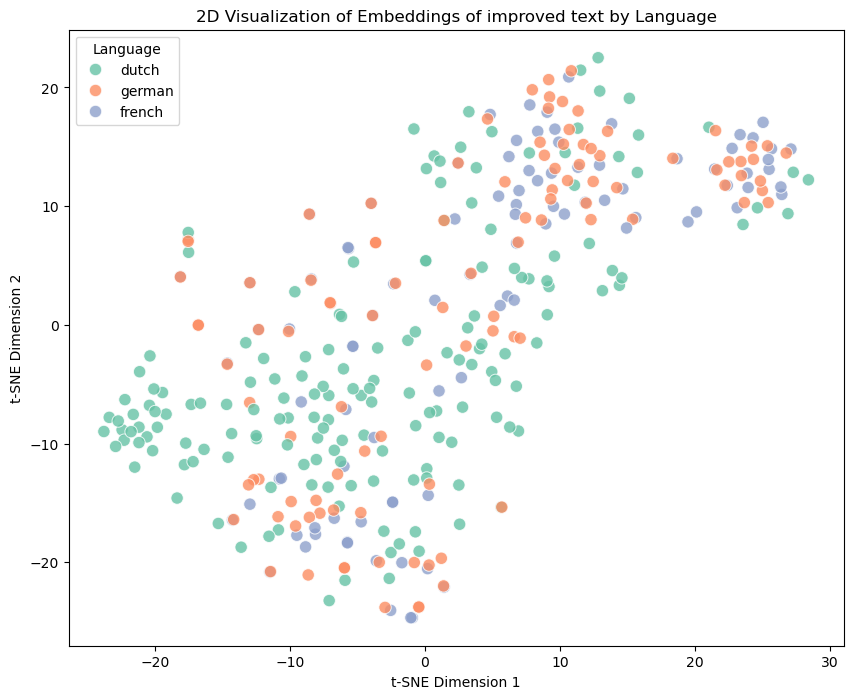

In [45]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

# Define your list of expected languages and the expected dimension size
languages = ['french', 'dutch', 'german']
EXPECTED_DIM = 384  # Adjust if your embeddings are a different size

# Store extracted embeddings in a list of dicts
embedding_data = []

# Iterate once over df and collect valid embeddings
for row in raw_embedding_df.iter_rows(named=True):
    for lang in languages:
        emb_col = f"{lang}_embedding"
        emb = row.get(emb_col, None)
        # Check if embedding is not None and has the expected dimension
        if emb is not None:
            emb_array = np.array(emb)
            if emb_array.shape[0] == EXPECTED_DIM:
                embedding_data.append({
                    "embedding": emb_array,
                    "language": lang
                })

# Convert to Polars DataFrame
emb_df = pl.DataFrame(embedding_data)

# Convert embeddings into NumPy array for t-SNE
# (At this point, we know all have shape (384,))
X = np.vstack(emb_df["embedding"].to_list())

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

# Add t-SNE dimensions back to Polars DataFrame
emb_df = emb_df.with_columns([
    pl.Series("tsne_1", X_tsne[:, 0]),
    pl.Series("tsne_2", X_tsne[:, 1])
])

# Convert to Pandas for visualization
emb_df_pandas = emb_df.to_pandas()

# Plot using Seaborn
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=emb_df_pandas,
    x="tsne_1",
    y="tsne_2",
    hue="language",
    palette="Set2",
    s=80,
    alpha=0.8
)
plt.title("2D Visualization of Embeddings of improved text by Language")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title="Language")
plt.show()


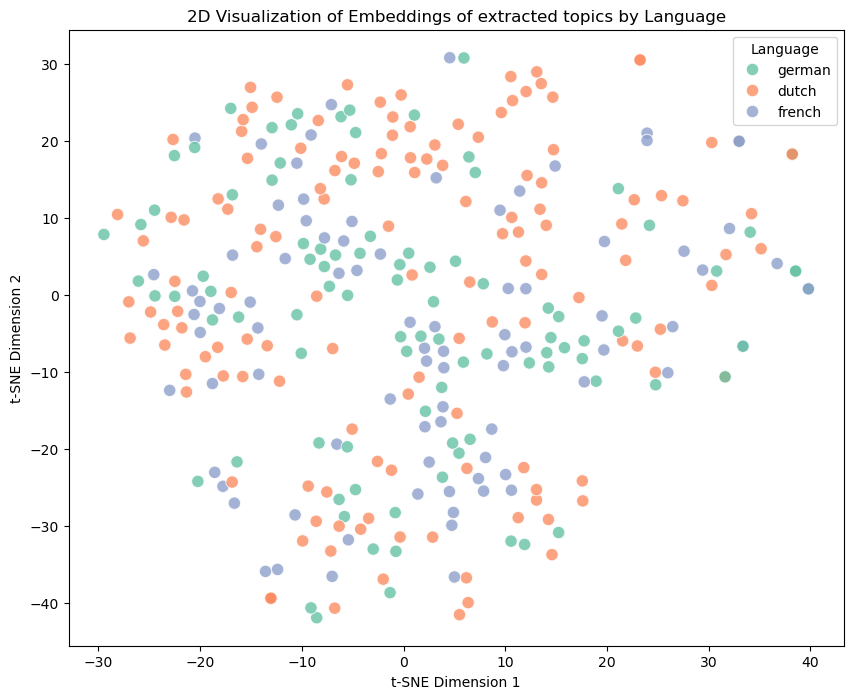

In [44]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

# Define your list of expected languages and the expected dimension size
languages = ['french', 'dutch', 'german']
EXPECTED_DIM = 384  # Adjust if your embeddings are a different size

# Store extracted embeddings in a list of dicts
embedding_data = []

# Iterate once over df and collect valid embeddings
for row in raw_embedding_df.iter_rows(named=True):
    for lang in languages:
        emb_col = f"topic_{lang}_embedding"
        emb = row.get(emb_col, None)
        # Check if embedding is not None and has the expected dimension
        if emb is not None:
            emb_array = np.array(emb)
            if emb_array.shape[0] == EXPECTED_DIM:
                embedding_data.append({
                    "embedding": emb_array,
                    "language": lang
                })

# Convert to Polars DataFrame
emb_df = pl.DataFrame(embedding_data)

# Convert embeddings into NumPy array for t-SNE
# (At this point, we know all have shape (384,))
X = np.vstack(emb_df["embedding"].to_list())

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

# Add t-SNE dimensions back to Polars DataFrame
emb_df = emb_df.with_columns([
    pl.Series("tsne_1", X_tsne[:, 0]),
    pl.Series("tsne_2", X_tsne[:, 1])
])

# Convert to Pandas for visualization
emb_df_pandas = emb_df.to_pandas()

# Plot using Seaborn
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=emb_df_pandas,
    x="tsne_1",
    y="tsne_2",
    hue="language",
    palette="Set2",
    s=80,
    alpha=0.8
)
plt.title("2D Visualization of Embeddings of extracted topics by Language")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title="Language")
plt.show()


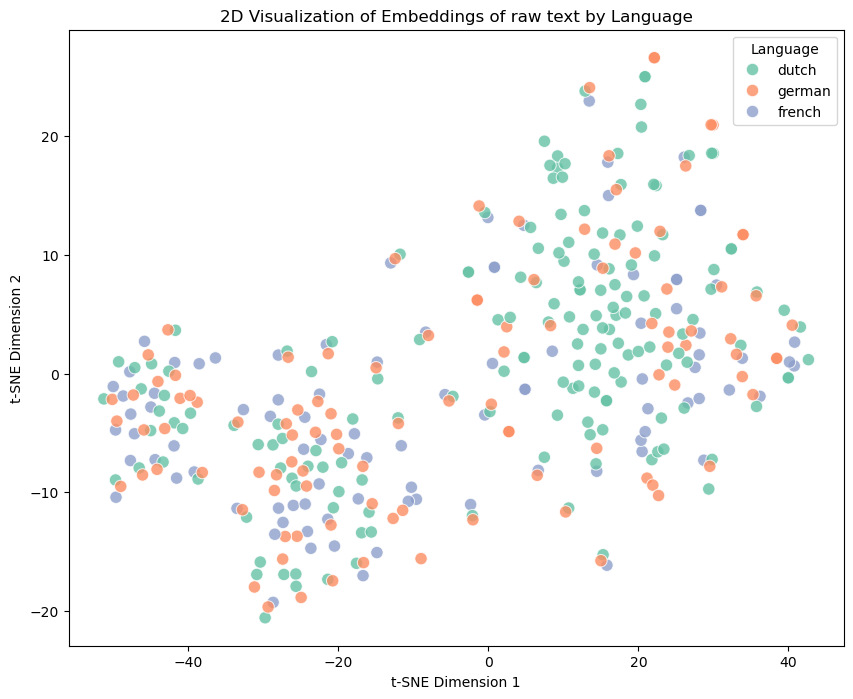

In [43]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

# Define your list of expected languages and the expected dimension size
languages = ['french', 'dutch', 'german']
EXPECTED_DIM = 384  # Adjust if your embeddings are a different size

# Store extracted embeddings in a list of dicts
embedding_data = []

# Iterate once over df and collect valid embeddings
for row in raw_embedding_df.iter_rows(named=True):
    for lang in languages:
        emb_col = f"raw_{lang}_embedding"
        emb = row.get(emb_col, None)
        # Check if embedding is not None and has the expected dimension
        if emb is not None:
            emb_array = np.array(emb)
            if emb_array.shape[0] == EXPECTED_DIM:
                embedding_data.append({
                    "embedding": emb_array,
                    "language": lang
                })

# Convert to Polars DataFrame
emb_df = pl.DataFrame(embedding_data)

# Convert embeddings into NumPy array for t-SNE
# (At this point, we know all have shape (384,))
X = np.vstack(emb_df["embedding"].to_list())

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

# Add t-SNE dimensions back to Polars DataFrame
emb_df = emb_df.with_columns([
    pl.Series("tsne_1", X_tsne[:, 0]),
    pl.Series("tsne_2", X_tsne[:, 1])
])

# Convert to Pandas for visualization
emb_df_pandas = emb_df.to_pandas()

# Plot using Seaborn
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=emb_df_pandas,
    x="tsne_1",
    y="tsne_2",
    hue="language",
    palette="Set2",
    s=80,
    alpha=0.8
)
plt.title("2D Visualization of Embeddings of raw text by Language")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title="Language")
plt.show()


sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.


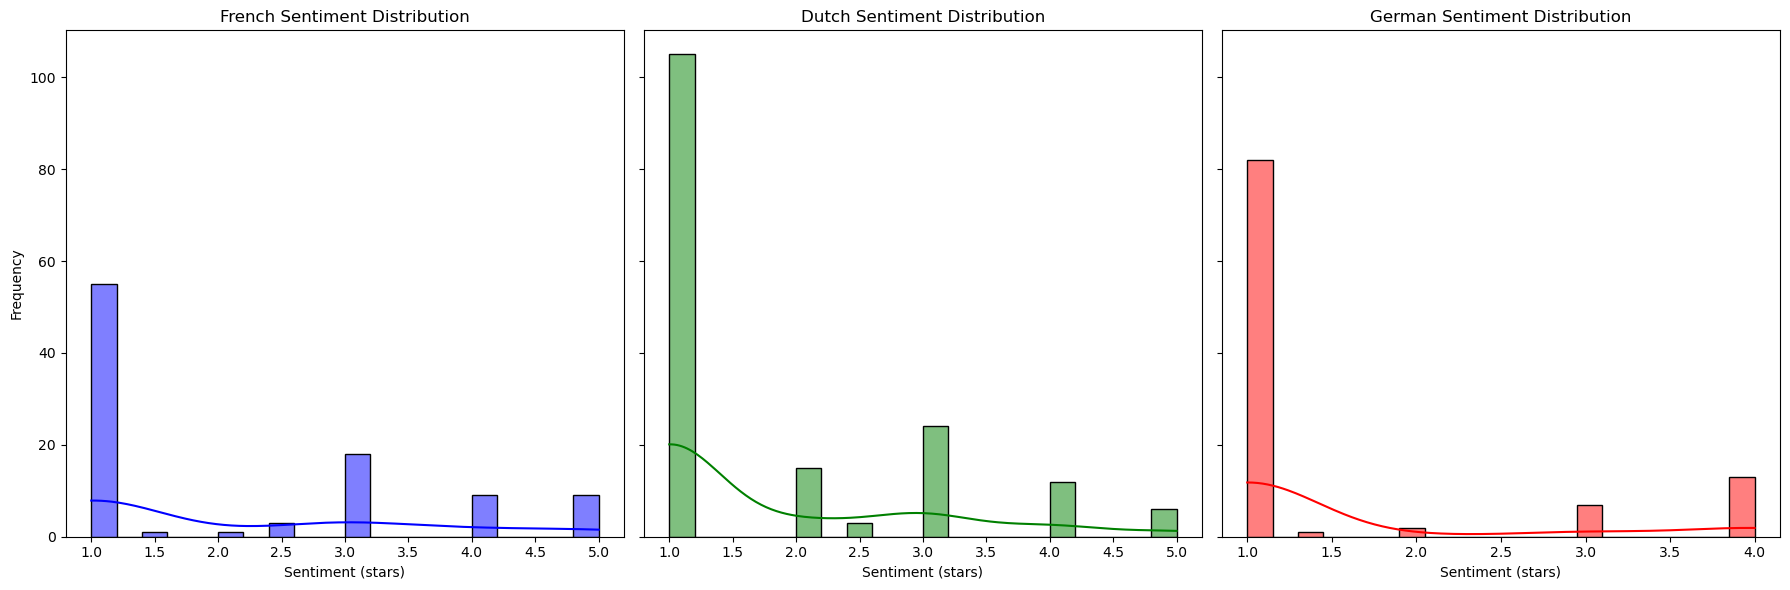

In [40]:
import polars as pl
import re
import seaborn as sns
import matplotlib.pyplot as plt

# Define a UDF to extract the numeric sentiment from a string (e.g., "4.20 stars")
def extract_sentiment_numeric_polars(val: str) -> float:
    if val is None:
        return None
    m = re.search(r'(\d+(\.\d+)?)', val)
    if m:
        return float(m.group(1))
    else:
        return None

# Assume `df` is your existing Polars DataFrame that includes the sentiment columns.
# Create new columns with the numeric sentiment values for French, Dutch, and German.
df = df.with_columns([
    pl.col("sentiment_french").map_elements(extract_sentiment_numeric_polars).alias("sentiment_french_numeric"),
    pl.col("sentiment_dutch").map_elements(extract_sentiment_numeric_polars).alias("sentiment_dutch_numeric"),
    pl.col("sentiment_german").map_elements(extract_sentiment_numeric_polars).alias("sentiment_german_numeric"),
])

# Convert the Polars DataFrame to pandas for plotting with Seaborn.
df_pdf = df.to_pandas()

# Create subplots for three histograms (one for each language)
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# French Sentiment Histogram
sns.histplot(
    data=df_pdf,
    x="sentiment_french_numeric",
    bins=20,
    kde=True,
    ax=axes[0],
    color="blue"
)
axes[0].set_title("French Sentiment Distribution")
axes[0].set_xlabel("Sentiment (stars)")
axes[0].set_ylabel("Frequency")

# Dutch Sentiment Histogram
sns.histplot(
    data=df_pdf,
    x="sentiment_dutch_numeric",
    bins=20,
    kde=True,
    ax=axes[1],
    color="green"
)
axes[1].set_title("Dutch Sentiment Distribution")
axes[1].set_xlabel("Sentiment (stars)")

# German Sentiment Histogram
sns.histplot(
    data=df_pdf,
    x="sentiment_german_numeric",
    bins=20,
    kde=True,
    ax=axes[2],
    color="red"
)
axes[2].set_title("German Sentiment Distribution")
axes[2].set_xlabel("Sentiment (stars)")

plt.tight_layout()
plt.show()


C:\Users\romai\AppData\Local\Temp\ipykernel_18240\1085404920.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_topics, x='topic', y='count', palette="Oranges_d")


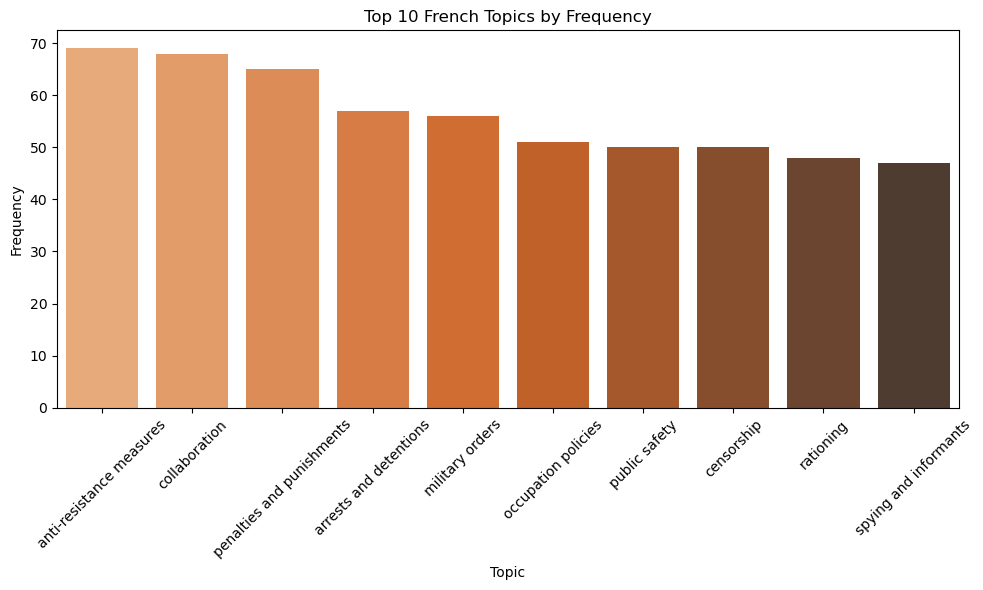

C:\Users\romai\AppData\Local\Temp\ipykernel_18240\1085404920.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_topics, x='topic', y='count', palette="Oranges_d")


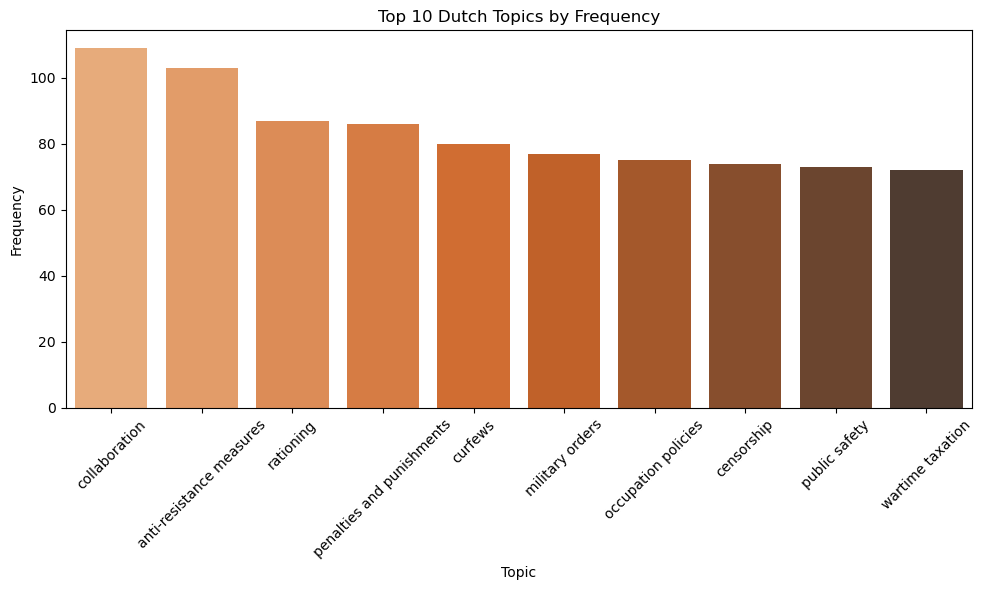

C:\Users\romai\AppData\Local\Temp\ipykernel_18240\1085404920.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_topics, x='topic', y='count', palette="Oranges_d")


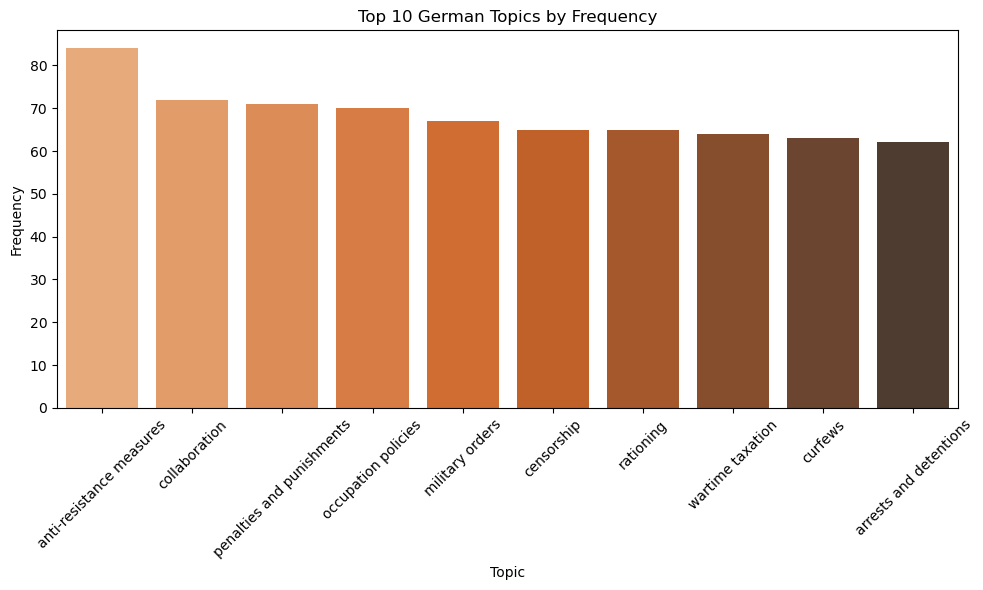

In [59]:
import re
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Assume df is your Polars DataFrame containing the following columns:
# "topics_french_text", "topics_dutch_text", "topics_german_text"

languages = ['french', 'dutch', 'german']

for lang in languages:
    col_name = f"topics_{lang}_text"
    topic_list = []
    
    # Drop null values and convert the column to a list of strings.
    topics_values = df[col_name].drop_nulls().to_list()
    
    # Loop through each entry in the topics column.
    for topics in topics_values:
        # Ensure the string is not empty.
        if topics.strip():
            # Split the comma-separated topics and strip whitespace.
            for topic in topics.split(','):
                topic = topic.strip()
                if topic:
                    topic_list.append(topic)
    
    # Count frequency of each topic.
    topic_counts = Counter(topic_list)
    
    # Convert the counts to a pandas DataFrame.
    topic_df = pd.DataFrame(topic_counts.items(), columns=['topic', 'count'])
    
    # Take the top 10 topics by frequency.
    top_topics = topic_df.sort_values(by='count', ascending=False).head(10)
    
    # Plot the results.
    plt.figure(figsize=(10, 6))
    sns.barplot(data=top_topics, x='topic', y='count', palette="Oranges_d")
    plt.title(f"Top 10 {lang.capitalize()} Topics by Frequency")
    plt.xlabel("Topic")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [ ]:
%%python -m spacy download fr_core_news_sm
%%python -m spacy download nl_core_news_sm
%%python -m spacy download de_core_news_sm

UsageError: %%python is a cell magic, but the cell body is empty.


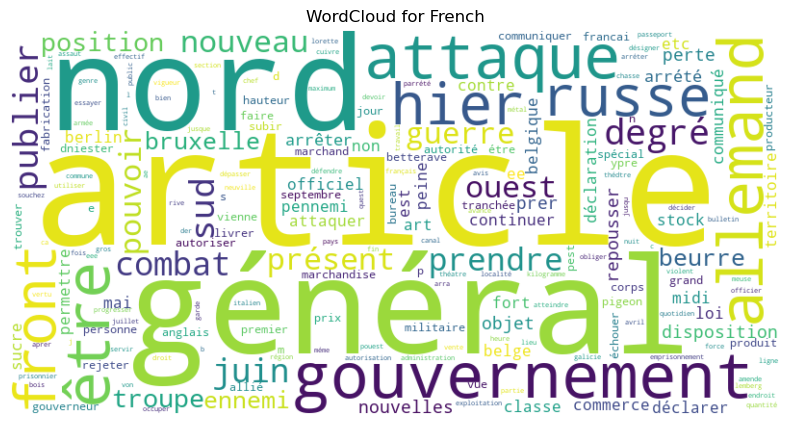

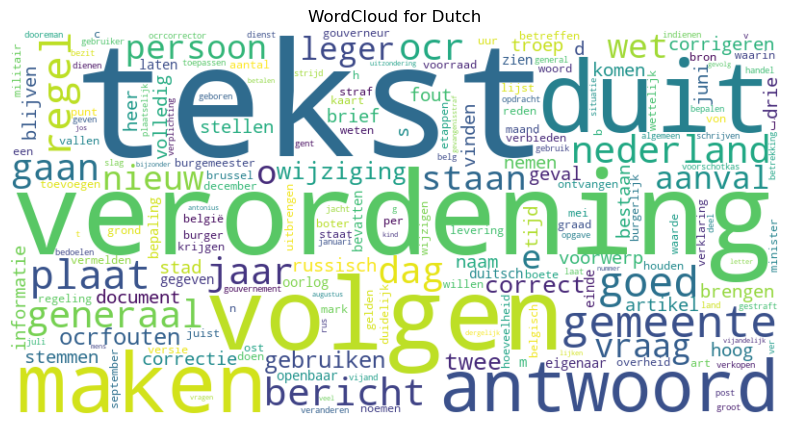

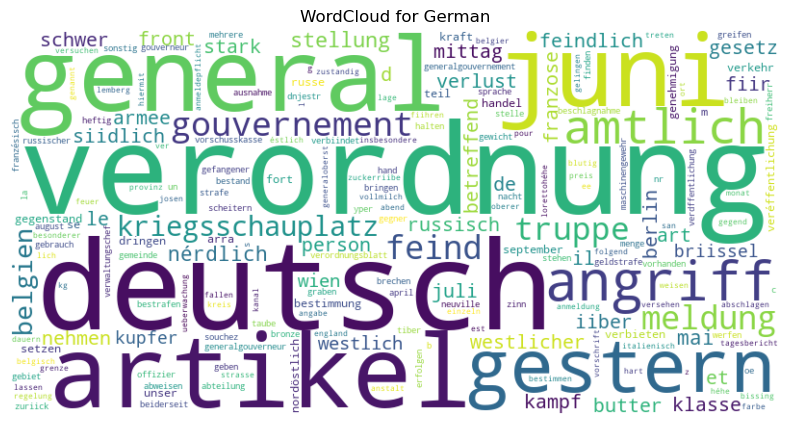

In [56]:
import spacy
import re
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Load spaCy models for French, Dutch, and German.
nlp_fr = spacy.load("fr_core_news_sm")
nlp_nl = spacy.load("nl_core_news_sm")
nlp_de = spacy.load("de_core_news_sm")

def preprocess_text(text, language):
    """
    Preprocess the text using spaCy:
      - Lowercase
      - Remove punctuation
      - Remove stopwords
      - Lemmatize tokens
    """
    # Select the appropriate spaCy model
    if language == "french":
        nlp = nlp_fr
    elif language == "dutch":
        nlp = nlp_nl
    elif language == "german":
        nlp = nlp_de
    else:
        return text.lower()  # fallback

    # Process the text with spaCy.
    doc = nlp(text)
    tokens = []
    for token in doc:
        if token.is_stop or token.is_punct:
            continue
        # Use the lemma and ensure it's lowercase and stripped of extra whitespace.
        lemma = token.lemma_.lower().strip()
        if lemma:
            tokens.append(lemma)
    return " ".join(tokens)

languages = ['french', 'dutch', 'german']

for lang in languages:
    text_data = " ".join(df[f"improved_{lang}_text"].drop_nulls().to_list())

    # Preprocess the text thoroughly.
    processed_text = preprocess_text(text_data, lang)

    # Generate the word cloud.
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color="white",
        collocations=False,
        stopwords=STOPWORDS
    ).generate(processed_text)

    # Plot the word cloud.
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"WordCloud for {lang.capitalize()}")
    plt.show()


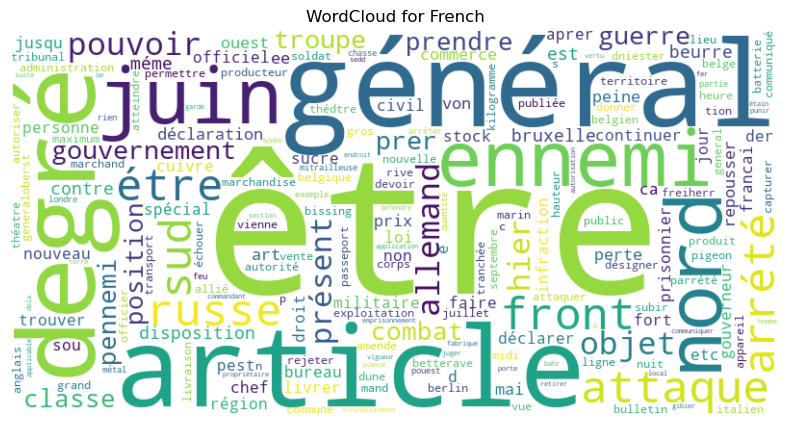

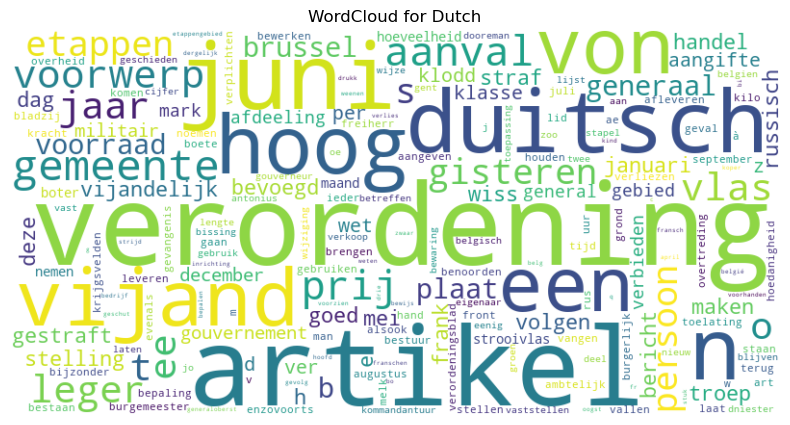

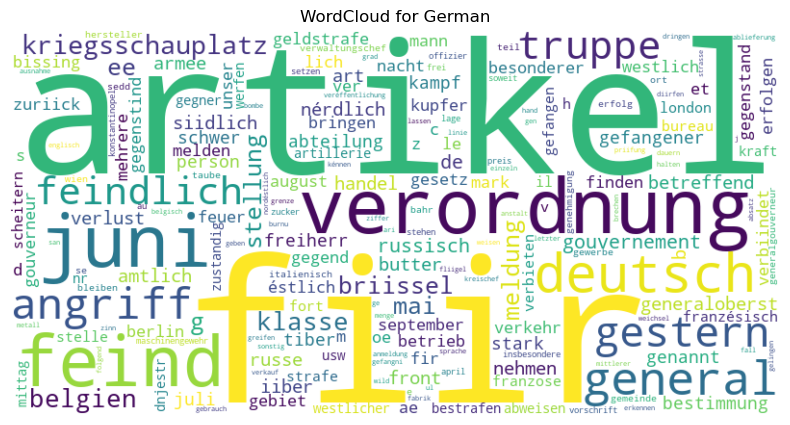

In [57]:
import spacy
import re
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Load spaCy models for French, Dutch, and German.
nlp_fr = spacy.load("fr_core_news_sm")
nlp_nl = spacy.load("nl_core_news_sm")
nlp_de = spacy.load("de_core_news_sm")

def preprocess_text(text, language):
    """
    Preprocess the text using spaCy:
      - Lowercase
      - Remove punctuation
      - Remove stopwords
      - Lemmatize tokens
    """
    # Select the appropriate spaCy model
    if language == "french":
        nlp = nlp_fr
    elif language == "dutch":
        nlp = nlp_nl
    elif language == "german":
        nlp = nlp_de
    else:
        return text.lower()  # fallback

    # Process the text with spaCy.
    doc = nlp(text)
    tokens = []
    for token in doc:
        if token.is_stop or token.is_punct:
            continue
        # Use the lemma and ensure it's lowercase and stripped of extra whitespace.
        lemma = token.lemma_.lower().strip()
        if lemma:
            tokens.append(lemma)
    return " ".join(tokens)

languages = ['french', 'dutch', 'german']

for lang in languages:
    text_data = " ".join(df[f"{lang}_text"].drop_nulls().to_list())

    # Preprocess the text thoroughly.
    processed_text = preprocess_text(text_data, lang)

    # Generate the word cloud.
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color="white",
        collocations=False,
        stopwords=STOPWORDS
    ).generate(processed_text)

    # Plot the word cloud.
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"WordCloud for {lang.capitalize()}")
    plt.show()
